In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(device)


n_output_mixtures = 20
n_attn_mixtures = 1
hidden_size = 128
input_size = 3
batch_size = 256
n_epochs = 1000
timestamps = 1200
lr = 1e-4
eps = 1e-6
model_name = "20210819_vae-var1"
base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
embedding_size = None # To be set to 73 later


cuda:2


In [2]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]


def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)



def draw(offsets, name=None, padding = 10, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.axis("off")
    if not name:
        plt.show()
    else:
        plt.savefig(name)
    plt.close('all')

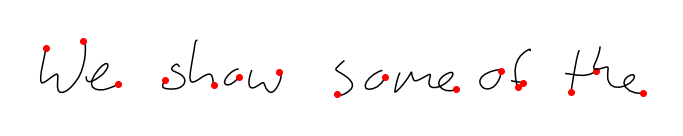

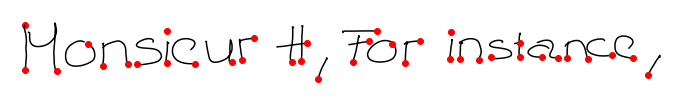

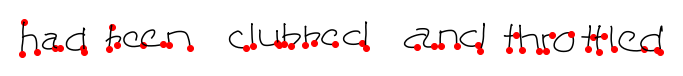

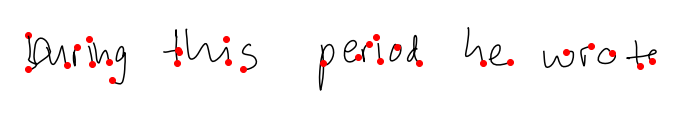

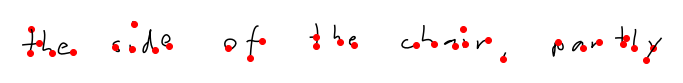

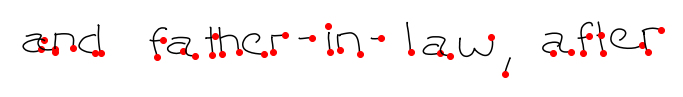

In [3]:
draw(strokes_og[23])
draw(strokes_og[230])
draw(strokes_og[231])
draw(strokes_og[223])
draw(strokes_og[123])
draw(strokes_og[233])

In [4]:
# for i in tqdm(range(len(strokes_og))):
#     draw(strokes_og[i],
#          name=f"data/images/0/{str(i)}.png",
#          padding=0,
#          plot_end_points=False)

In [5]:
! ls data/images/0/

10000.png  11533.png  2345.png	3878.png  5409.png  6941.png  8473.png
10001.png  11534.png  2346.png	3879.png  540.png   6942.png  8474.png
10002.png  11535.png  2347.png	387.png   5410.png  6943.png  8475.png
10003.png  11536.png  2348.png	3880.png  5411.png  6944.png  8476.png
10004.png  11537.png  2349.png	3881.png  5412.png  6945.png  8477.png
10005.png  11538.png  234.png	3882.png  5413.png  6946.png  8478.png
10006.png  11539.png  2350.png	3883.png  5414.png  6947.png  8479.png
10007.png  1153.png   2351.png	3884.png  5415.png  6948.png  847.png
10008.png  11540.png  2352.png	3885.png  5416.png  6949.png  8480.png
10009.png  11541.png  2353.png	3886.png  5417.png  694.png   8481.png
1000.png   11542.png  2354.png	3887.png  5418.png  6950.png  8482.png
10010.png  11543.png  2355.png	3888.png  5419.png  6951.png  8483.png
10011.png  11544.png  2356.png	3889.png  541.png   6952.png  8484.png
10012.png  11545.png  2357.png	388.png   5420.png  6953.png  8485.png
10013.png  11546.png  

In [6]:
! ls data/images/valid/0/

0.png


In [7]:
# ! mkdir data/images/0/
# ! mv data/images/* data/images/0/
# ! mkdir data/images/valid/
# ! mkdir data/images/valid/0/
# ! mv data/images/0/0.png data/images/valid/0/

(432, 864, 4)


(-0.5, 863.5, 431.5, -0.5)

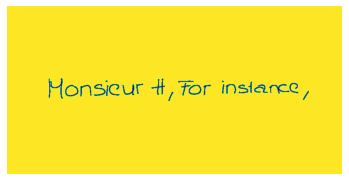

(-0.5, 863.5, 431.5, -0.5)

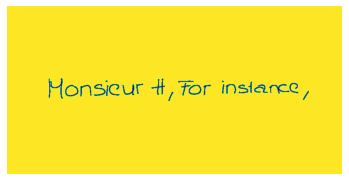

(-0.5, 863.5, 431.5, -0.5)

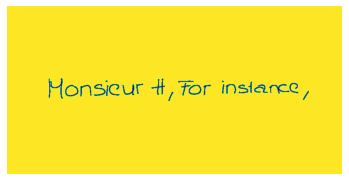

(-0.5, 863.5, 431.5, -0.5)

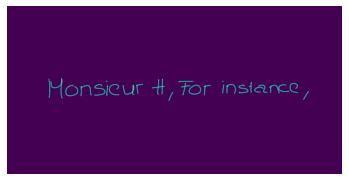

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('data/images/0/230.png')
print(img.shape)

for i in range(4):
    _=plt.imshow(img[:,:,i])
    plt.axis("off")
    plt.show()

In [9]:
for i in tqdm([23, 230, 231, 233]):
    img = mpimg.imread(f'data/images/0/{i}.png')
    print(img.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 122.32it/s]

(432, 864, 4)
(432, 864, 4)
(432, 864, 4)
(432, 864, 4)


In [10]:
# %load_ext tensorboard
# %tensorboard --logdir logs/

In [11]:
from einops import rearrange

import torch
from torch import nn, optim
import torch.nn.functional as F

class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 64, 64)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean
    
    def loss_fnc(self, x_hat, x, mu, log_vars):
        return criterion(x_hat, x) + (- 0.5 * torch.sum(1 + log_vars - mu.pow(2) - log_vars.exp()))

    
    def sample(self, valid_input):
        print("Validation")
        _= plt.imshow(valid_input.squeeze().permute(1, 2, 0).detach().cpu().numpy())
        _=plt.show()
        out, mu_v, log_vars_v = self.forward(valid_input)
        _= plt.imshow(out.squeeze().permute(1, 2, 0).detach().cpu().numpy())
        _=plt.show()
        print(f"validation loss: {self.loss_fnc(out, valid_input, mu_v, log_vars_v)}")
        
        print("Random")
        with torch.no_grad():
            z = torch.randn(10, self.z_dim).to(device)
            x_hat = self.decoder(z)
            fig = plt.figure(figsize=(80, 8))
            for i in range(4):
                _=fig.add_subplot(1, 10, i+1)
                _=plt.imshow(x_hat[i, :, :, :].squeeze().permute(1, 2, 0).detach().cpu().numpy())
            _=plt.show()


In [12]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms



data_path = 'data/images/'
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.CenterCrop(64)])
)

valid_dataset = torchvision.datasets.ImageFolder(
    root=data_path + "valid/",
    transform=transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.CenterCrop(64)])
)

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=True,
    drop_last=True
)
valid_dl = DataLoader(
    valid_dataset,
    batch_size=1,
    num_workers=1,
    shuffle=True,
    drop_last=True
)

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(120, 60))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[:nmax]), nrow=2).permute(1, 2, 0))

def show_batch(batch, nmax=64):
    for images, labels in train_dl:
        print(images.shape)
        show_images(images, nmax)
        break
        


In [13]:
import time

load_previous_state = True

model = VAE(z_dim=64)
if load_previous_state:
    checkpoint = torch.load(base_dir + model_name)
    model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)

criterion = nn.BCELoss(reduction = 'sum')

print_every = 25
sample_every = print_every * 10
n_iter = 0
loss = 0
losses = []
start_time = time.time()

total_iters = n_epochs * len(train_dl)


<All keys matched successfully>

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


n_iter : 0/46000, loss = 1557.582343750, time_since: 4.18
Validation


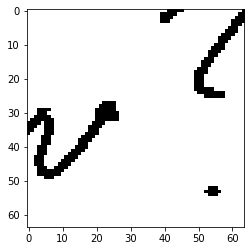

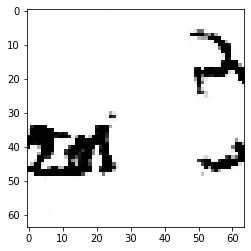

validation loss: 41444.2890625
Random


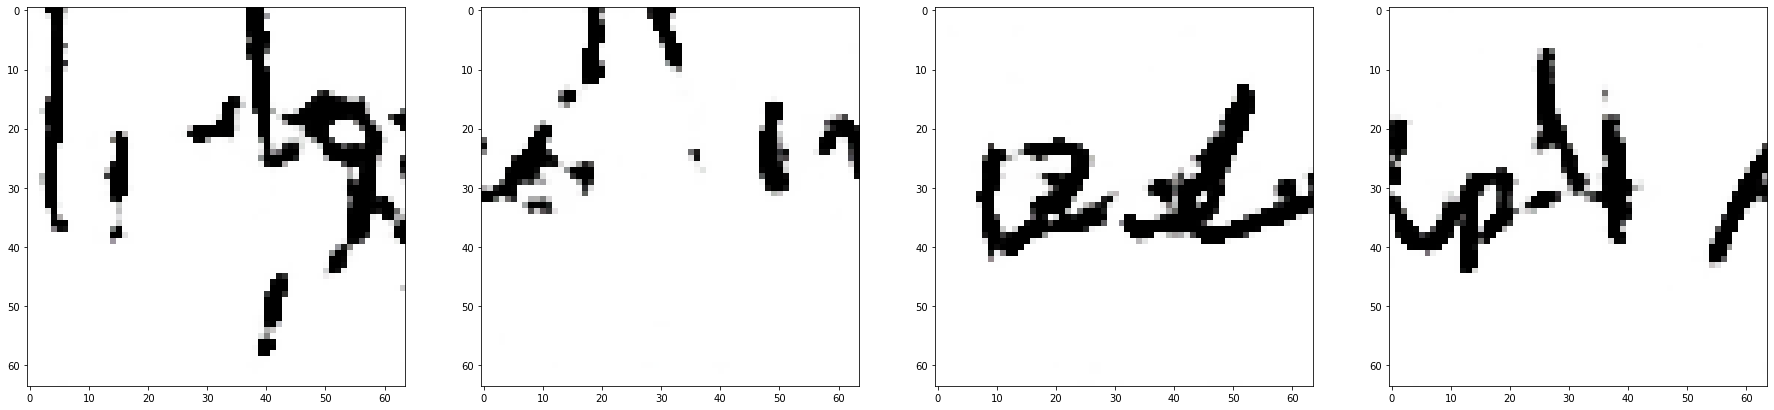

n_iter : 25/46000, loss = 45560.037031250, time_since: 21.02
n_iter : 50/46000, loss = 37952.315156250, time_since: 41.53
n_iter : 75/46000, loss = 38379.444218750, time_since: 58.62
n_iter : 100/46000, loss = 37963.543593750, time_since: 79.02
n_iter : 125/46000, loss = 37366.124687500, time_since: 96.10
n_iter : 150/46000, loss = 37229.357968750, time_since: 116.54
n_iter : 175/46000, loss = 37505.132031250, time_since: 133.73
n_iter : 200/46000, loss = 37157.869062500, time_since: 154.30
n_iter : 225/46000, loss = 38297.268593750, time_since: 171.51
n_iter : 250/46000, loss = 39143.272500000, time_since: 191.89


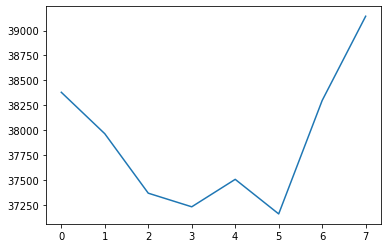

Validation


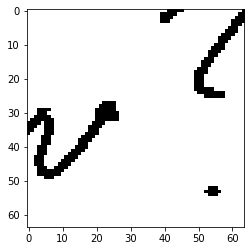

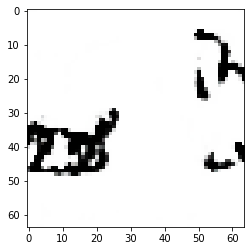

validation loss: 33317.515625
Random


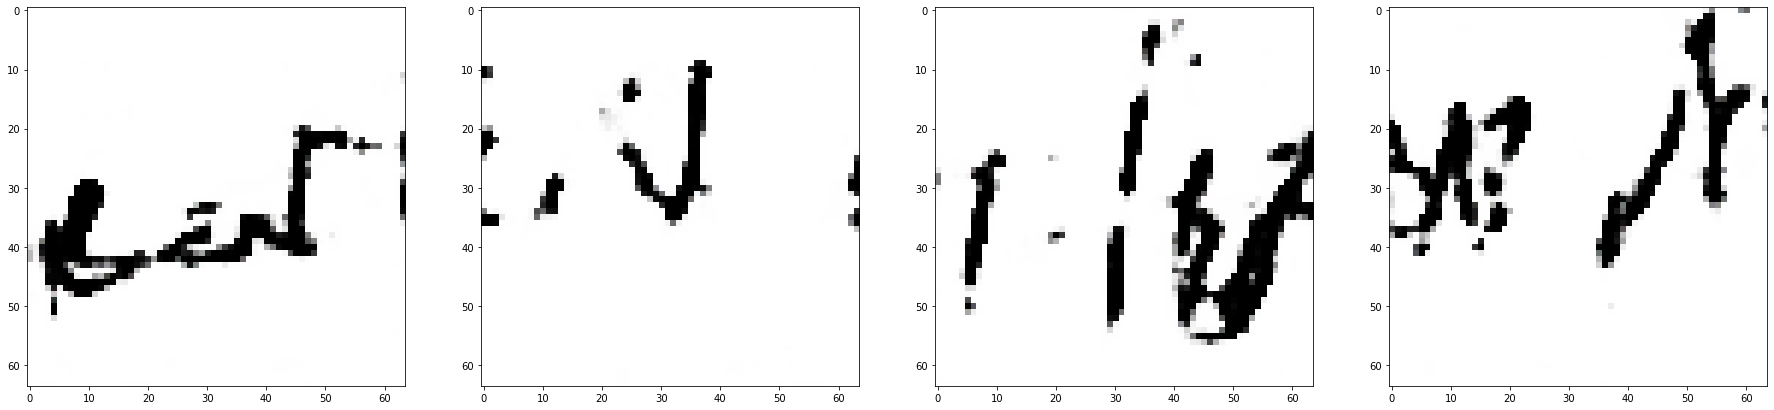

n_iter : 275/46000, loss = 38805.562812500, time_since: 208.93
n_iter : 300/46000, loss = 38952.626093750, time_since: 230.00
n_iter : 325/46000, loss = 38890.434218750, time_since: 249.90
n_iter : 350/46000, loss = 38737.324375000, time_since: 267.85
n_iter : 375/46000, loss = 38698.712500000, time_since: 287.97
n_iter : 400/46000, loss = 38590.957500000, time_since: 305.97
n_iter : 425/46000, loss = 39306.681562500, time_since: 325.80
n_iter : 450/46000, loss = 39150.182500000, time_since: 343.36
n_iter : 475/46000, loss = 38624.890000000, time_since: 363.17
n_iter : 500/46000, loss = 39754.947968750, time_since: 380.43


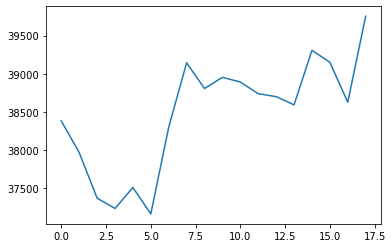

Validation


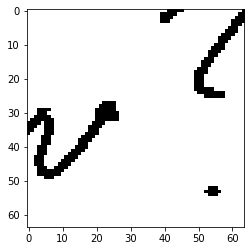

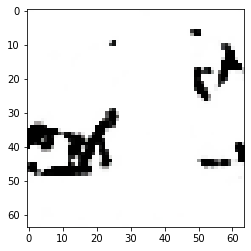

validation loss: 37077.44140625
Random


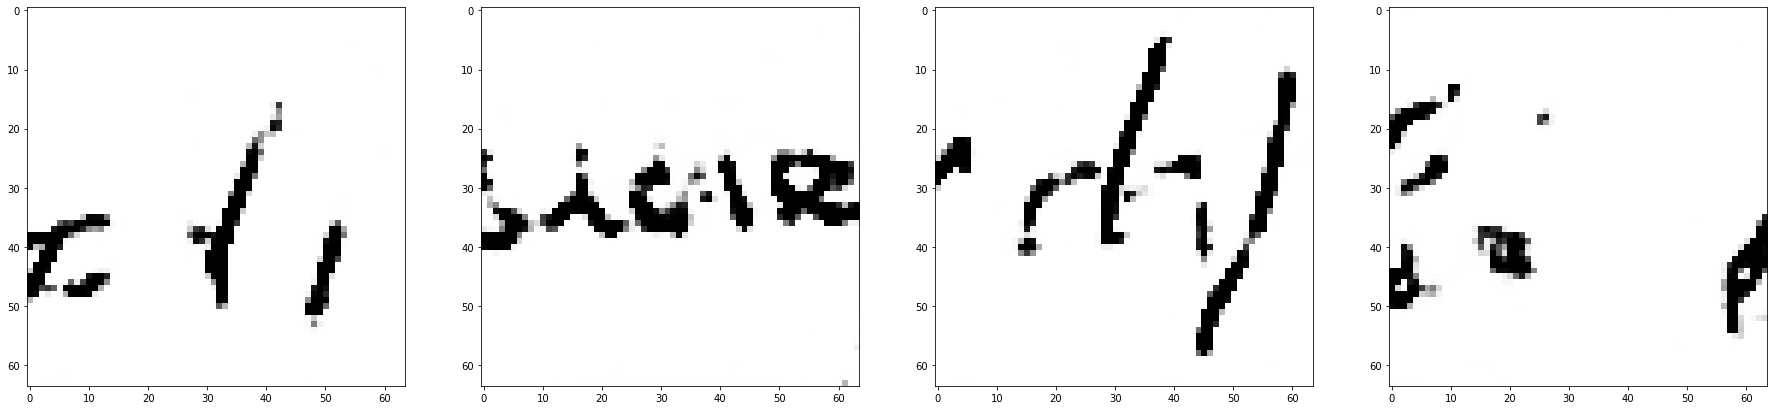

n_iter : 525/46000, loss = 39047.934375000, time_since: 401.72
n_iter : 550/46000, loss = 39231.360781250, time_since: 419.23
n_iter : 575/46000, loss = 39262.427812500, time_since: 439.74
n_iter : 600/46000, loss = 38671.958125000, time_since: 460.58
n_iter : 625/46000, loss = 39098.945625000, time_since: 477.78
n_iter : 650/46000, loss = 39791.579375000, time_since: 498.64
n_iter : 675/46000, loss = 40512.018593750, time_since: 515.86
n_iter : 700/46000, loss = 39711.838281250, time_since: 536.73
n_iter : 725/46000, loss = 39044.687500000, time_since: 553.84
n_iter : 750/46000, loss = 39078.561250000, time_since: 574.71


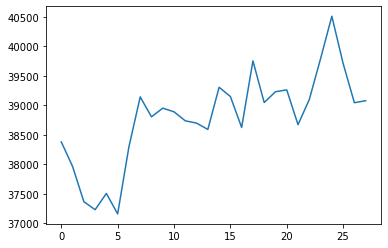

Validation


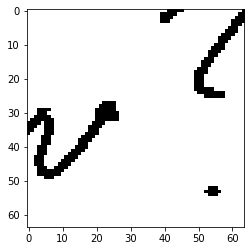

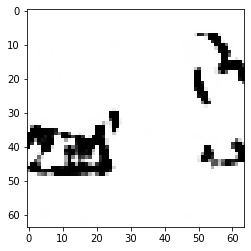

validation loss: 39243.92578125
Random


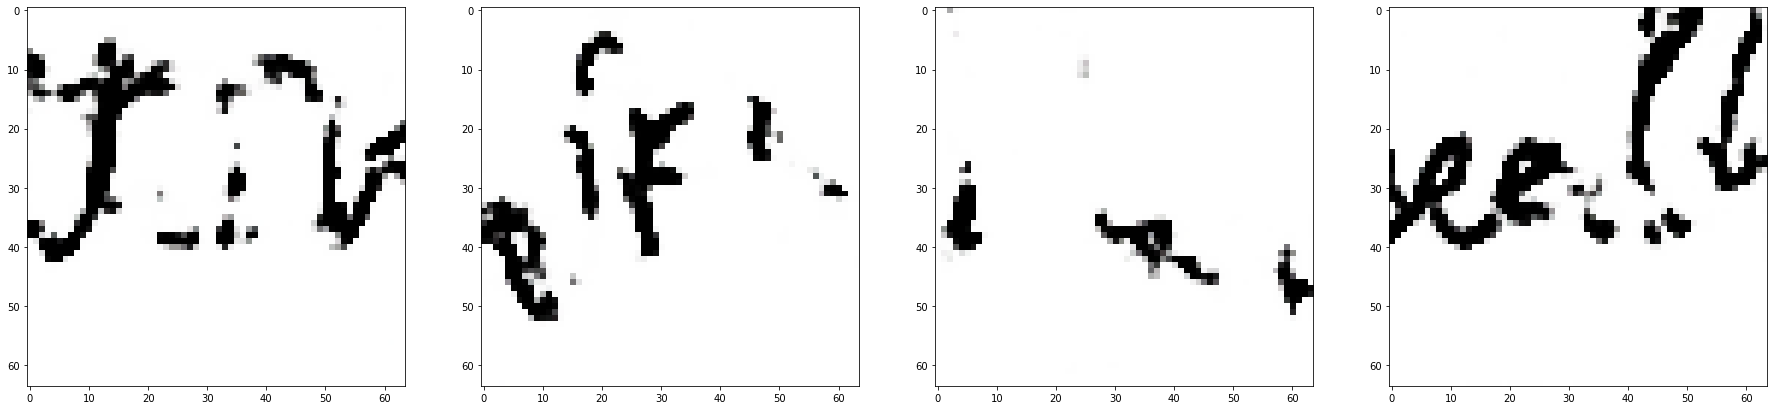

n_iter : 775/46000, loss = 37971.394375000, time_since: 591.91
n_iter : 800/46000, loss = 38545.837968750, time_since: 613.79
n_iter : 825/46000, loss = 37874.231406250, time_since: 631.76
n_iter : 850/46000, loss = 37217.958593750, time_since: 654.19
n_iter : 875/46000, loss = 38295.679062500, time_since: 676.50
n_iter : 900/46000, loss = 37943.737968750, time_since: 695.35
n_iter : 925/46000, loss = 39091.283906250, time_since: 716.82
n_iter : 950/46000, loss = 39745.740468750, time_since: 735.74
n_iter : 975/46000, loss = 39871.424531250, time_since: 758.83
n_iter : 1000/46000, loss = 38700.050937500, time_since: 778.70


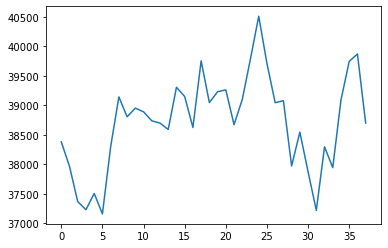

Validation


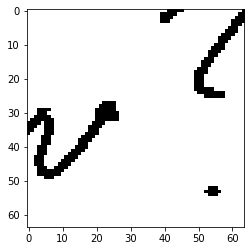

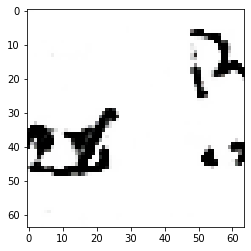

validation loss: 38019.08203125
Random


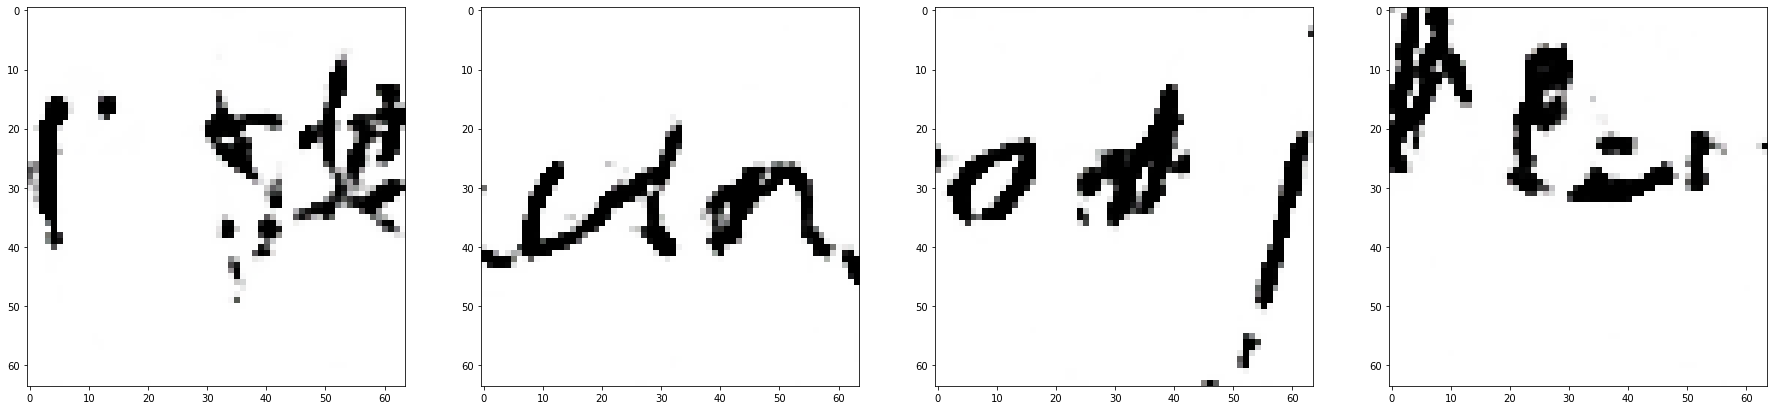

n_iter : 1025/46000, loss = 39156.693125000, time_since: 801.96
n_iter : 1050/46000, loss = 38380.987187500, time_since: 819.99
n_iter : 1075/46000, loss = 38442.514843750, time_since: 842.57
n_iter : 1100/46000, loss = 38345.247343750, time_since: 860.91
n_iter : 1125/46000, loss = 37848.907656250, time_since: 883.36
n_iter : 1150/46000, loss = 38122.290937500, time_since: 905.98
n_iter : 1175/46000, loss = 37644.182343750, time_since: 924.50
n_iter : 1200/46000, loss = 39189.582500000, time_since: 946.37
n_iter : 1225/46000, loss = 38539.104218750, time_since: 964.75
n_iter : 1250/46000, loss = 39060.785468750, time_since: 986.53


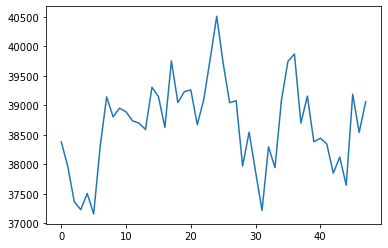

Validation


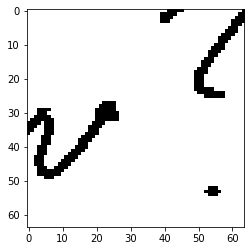

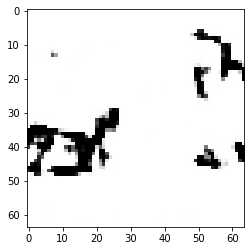

validation loss: 37432.45703125
Random


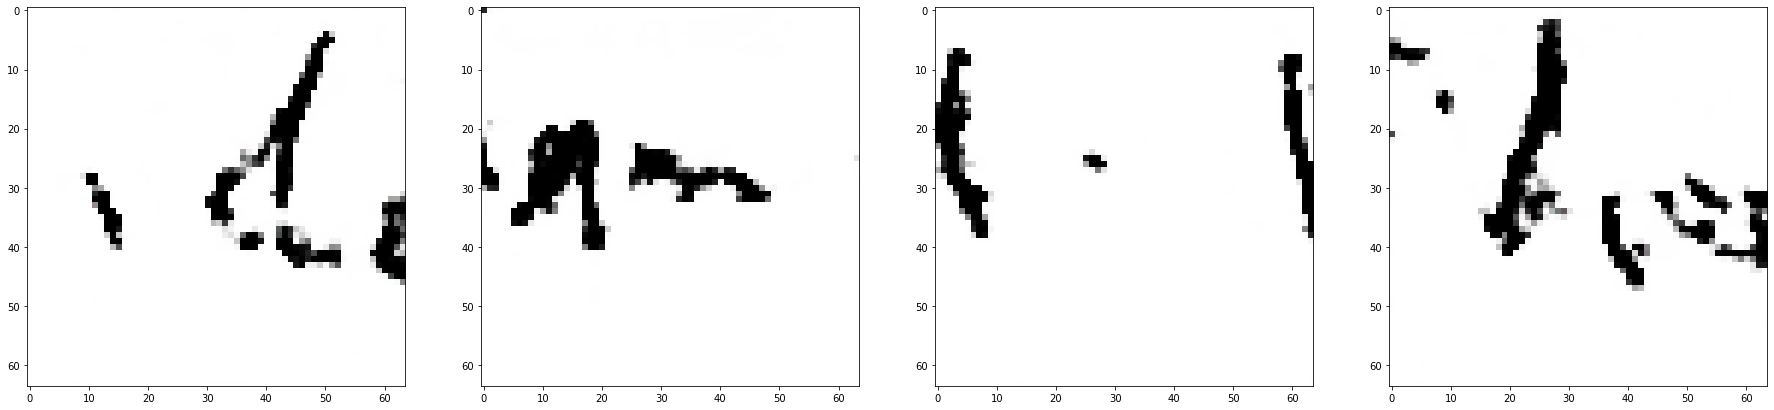

n_iter : 1275/46000, loss = 39071.435156250, time_since: 1004.90
n_iter : 1300/46000, loss = 38142.255468750, time_since: 1028.19
n_iter : 1325/46000, loss = 38693.942968750, time_since: 1047.65
n_iter : 1350/46000, loss = 37962.693125000, time_since: 1070.77
n_iter : 1375/46000, loss = 38691.515312500, time_since: 1091.64
n_iter : 1400/46000, loss = 38359.298750000, time_since: 1115.53
n_iter : 1425/46000, loss = 38206.956406250, time_since: 1135.32
n_iter : 1450/46000, loss = 37791.594062500, time_since: 1159.55
n_iter : 1475/46000, loss = 38078.455156250, time_since: 1181.43
n_iter : 1500/46000, loss = 38616.622031250, time_since: 1202.30


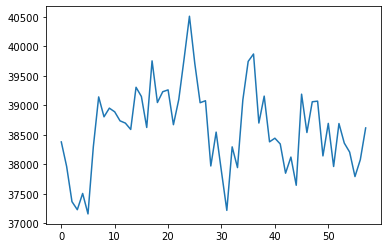

Validation


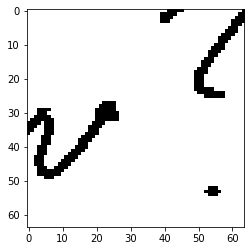

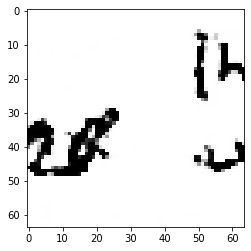

validation loss: 32750.693359375
Random


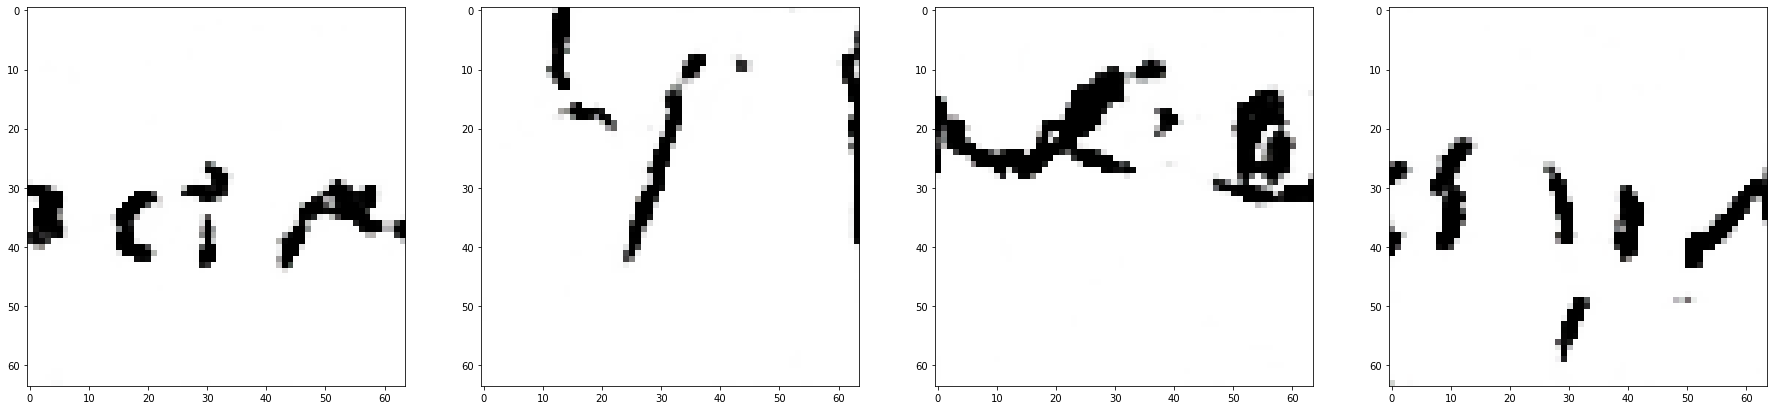

n_iter : 1525/46000, loss = 38447.413437500, time_since: 1224.53
n_iter : 1550/46000, loss = 38768.730000000, time_since: 1243.60
n_iter : 1575/46000, loss = 38732.264843750, time_since: 1265.20
n_iter : 1600/46000, loss = 38827.191562500, time_since: 1283.61
n_iter : 1625/46000, loss = 39135.260625000, time_since: 1305.04
n_iter : 1650/46000, loss = 38923.132500000, time_since: 1323.35
n_iter : 1675/46000, loss = 38935.662187500, time_since: 1344.93
n_iter : 1700/46000, loss = 38287.020000000, time_since: 1364.19
n_iter : 1725/46000, loss = 37364.044531250, time_since: 1385.87
n_iter : 1750/46000, loss = 38038.102968750, time_since: 1408.28


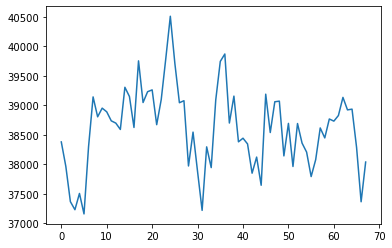

Validation


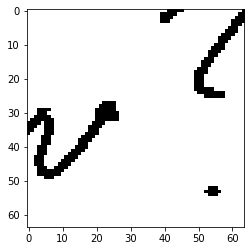

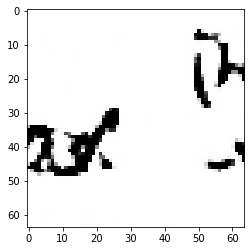

validation loss: 37693.375
Random


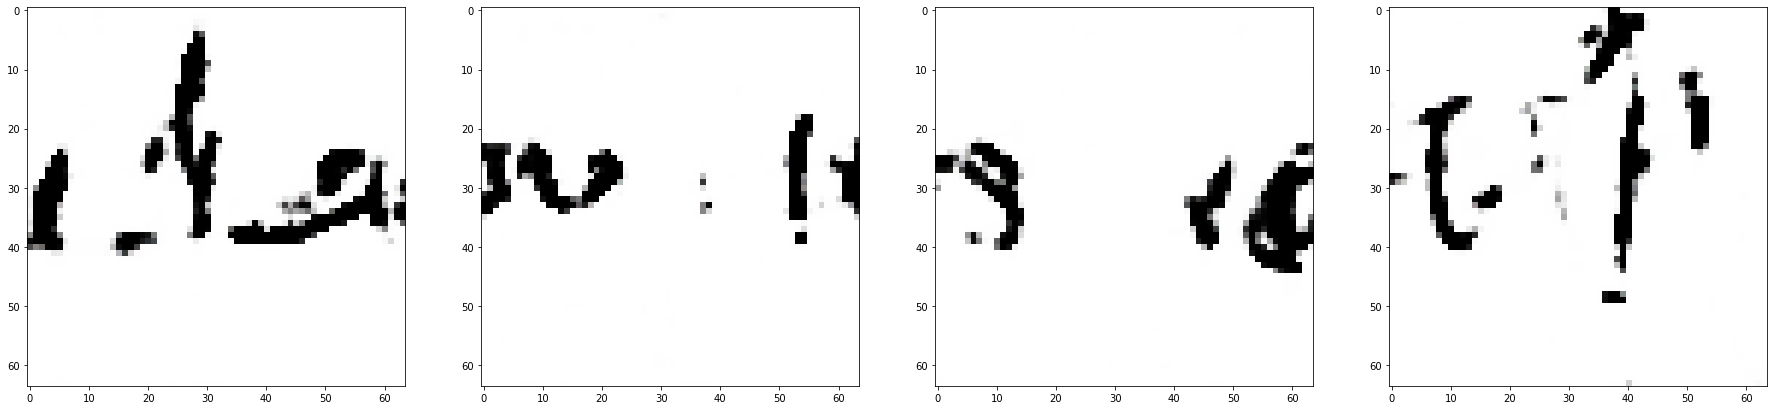

n_iter : 1775/46000, loss = 37165.703281250, time_since: 1426.43
n_iter : 1800/46000, loss = 37652.293593750, time_since: 1448.72
n_iter : 1825/46000, loss = 37311.320937500, time_since: 1468.68
n_iter : 1850/46000, loss = 37794.859687500, time_since: 1492.05
n_iter : 1875/46000, loss = 37158.099687500, time_since: 1511.80
n_iter : 1900/46000, loss = 38157.058281250, time_since: 1535.46
n_iter : 1925/46000, loss = 37229.426562500, time_since: 1555.07
n_iter : 1950/46000, loss = 37600.963593750, time_since: 1578.76
n_iter : 1975/46000, loss = 37674.174687500, time_since: 1598.44
n_iter : 2000/46000, loss = 37694.637812500, time_since: 1621.40


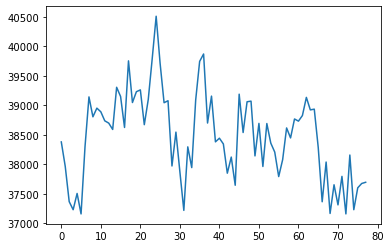

Validation


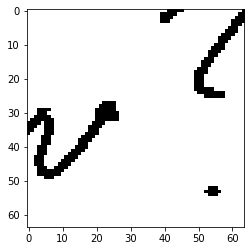

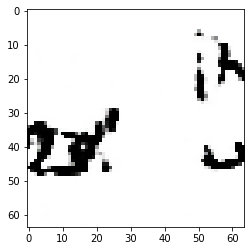

validation loss: 34359.83984375
Random


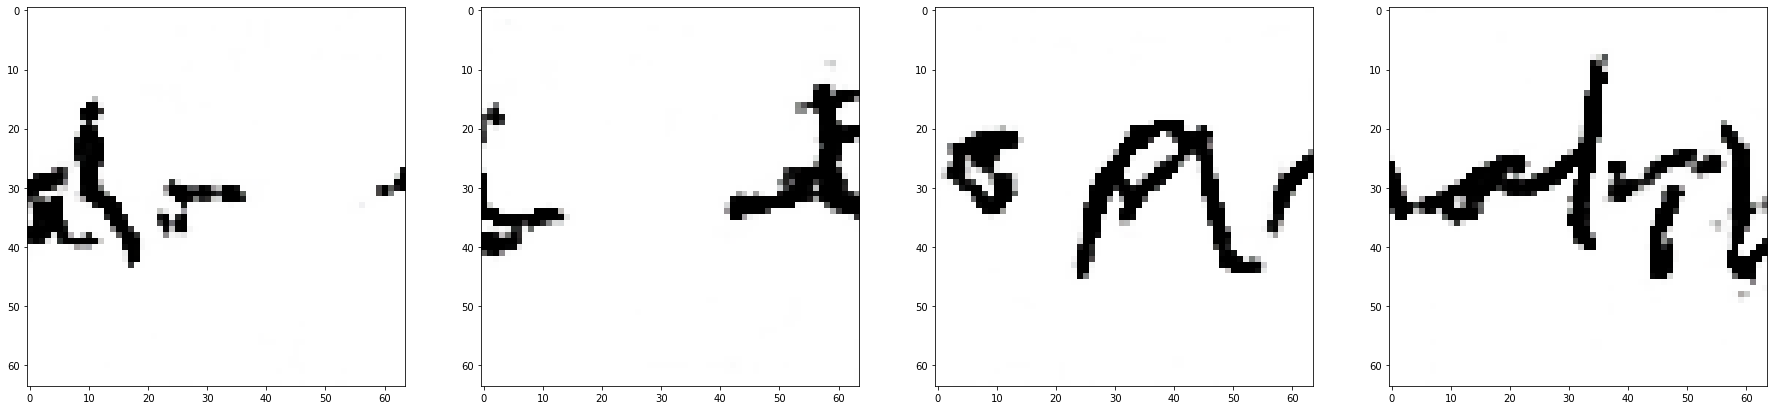

n_iter : 2025/46000, loss = 37868.103437500, time_since: 1645.26
n_iter : 2050/46000, loss = 37651.078281250, time_since: 1663.82
n_iter : 2075/46000, loss = 38058.884843750, time_since: 1686.19
n_iter : 2100/46000, loss = 38934.705312500, time_since: 1704.27
n_iter : 2125/46000, loss = 38665.457187500, time_since: 1726.42
n_iter : 2150/46000, loss = 38598.359375000, time_since: 1744.70
n_iter : 2175/46000, loss = 38520.755468750, time_since: 1767.19
n_iter : 2200/46000, loss = 38293.526406250, time_since: 1785.21
n_iter : 2225/46000, loss = 37942.316406250, time_since: 1806.99
n_iter : 2250/46000, loss = 38005.360625000, time_since: 1825.33


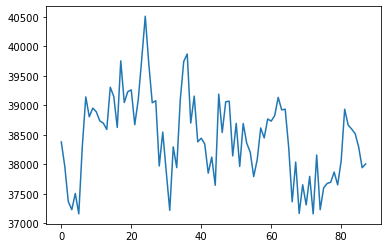

Validation


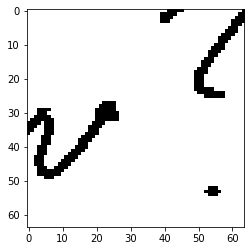

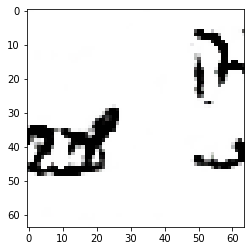

validation loss: 35841.0390625
Random


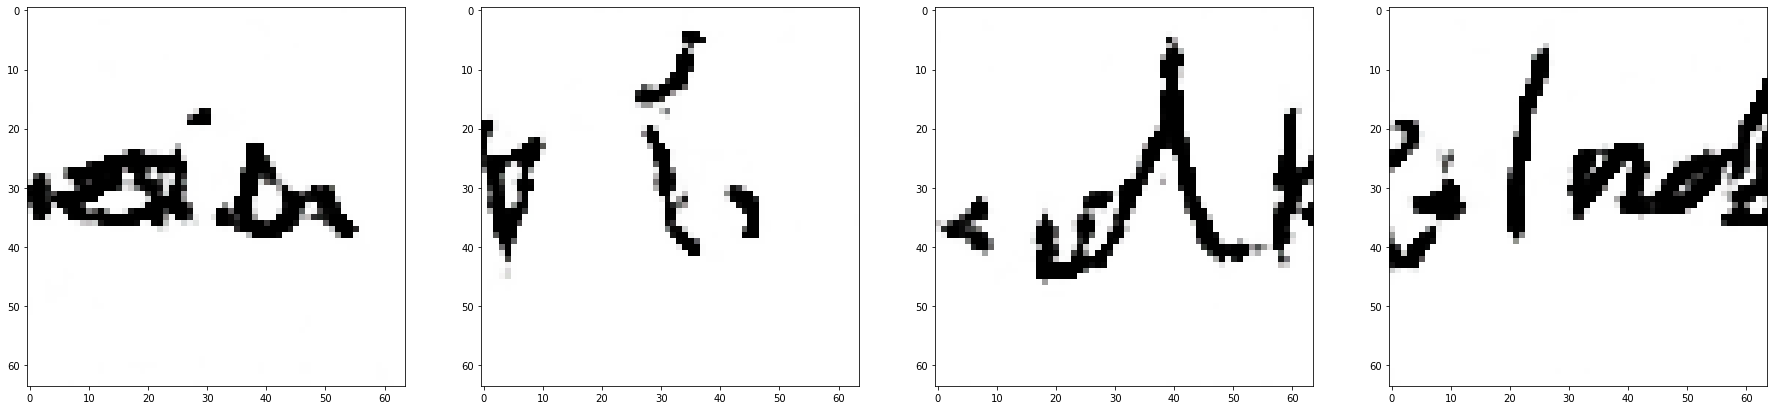

n_iter : 2275/46000, loss = 37252.362500000, time_since: 1849.27
n_iter : 2300/46000, loss = 37553.992343750, time_since: 1874.95
n_iter : 2325/46000, loss = 37304.058125000, time_since: 1895.34
n_iter : 2350/46000, loss = 37493.029375000, time_since: 1918.87
n_iter : 2375/46000, loss = 37609.801562500, time_since: 1939.06
n_iter : 2400/46000, loss = 37670.472968750, time_since: 1962.72
n_iter : 2425/46000, loss = 37649.641875000, time_since: 1982.85
n_iter : 2450/46000, loss = 37417.024843750, time_since: 2006.38
n_iter : 2475/46000, loss = 37111.876718750, time_since: 2026.27
n_iter : 2500/46000, loss = 38837.764687500, time_since: 2049.75


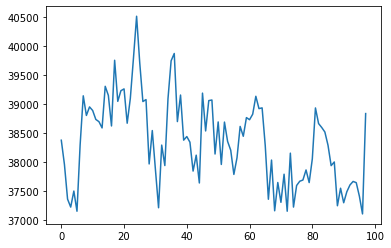

Validation


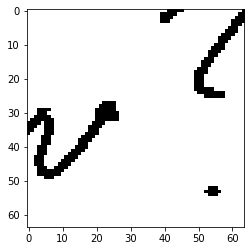

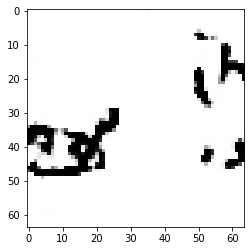

validation loss: 35317.1640625
Random


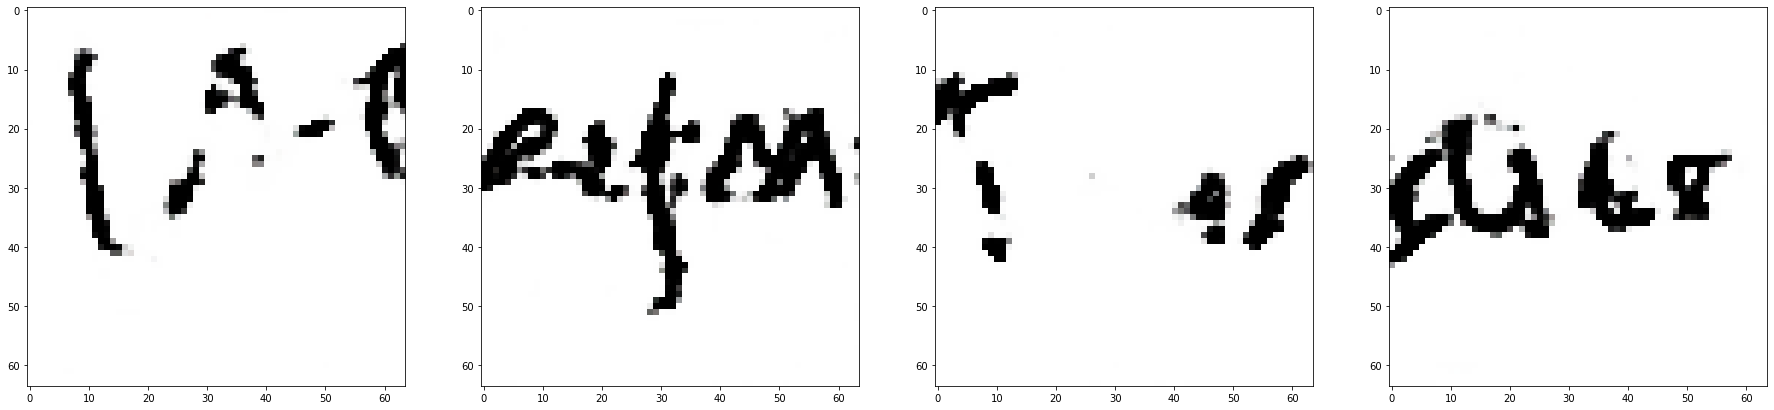

n_iter : 2525/46000, loss = 38481.258437500, time_since: 2069.48
n_iter : 2550/46000, loss = 39014.925156250, time_since: 2091.96
n_iter : 2575/46000, loss = 38625.526406250, time_since: 2110.55
n_iter : 2600/46000, loss = 37831.801562500, time_since: 2133.24
n_iter : 2625/46000, loss = 38107.261718750, time_since: 2154.50
n_iter : 2650/46000, loss = 38327.655625000, time_since: 2173.29
n_iter : 2675/46000, loss = 37573.451250000, time_since: 2194.64
n_iter : 2700/46000, loss = 37621.338906250, time_since: 2214.08
n_iter : 2725/46000, loss = 37535.798906250, time_since: 2235.56
n_iter : 2750/46000, loss = 37026.001718750, time_since: 2254.08


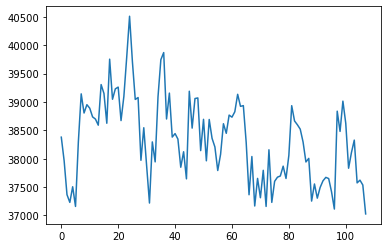

Validation


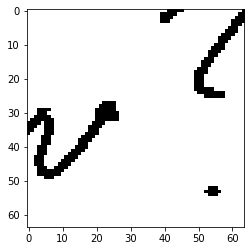

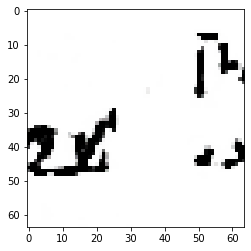

validation loss: 40956.44140625
Random


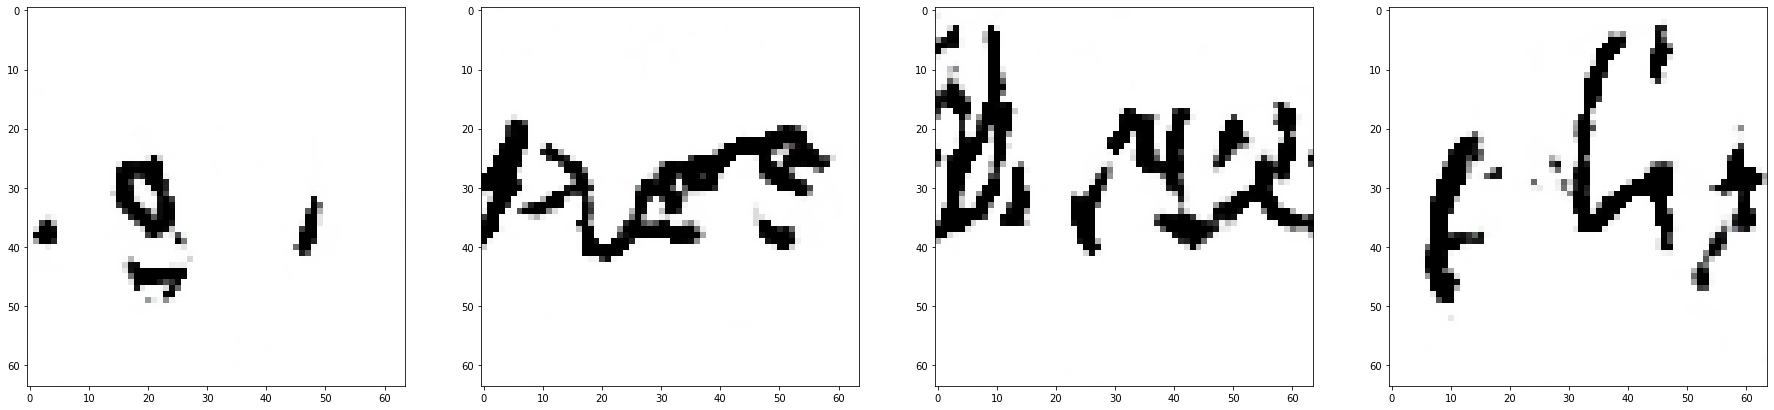

n_iter : 2775/46000, loss = 36889.388281250, time_since: 2276.23
n_iter : 2800/46000, loss = 36735.563437500, time_since: 2297.32
n_iter : 2825/46000, loss = 35841.101250000, time_since: 2320.11
n_iter : 2850/46000, loss = 36837.545312500, time_since: 2341.40
n_iter : 2875/46000, loss = 36902.234062500, time_since: 2364.39
n_iter : 2900/46000, loss = 36852.448281250, time_since: 2387.81
n_iter : 2925/46000, loss = 36715.704375000, time_since: 2407.69
n_iter : 2950/46000, loss = 37017.482812500, time_since: 2431.64
n_iter : 2975/46000, loss = 37057.807343750, time_since: 2451.92
n_iter : 3000/46000, loss = 36885.873906250, time_since: 2475.57


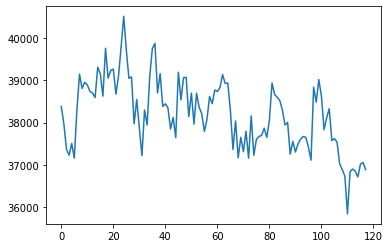

Validation


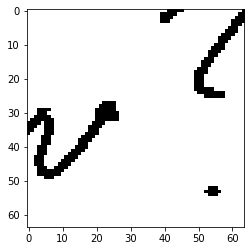

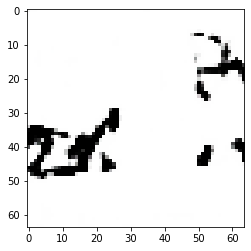

validation loss: 40012.42578125
Random


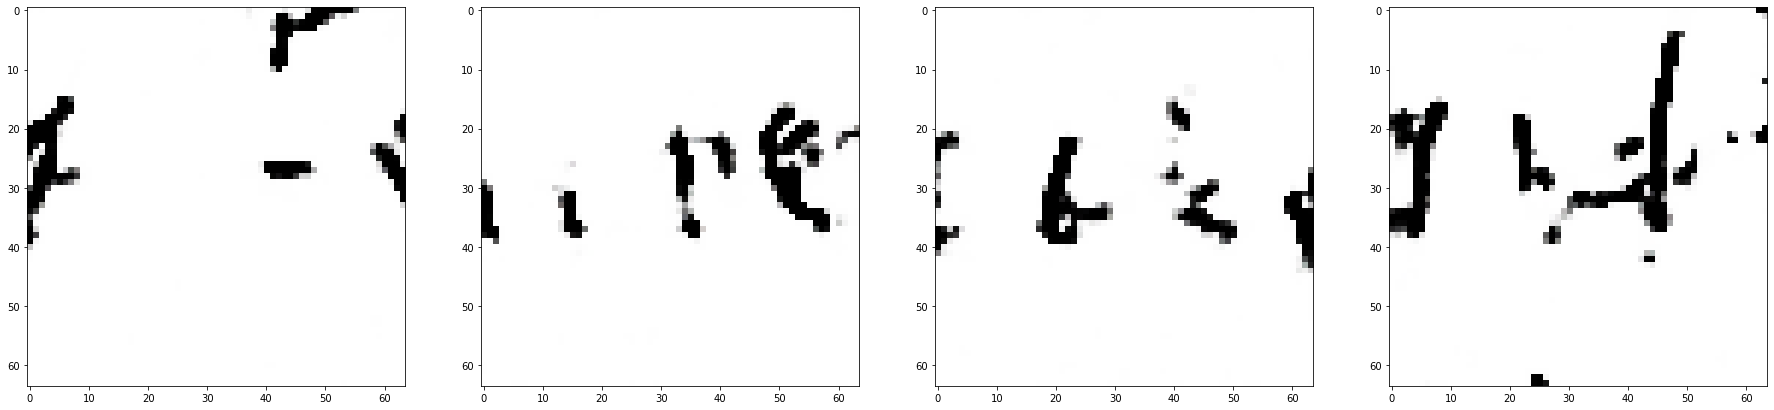

n_iter : 3025/46000, loss = 37574.286250000, time_since: 2495.76
n_iter : 3050/46000, loss = 37359.727343750, time_since: 2518.97
n_iter : 3075/46000, loss = 37042.796406250, time_since: 2536.79
n_iter : 3100/46000, loss = 36772.029375000, time_since: 2559.11
n_iter : 3125/46000, loss = 37116.817656250, time_since: 2577.13
n_iter : 3150/46000, loss = 37301.707500000, time_since: 2599.50
n_iter : 3175/46000, loss = 37280.330156250, time_since: 2621.56
n_iter : 3200/46000, loss = 36872.702187500, time_since: 2639.71
n_iter : 3225/46000, loss = 37220.813125000, time_since: 2661.88
n_iter : 3250/46000, loss = 37232.693437500, time_since: 2680.07


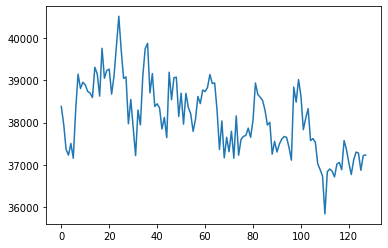

Validation


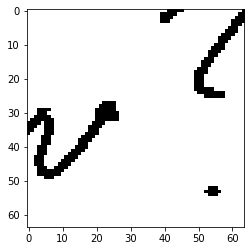

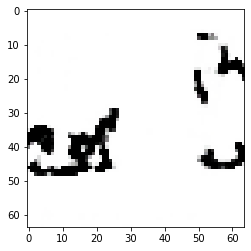

validation loss: 40194.63671875
Random


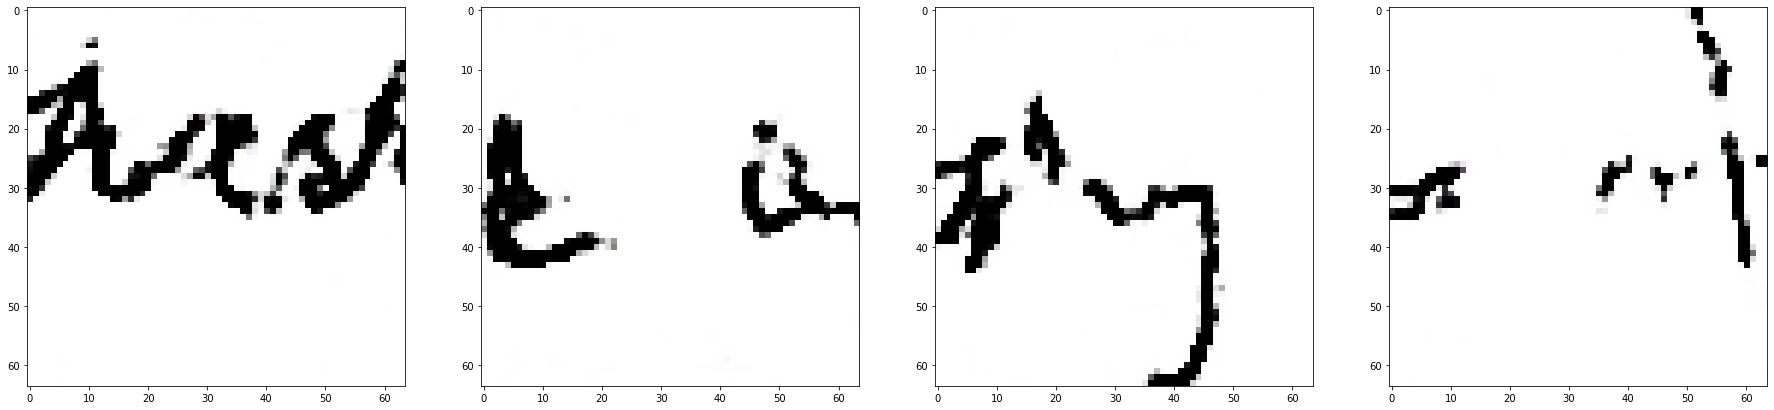

n_iter : 3275/46000, loss = 37061.802500000, time_since: 2702.43
n_iter : 3300/46000, loss = 37528.557656250, time_since: 2721.38
n_iter : 3325/46000, loss = 37112.286718750, time_since: 2744.62
n_iter : 3350/46000, loss = 37559.432656250, time_since: 2763.39
n_iter : 3375/46000, loss = 37143.360000000, time_since: 2786.90
n_iter : 3400/46000, loss = 37679.038281250, time_since: 2806.57
n_iter : 3425/46000, loss = 36812.843750000, time_since: 2829.95
n_iter : 3450/46000, loss = 36542.760468750, time_since: 2853.41
n_iter : 3475/46000, loss = 36719.974375000, time_since: 2872.96
n_iter : 3500/46000, loss = 36589.107500000, time_since: 2896.68


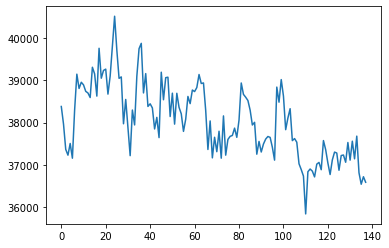

Validation


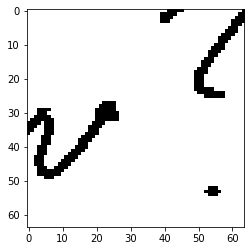

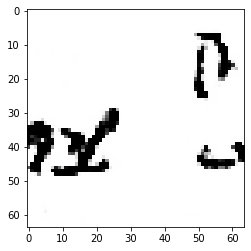

validation loss: 37544.9765625
Random


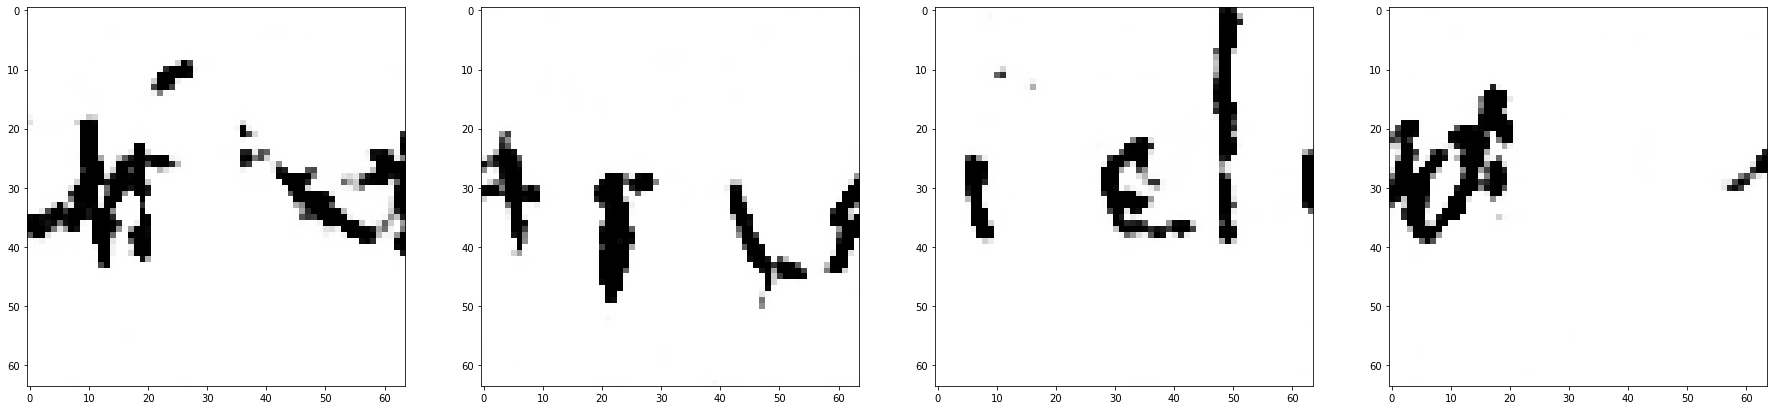

n_iter : 3525/46000, loss = 36547.123281250, time_since: 2916.98
n_iter : 3550/46000, loss = 37312.629375000, time_since: 2940.50
n_iter : 3575/46000, loss = 37604.455937500, time_since: 2958.77
n_iter : 3600/46000, loss = 37760.395781250, time_since: 2981.07
n_iter : 3625/46000, loss = 37467.844062500, time_since: 2999.42
n_iter : 3650/46000, loss = 37760.900625000, time_since: 3021.86
n_iter : 3675/46000, loss = 36899.125468750, time_since: 3040.46
n_iter : 3700/46000, loss = 37408.467187500, time_since: 3062.38
n_iter : 3725/46000, loss = 37253.636562500, time_since: 3080.45
n_iter : 3750/46000, loss = 36911.662031250, time_since: 3102.72


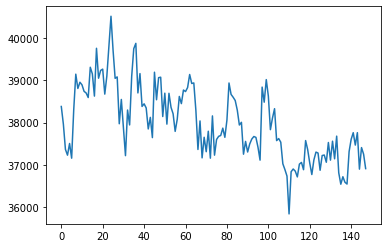

Validation


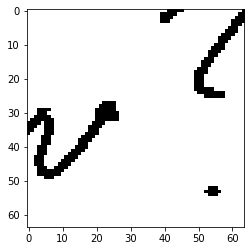

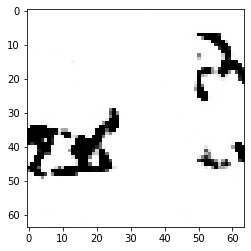

validation loss: 38215.8046875
Random


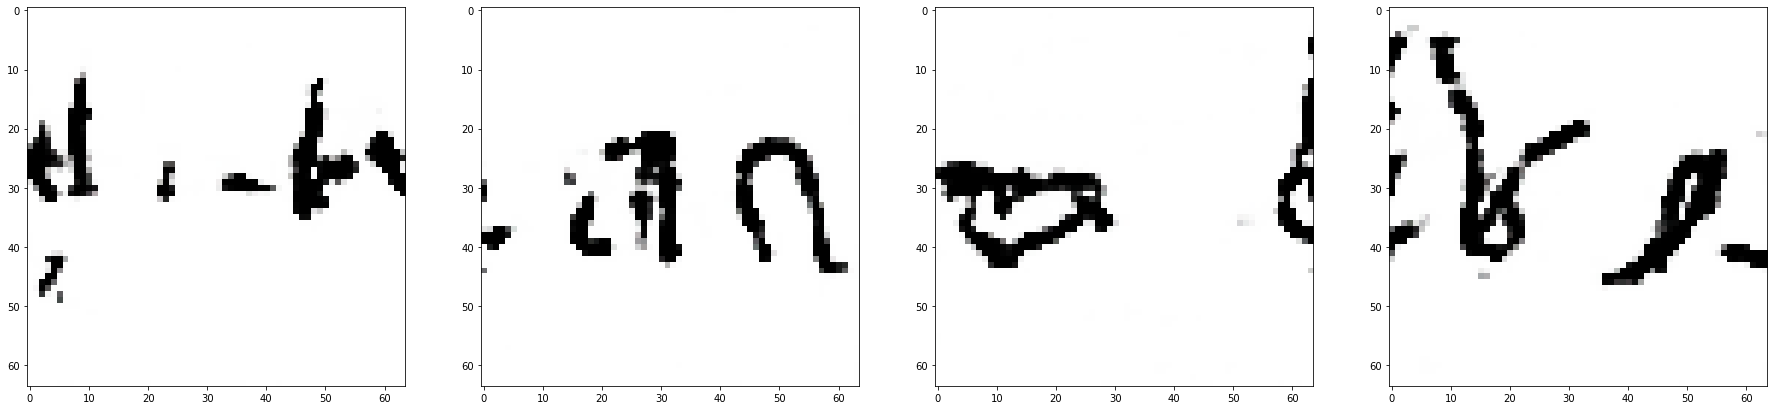

n_iter : 3775/46000, loss = 36638.189218750, time_since: 3124.50
n_iter : 3800/46000, loss = 35833.037031250, time_since: 3145.20
n_iter : 3825/46000, loss = 37327.457187500, time_since: 3167.53
n_iter : 3850/46000, loss = 37103.597500000, time_since: 3188.34
n_iter : 3875/46000, loss = 36534.604218750, time_since: 3211.14
n_iter : 3900/46000, loss = 36551.344843750, time_since: 3232.15
n_iter : 3925/46000, loss = 36452.114843750, time_since: 3254.73
n_iter : 3950/46000, loss = 36519.099531250, time_since: 3275.51
n_iter : 3975/46000, loss = 36811.530312500, time_since: 3297.97
n_iter : 4000/46000, loss = 36440.039843750, time_since: 3318.54


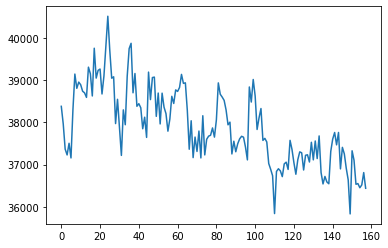

Validation


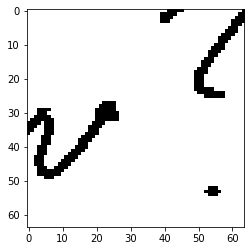

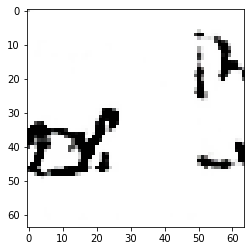

validation loss: 37616.24609375
Random


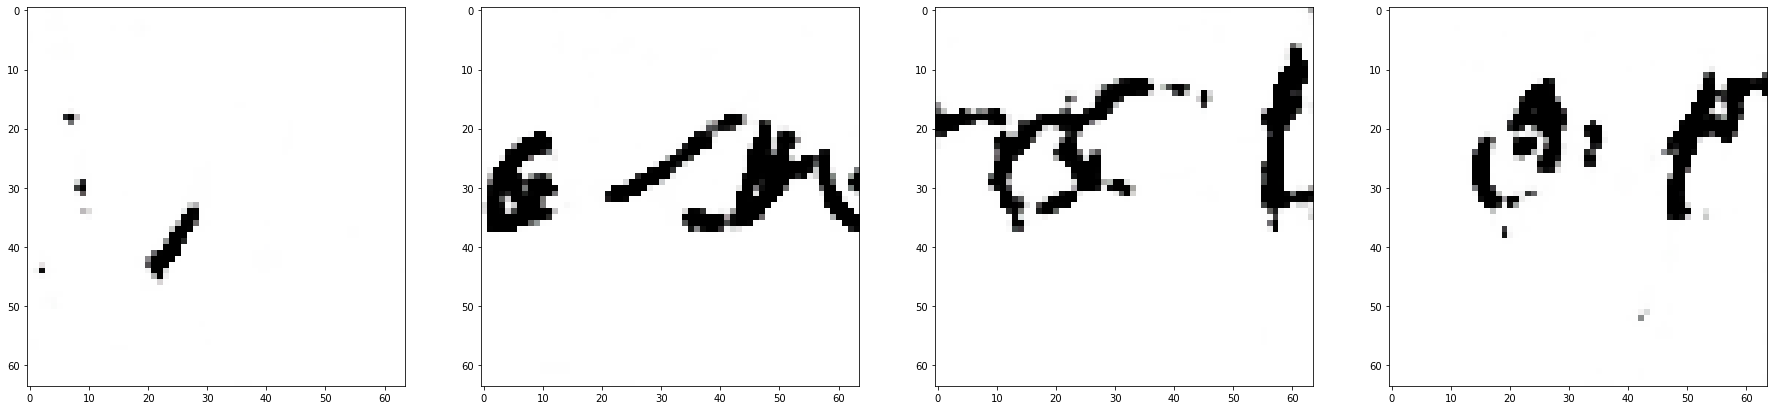

n_iter : 4025/46000, loss = 36777.745937500, time_since: 3341.40
n_iter : 4050/46000, loss = 37203.349062500, time_since: 3363.53
n_iter : 4075/46000, loss = 37932.464375000, time_since: 3382.01
n_iter : 4100/46000, loss = 38756.087968750, time_since: 3404.01
n_iter : 4125/46000, loss = 37714.997656250, time_since: 3422.46
n_iter : 4150/46000, loss = 37480.244375000, time_since: 3444.38
n_iter : 4175/46000, loss = 37499.722031250, time_since: 3462.69
n_iter : 4200/46000, loss = 37004.659531250, time_since: 3485.03
n_iter : 4225/46000, loss = 37301.235781250, time_since: 3502.88
n_iter : 4250/46000, loss = 36541.245468750, time_since: 3525.09


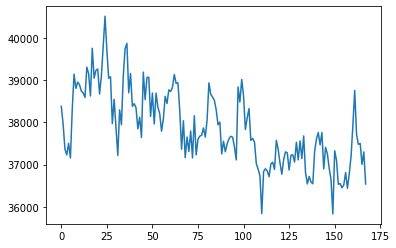

Validation


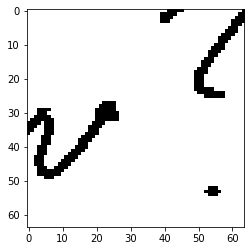

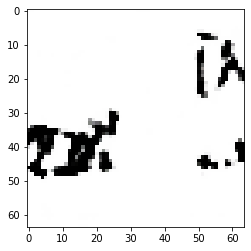

validation loss: 37103.59765625
Random


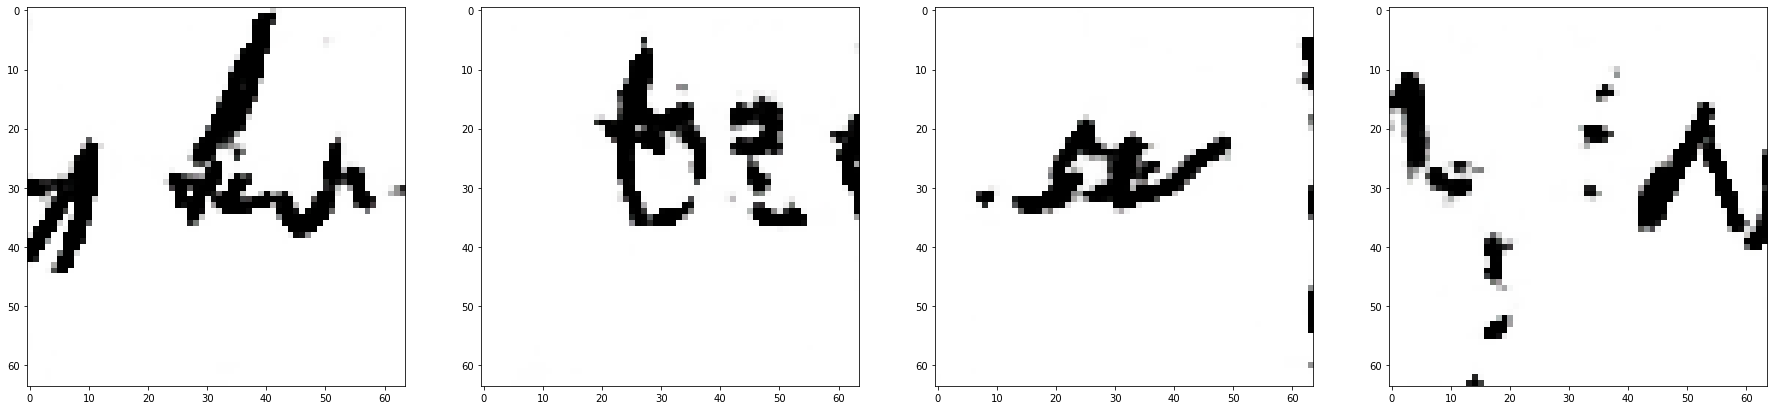

n_iter : 4275/46000, loss = 37637.248750000, time_since: 3543.40
n_iter : 4300/46000, loss = 36622.727187500, time_since: 3565.63
n_iter : 4325/46000, loss = 36574.222656250, time_since: 3587.20
n_iter : 4350/46000, loss = 35878.130312500, time_since: 3605.63
n_iter : 4375/46000, loss = 36311.997812500, time_since: 3627.42
n_iter : 4400/46000, loss = 36564.667500000, time_since: 3646.31
n_iter : 4425/46000, loss = 36346.256875000, time_since: 3668.63
n_iter : 4450/46000, loss = 36310.946093750, time_since: 3686.64
n_iter : 4475/46000, loss = 36170.131406250, time_since: 3708.81
n_iter : 4500/46000, loss = 35920.576875000, time_since: 3726.91


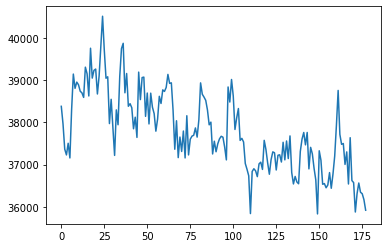

Validation


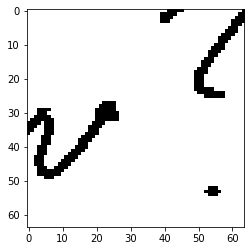

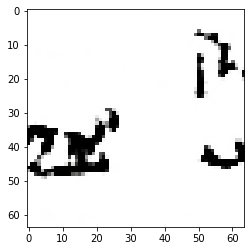

validation loss: 36156.6640625
Random


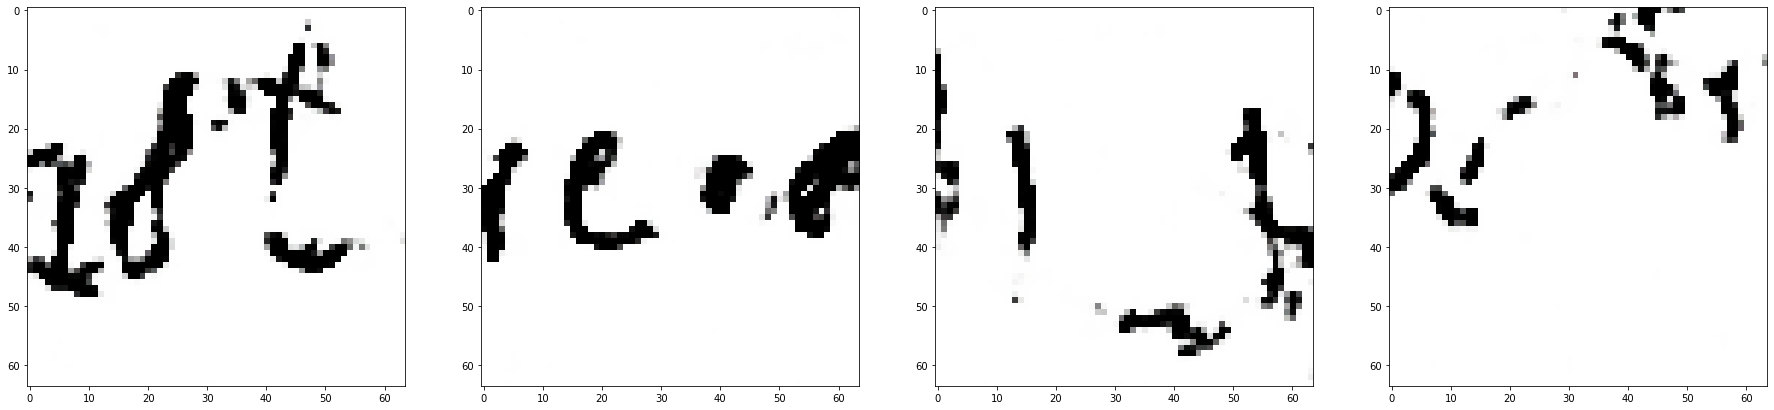

n_iter : 4525/46000, loss = 36213.520937500, time_since: 3749.29
n_iter : 4550/46000, loss = 36806.320781250, time_since: 3767.65
n_iter : 4575/46000, loss = 36489.035781250, time_since: 3789.65
n_iter : 4600/46000, loss = 36806.124062500, time_since: 3812.07
n_iter : 4625/46000, loss = 36535.712968750, time_since: 3830.28
n_iter : 4650/46000, loss = 36351.485312500, time_since: 3852.96
n_iter : 4675/46000, loss = 36352.823593750, time_since: 3870.87
n_iter : 4700/46000, loss = 36382.051250000, time_since: 3893.48
n_iter : 4725/46000, loss = 36286.821562500, time_since: 3911.79
n_iter : 4750/46000, loss = 36084.108437500, time_since: 3934.03


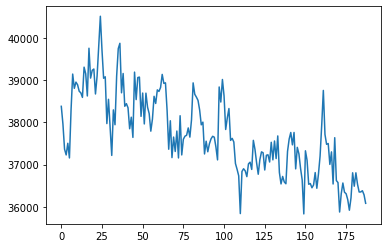

Validation


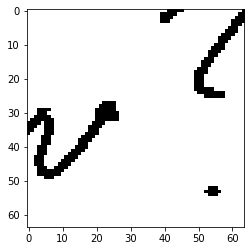

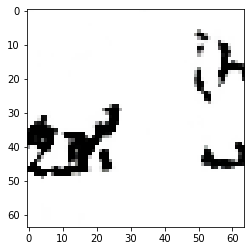

validation loss: 34240.4609375
Random


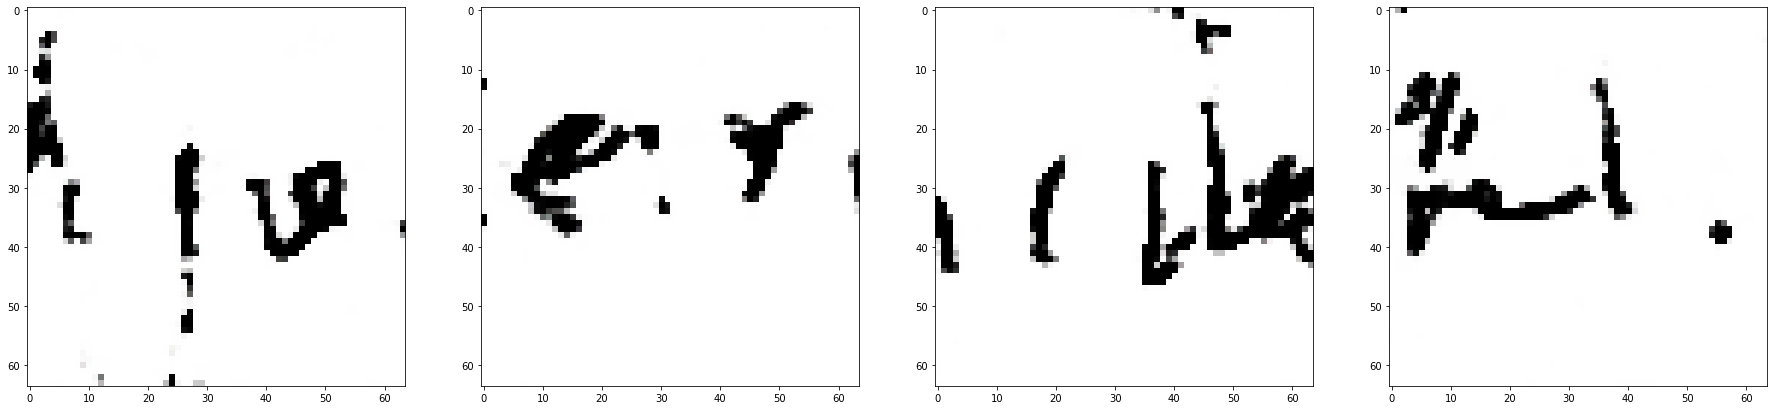

n_iter : 4775/46000, loss = 36055.245156250, time_since: 3952.46
n_iter : 4800/46000, loss = 35648.301406250, time_since: 3975.59
n_iter : 4825/46000, loss = 36517.038281250, time_since: 3995.50
n_iter : 4850/46000, loss = 36855.971406250, time_since: 4018.88
n_iter : 4875/46000, loss = 36254.233281250, time_since: 4038.92
n_iter : 4900/46000, loss = 36665.951250000, time_since: 4063.55
n_iter : 4925/46000, loss = 36306.096875000, time_since: 4087.95
n_iter : 4950/46000, loss = 36023.576718750, time_since: 4109.12
n_iter : 4975/46000, loss = 36085.211250000, time_since: 4131.97
n_iter : 5000/46000, loss = 35907.347968750, time_since: 4153.26


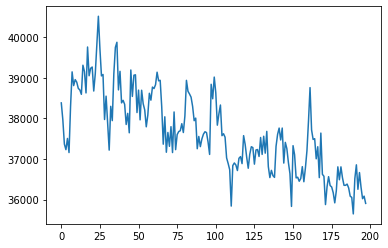

Validation


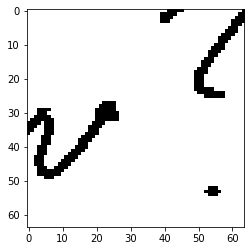

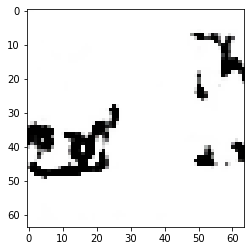

validation loss: 34961.92578125
Random


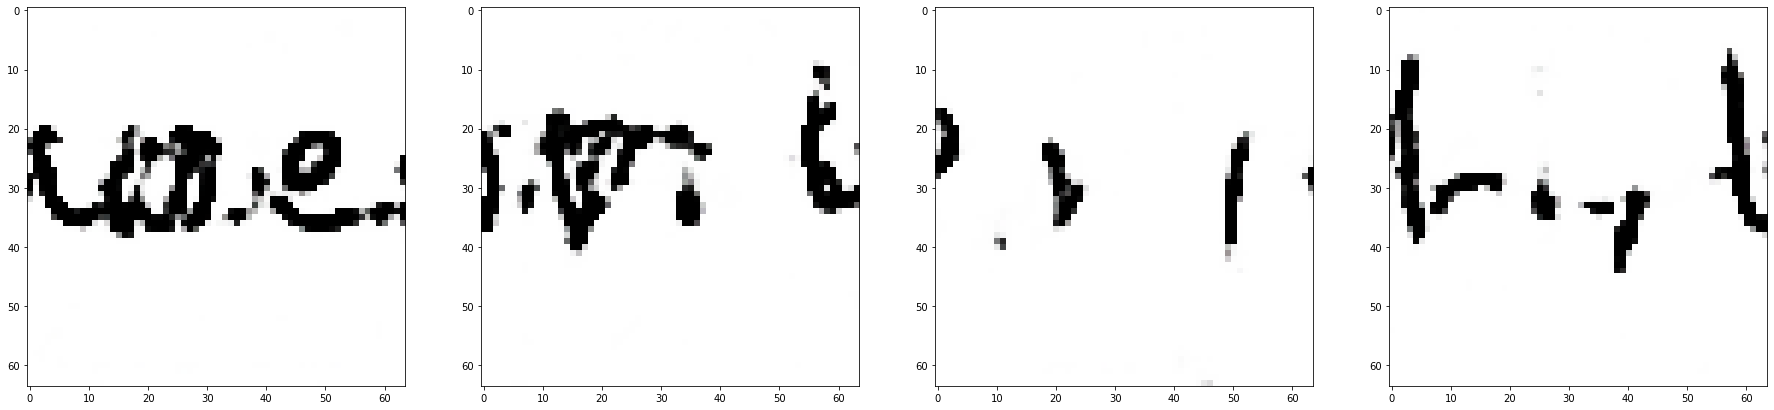

n_iter : 5025/46000, loss = 36358.878437500, time_since: 4175.58
n_iter : 5050/46000, loss = 36008.577343750, time_since: 4194.90
n_iter : 5075/46000, loss = 35852.174375000, time_since: 4216.38
n_iter : 5100/46000, loss = 36852.501718750, time_since: 4235.43
n_iter : 5125/46000, loss = 36358.343125000, time_since: 4256.94
n_iter : 5150/46000, loss = 36850.007343750, time_since: 4276.20
n_iter : 5175/46000, loss = 36250.979375000, time_since: 4298.20
n_iter : 5200/46000, loss = 36426.864531250, time_since: 4320.52
n_iter : 5225/46000, loss = 36071.986406250, time_since: 4338.98
n_iter : 5250/46000, loss = 35738.411406250, time_since: 4360.77


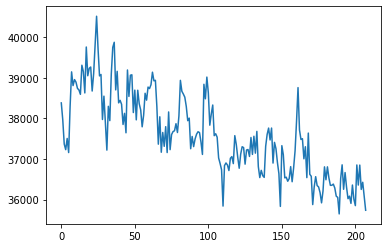

Validation


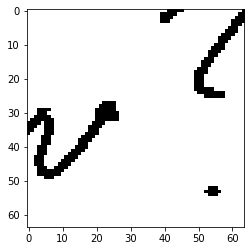

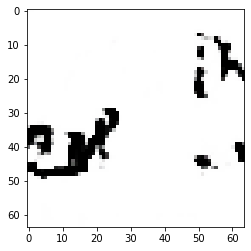

validation loss: 36827.33203125
Random


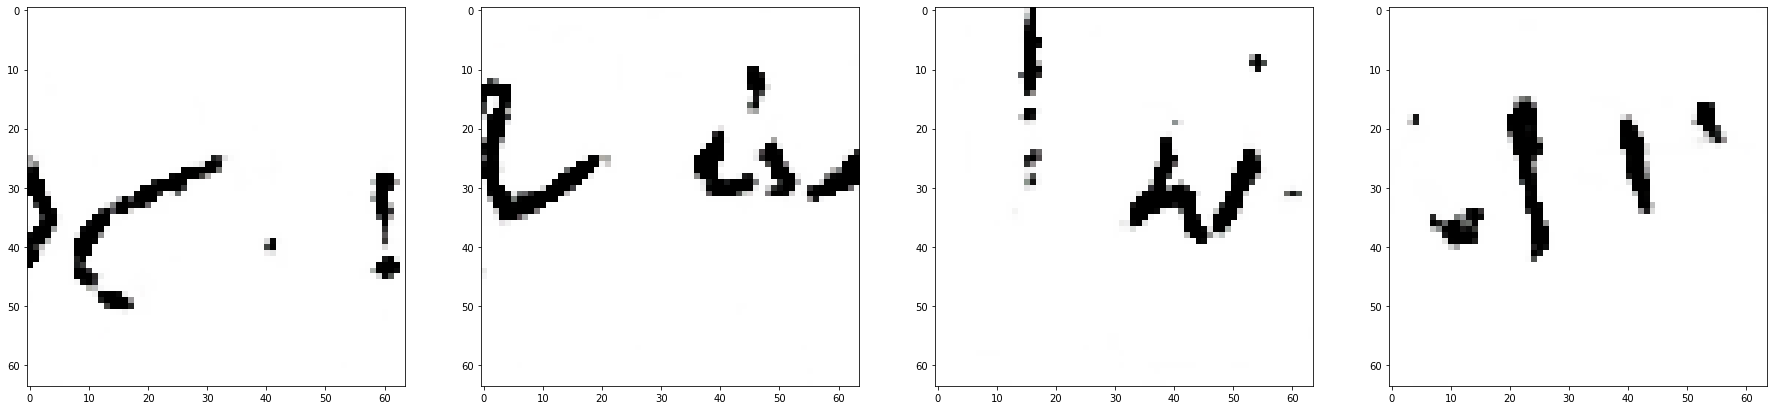

n_iter : 5275/46000, loss = 35340.190625000, time_since: 4379.57
n_iter : 5300/46000, loss = 35907.077500000, time_since: 4401.95
n_iter : 5325/46000, loss = 37231.784687500, time_since: 4422.09
n_iter : 5350/46000, loss = 36503.675468750, time_since: 4446.08
n_iter : 5375/46000, loss = 37533.215937500, time_since: 4466.76
n_iter : 5400/46000, loss = 37629.962500000, time_since: 4490.45
n_iter : 5425/46000, loss = 37316.745625000, time_since: 4510.30
n_iter : 5450/46000, loss = 36237.269375000, time_since: 4534.05
n_iter : 5475/46000, loss = 36241.063750000, time_since: 4557.62
n_iter : 5500/46000, loss = 36319.705468750, time_since: 4577.51


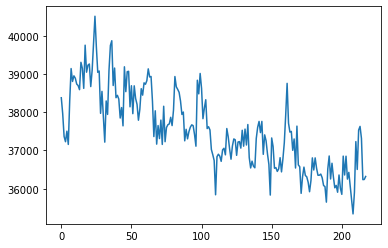

Validation


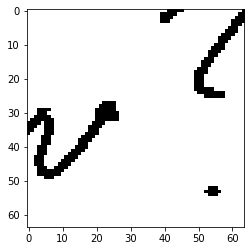

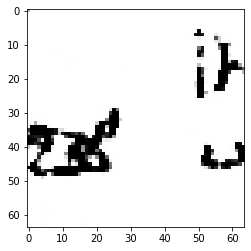

validation loss: 35721.1796875
Random


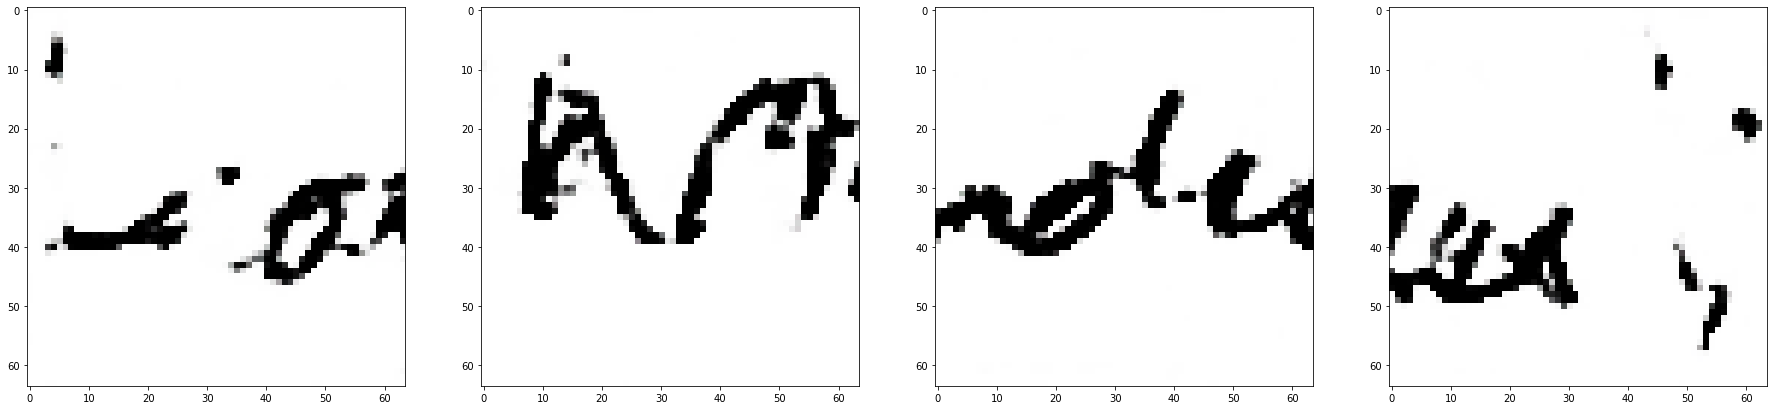

n_iter : 5525/46000, loss = 35499.035937500, time_since: 4600.93
n_iter : 5550/46000, loss = 35446.327656250, time_since: 4619.26
n_iter : 5575/46000, loss = 35400.480937500, time_since: 4640.89
n_iter : 5600/46000, loss = 35726.025156250, time_since: 4659.16
n_iter : 5625/46000, loss = 35647.799687500, time_since: 4681.33
n_iter : 5650/46000, loss = 35793.513750000, time_since: 4699.63
n_iter : 5675/46000, loss = 35431.880937500, time_since: 4721.98
n_iter : 5700/46000, loss = 35996.348906250, time_since: 4739.87
n_iter : 5725/46000, loss = 36310.108437500, time_since: 4762.14
n_iter : 5750/46000, loss = 36206.873593750, time_since: 4784.40


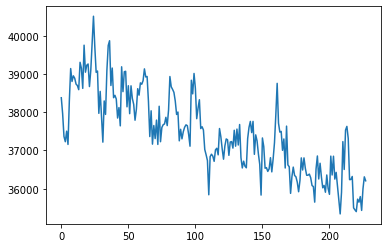

Validation


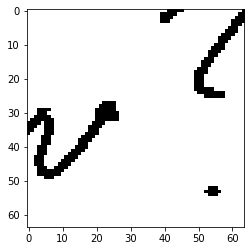

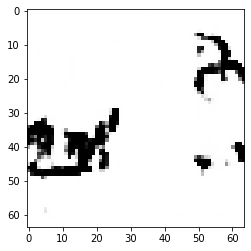

validation loss: 35498.37890625
Random


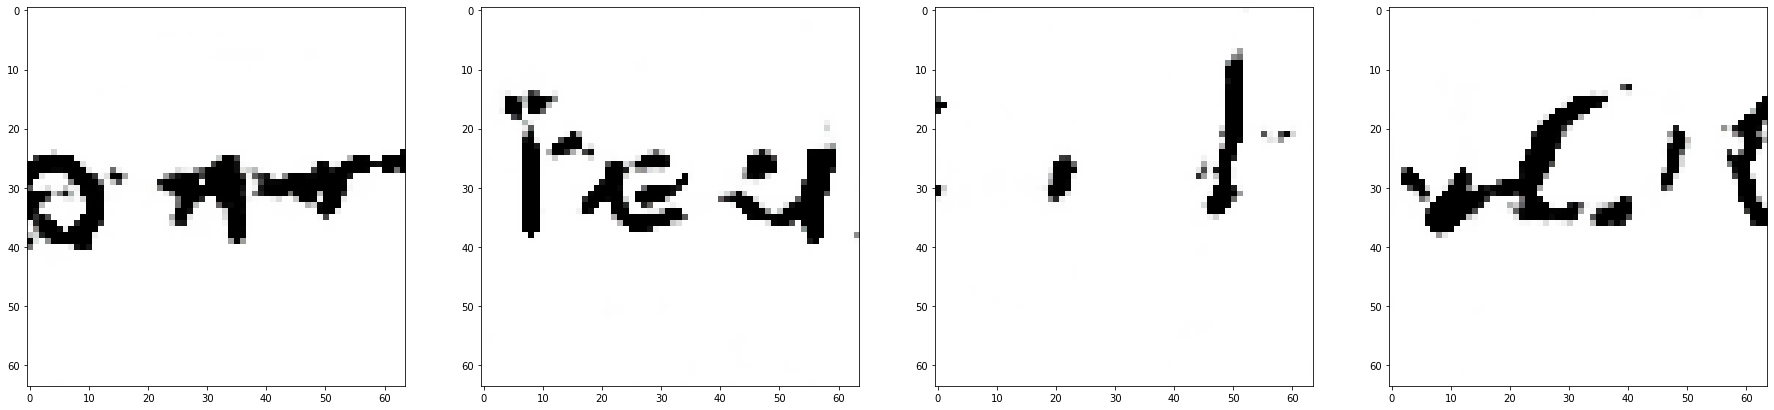

n_iter : 5775/46000, loss = 35857.293750000, time_since: 4802.67
n_iter : 5800/46000, loss = 36228.750000000, time_since: 4825.13
n_iter : 5825/46000, loss = 36159.214687500, time_since: 4844.77
n_iter : 5850/46000, loss = 36290.298906250, time_since: 4868.31
n_iter : 5875/46000, loss = 35740.963906250, time_since: 4887.82
n_iter : 5900/46000, loss = 36795.707031250, time_since: 4911.63
n_iter : 5925/46000, loss = 36178.402343750, time_since: 4931.32
n_iter : 5950/46000, loss = 36018.652812500, time_since: 4955.25
n_iter : 5975/46000, loss = 36022.102656250, time_since: 4975.08
n_iter : 6000/46000, loss = 35446.999218750, time_since: 4999.07


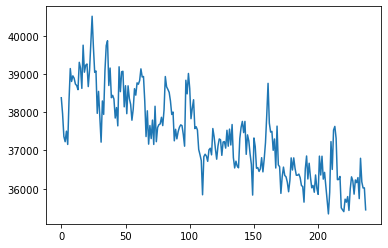

Validation


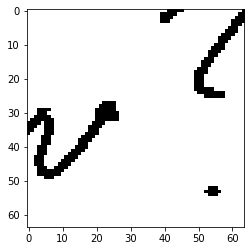

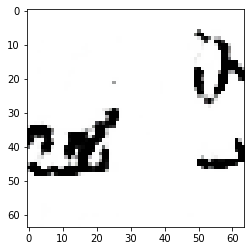

validation loss: 37516.98828125
Random


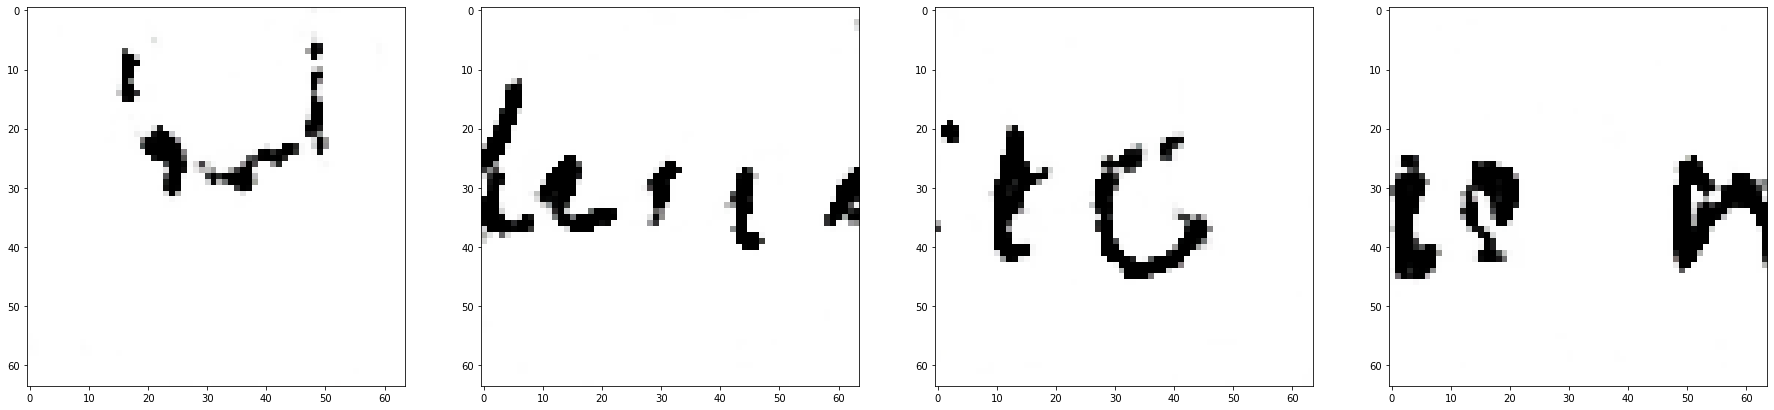

n_iter : 6025/46000, loss = 36032.304687500, time_since: 5019.35
n_iter : 6050/46000, loss = 35888.662656250, time_since: 5041.89
n_iter : 6075/46000, loss = 36158.470468750, time_since: 5063.48
n_iter : 6100/46000, loss = 35982.780312500, time_since: 5082.57
n_iter : 6125/46000, loss = 35780.212500000, time_since: 5104.42
n_iter : 6150/46000, loss = 35467.087187500, time_since: 5123.38
n_iter : 6175/46000, loss = 36130.840312500, time_since: 5144.95
n_iter : 6200/46000, loss = 35471.637187500, time_since: 5164.00
n_iter : 6225/46000, loss = 35172.302968750, time_since: 5185.61
n_iter : 6250/46000, loss = 35720.769218750, time_since: 5205.18


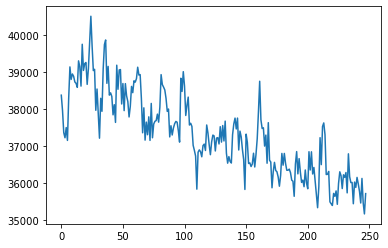

Validation


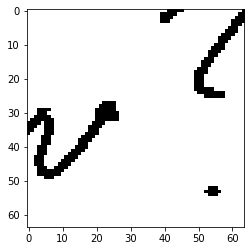

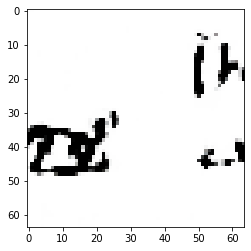

validation loss: 39637.90625
Random


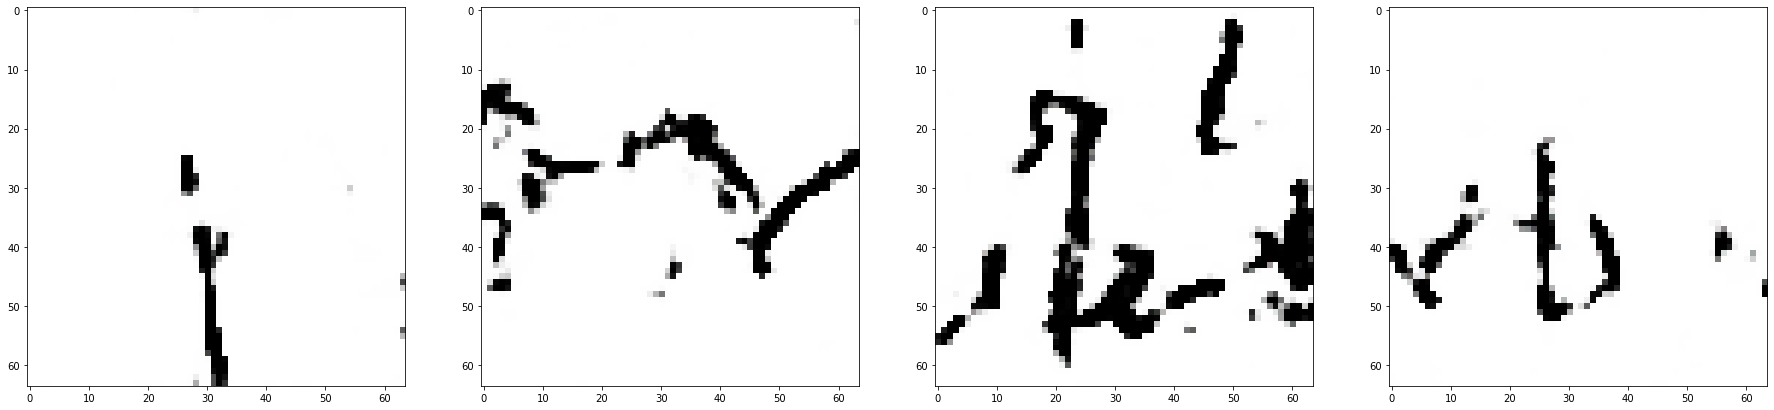

n_iter : 6275/46000, loss = 35287.659843750, time_since: 5227.75
n_iter : 6300/46000, loss = 35754.506250000, time_since: 5249.09
n_iter : 6325/46000, loss = 35213.878906250, time_since: 5272.05
n_iter : 6350/46000, loss = 35542.546093750, time_since: 5295.58
n_iter : 6375/46000, loss = 35188.357500000, time_since: 5315.44
n_iter : 6400/46000, loss = 35483.577968750, time_since: 5339.45
n_iter : 6425/46000, loss = 35550.722656250, time_since: 5359.57
n_iter : 6450/46000, loss = 35152.788281250, time_since: 5385.02
n_iter : 6475/46000, loss = 36037.888593750, time_since: 5404.92
n_iter : 6500/46000, loss = 35634.173750000, time_since: 5428.49


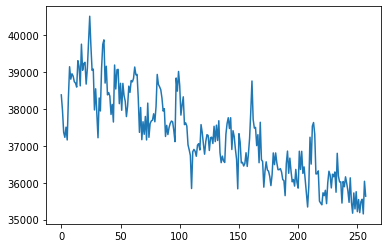

Validation


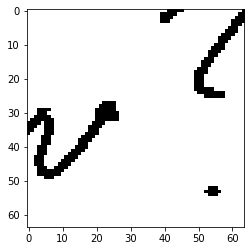

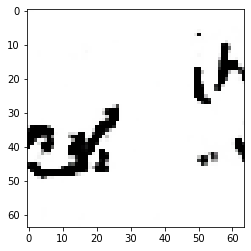

validation loss: 39159.08203125
Random


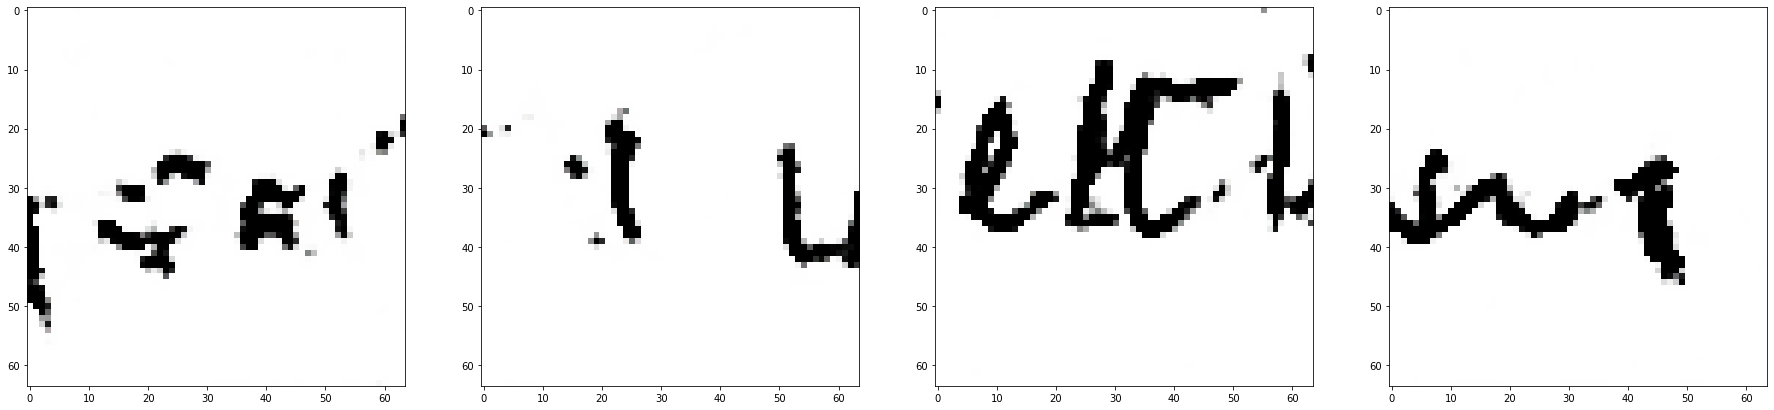

n_iter : 6525/46000, loss = 35690.431406250, time_since: 5448.45
n_iter : 6550/46000, loss = 35740.433125000, time_since: 5470.98
n_iter : 6575/46000, loss = 35821.258906250, time_since: 5489.03
n_iter : 6600/46000, loss = 35607.036718750, time_since: 5511.01
n_iter : 6625/46000, loss = 35580.658750000, time_since: 5532.98
n_iter : 6650/46000, loss = 35510.755468750, time_since: 5551.38
n_iter : 6675/46000, loss = 35245.632500000, time_since: 5573.45
n_iter : 6700/46000, loss = 35473.486718750, time_since: 5592.09
n_iter : 6725/46000, loss = 35464.862343750, time_since: 5614.36
n_iter : 6750/46000, loss = 35414.203515625, time_since: 5632.48


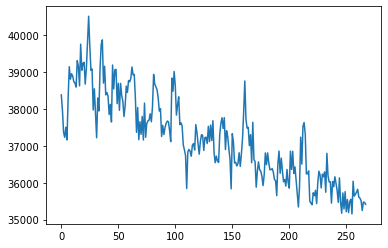

Validation


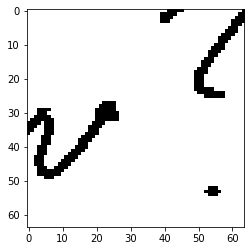

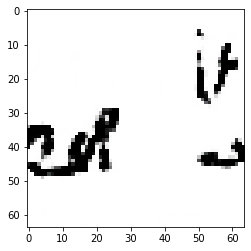

validation loss: 35531.234375
Random


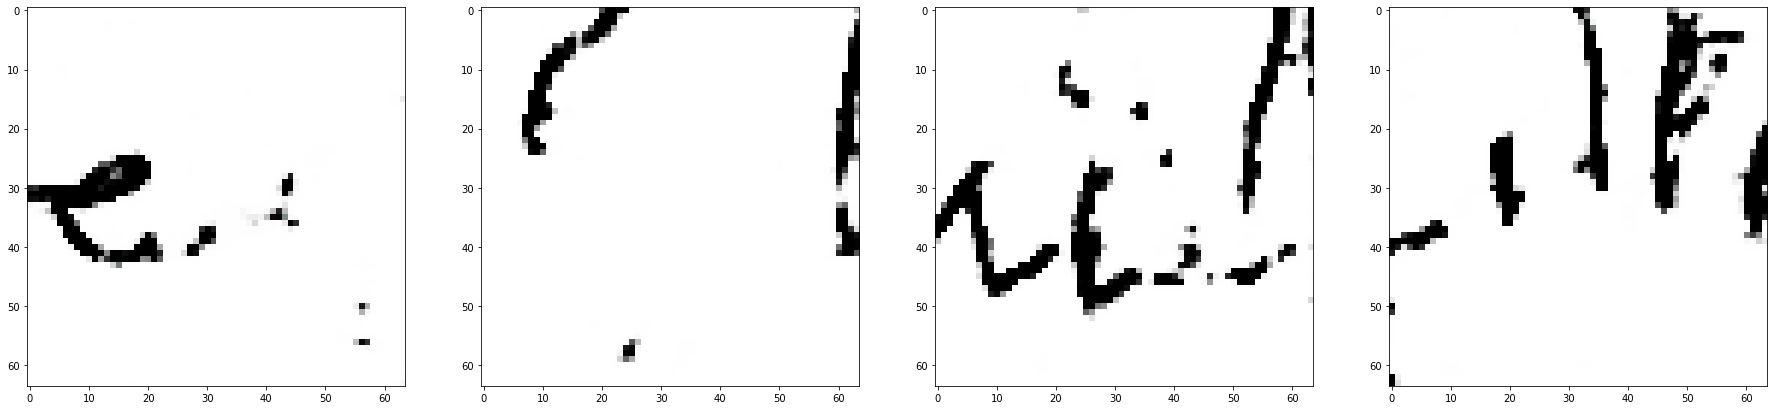

n_iter : 6775/46000, loss = 35359.642187500, time_since: 5654.39
n_iter : 6800/46000, loss = 35476.867031250, time_since: 5673.57
n_iter : 6825/46000, loss = 35665.062031250, time_since: 5695.61
n_iter : 6850/46000, loss = 35084.095625000, time_since: 5713.98
n_iter : 6875/46000, loss = 34446.607500000, time_since: 5735.74
n_iter : 6900/46000, loss = 35277.818281250, time_since: 5758.15
n_iter : 6925/46000, loss = 35633.580312500, time_since: 5776.44
n_iter : 6950/46000, loss = 34993.648750000, time_since: 5798.59
n_iter : 6975/46000, loss = 34955.527343750, time_since: 5817.22
n_iter : 7000/46000, loss = 34597.866406250, time_since: 5839.27


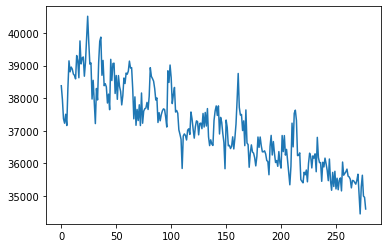

Validation


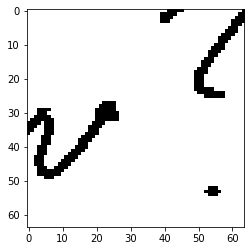

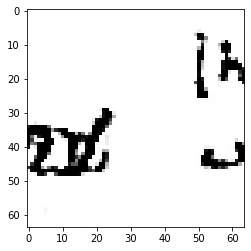

validation loss: 37635.20703125
Random


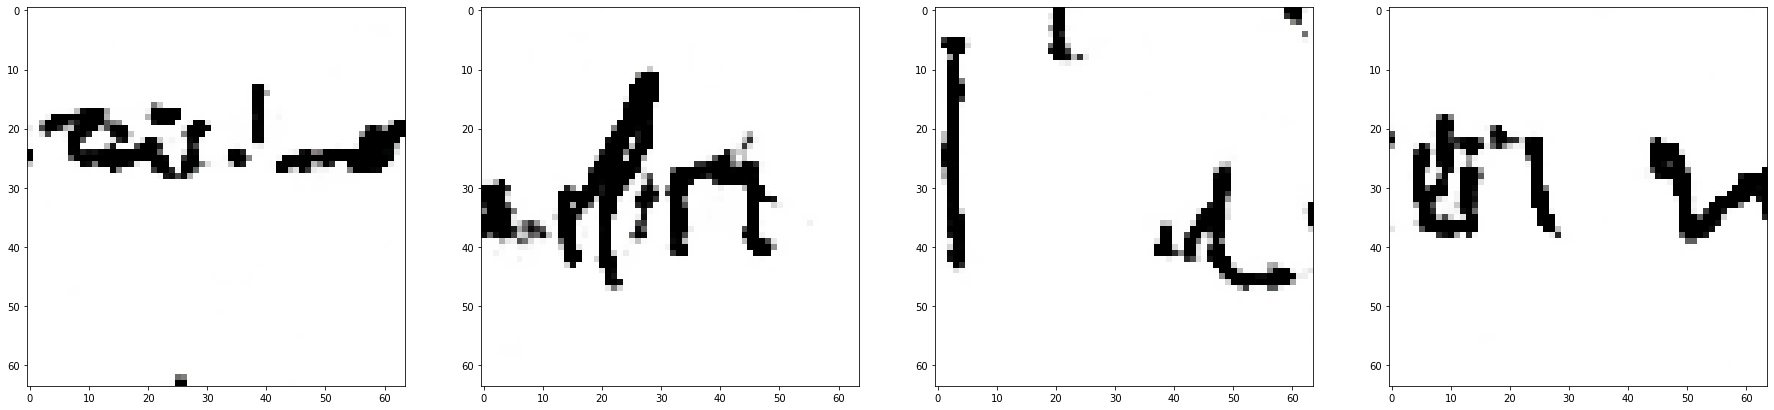

n_iter : 7025/46000, loss = 34459.751718750, time_since: 5857.87
n_iter : 7050/46000, loss = 34834.130703125, time_since: 5880.17
n_iter : 7075/46000, loss = 35652.982656250, time_since: 5898.87
n_iter : 7100/46000, loss = 35594.649218750, time_since: 5921.44
n_iter : 7125/46000, loss = 35957.859375000, time_since: 5939.48
n_iter : 7150/46000, loss = 34947.433281250, time_since: 5961.54
n_iter : 7175/46000, loss = 35350.346875000, time_since: 5979.49
n_iter : 7200/46000, loss = 34942.689687500, time_since: 6002.61
n_iter : 7225/46000, loss = 35851.870781250, time_since: 6024.36
n_iter : 7250/46000, loss = 35336.394843750, time_since: 6043.16


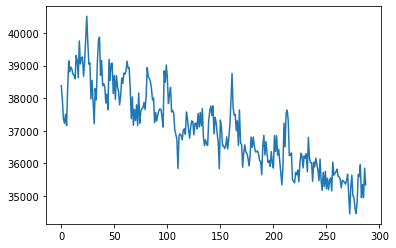

Validation


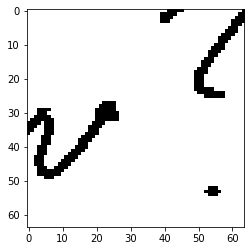

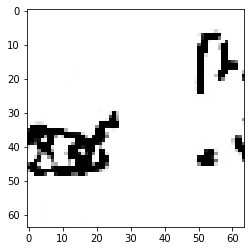

validation loss: 39113.83984375
Random


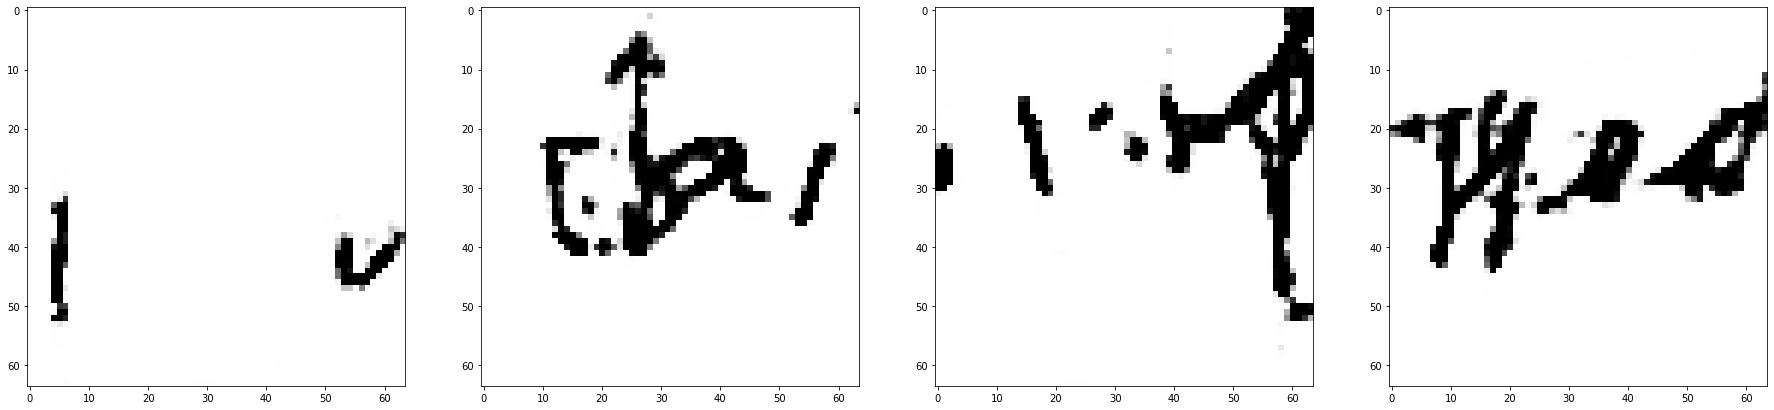

n_iter : 7275/46000, loss = 35245.233906250, time_since: 6065.57
n_iter : 7300/46000, loss = 35754.920000000, time_since: 6086.43
n_iter : 7325/46000, loss = 35616.419218750, time_since: 6109.91
n_iter : 7350/46000, loss = 35823.214375000, time_since: 6130.06
n_iter : 7375/46000, loss = 35204.119218750, time_since: 6152.76
n_iter : 7400/46000, loss = 35093.875781250, time_since: 6173.84
n_iter : 7425/46000, loss = 35551.131875000, time_since: 6196.17
n_iter : 7450/46000, loss = 35195.207812500, time_since: 6218.31
n_iter : 7475/46000, loss = 34954.012187500, time_since: 6241.57
n_iter : 7500/46000, loss = 35301.140000000, time_since: 6265.16


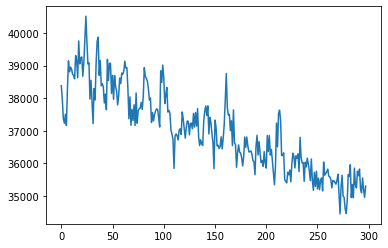

Validation


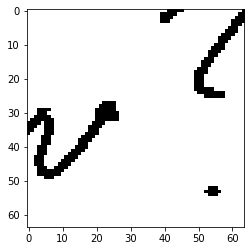

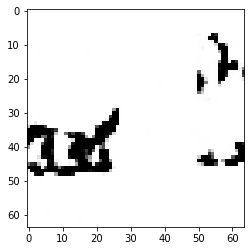

validation loss: 43044.32421875
Random


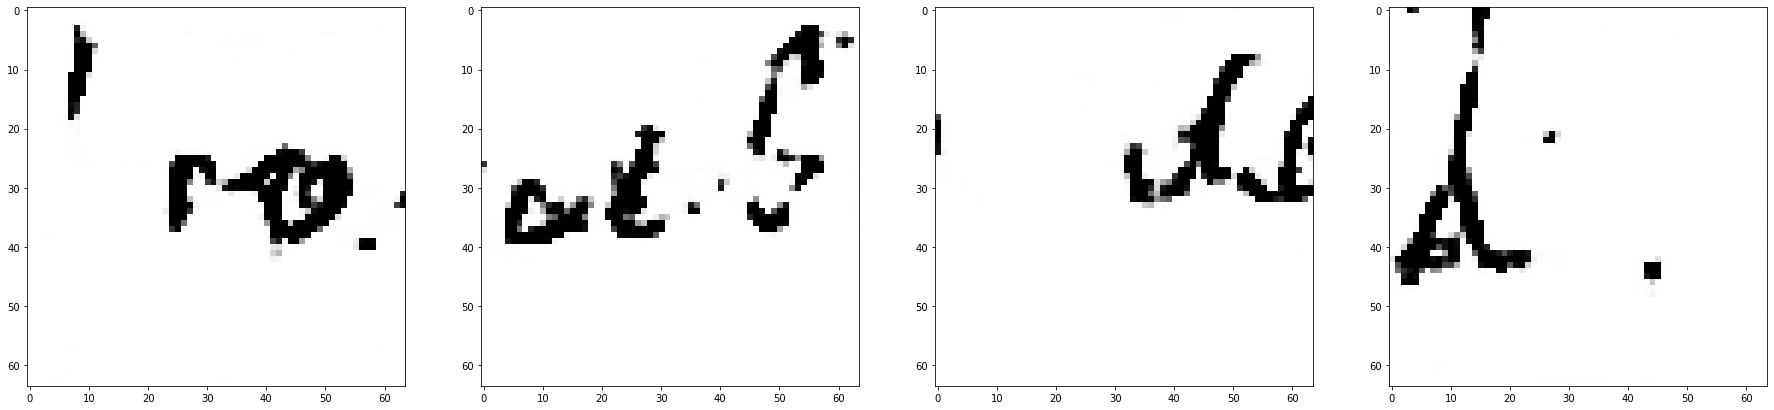

n_iter : 7525/46000, loss = 35516.367656250, time_since: 6284.81
n_iter : 7550/46000, loss = 35235.713281250, time_since: 6308.45
n_iter : 7575/46000, loss = 34883.121250000, time_since: 6326.96
n_iter : 7600/46000, loss = 34876.631875000, time_since: 6349.06
n_iter : 7625/46000, loss = 34951.049218750, time_since: 6367.29
n_iter : 7650/46000, loss = 34682.630000000, time_since: 6388.98
n_iter : 7675/46000, loss = 35128.610468750, time_since: 6407.33
n_iter : 7700/46000, loss = 35153.832031250, time_since: 6429.23
n_iter : 7725/46000, loss = 35121.536406250, time_since: 6447.87
n_iter : 7750/46000, loss = 34700.533359375, time_since: 6470.00


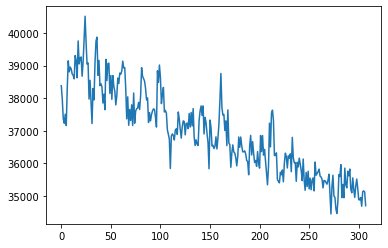

Validation


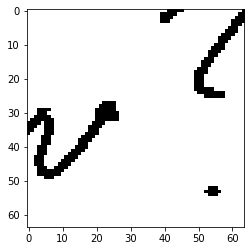

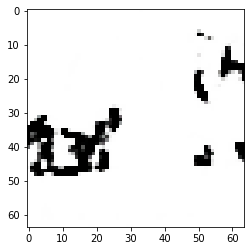

validation loss: 39339.375
Random


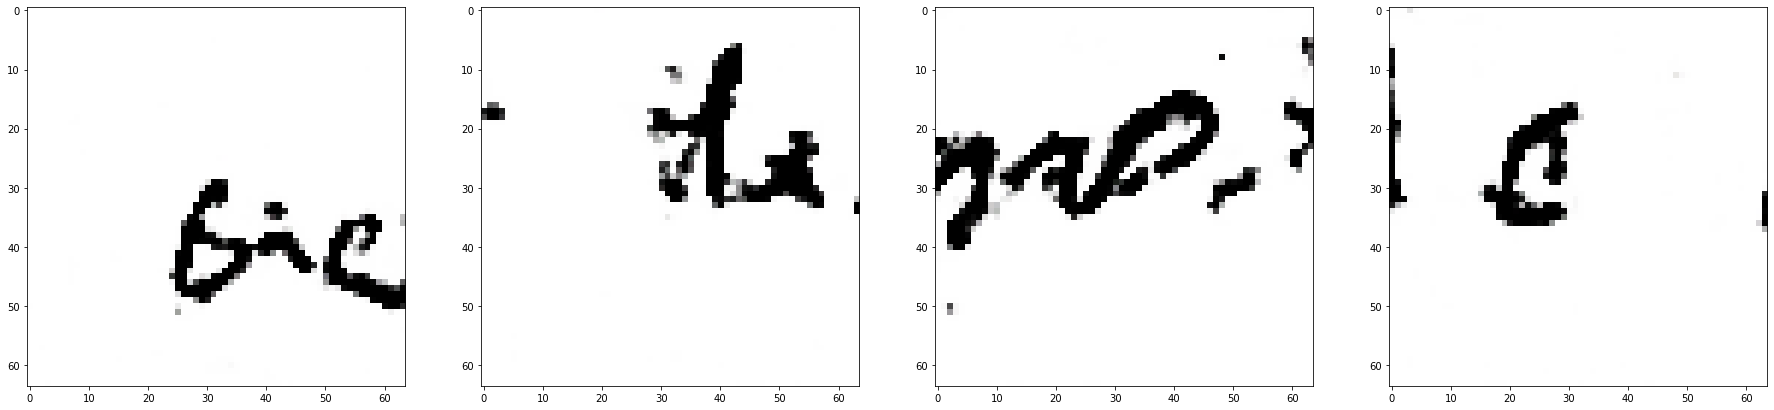

n_iter : 7775/46000, loss = 35269.543593750, time_since: 6491.91
n_iter : 7800/46000, loss = 34988.590312500, time_since: 6512.22
n_iter : 7825/46000, loss = 34801.933125000, time_since: 6535.88
n_iter : 7850/46000, loss = 35197.062656250, time_since: 6556.31
n_iter : 7875/46000, loss = 35406.663593750, time_since: 6580.12
n_iter : 7900/46000, loss = 35024.921250000, time_since: 6600.91
n_iter : 7925/46000, loss = 34863.887500000, time_since: 6624.31
n_iter : 7950/46000, loss = 35378.031406250, time_since: 6644.33
n_iter : 7975/46000, loss = 35916.352031250, time_since: 6667.83
n_iter : 8000/46000, loss = 35739.997968750, time_since: 6687.50


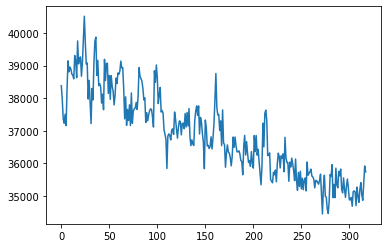

Validation


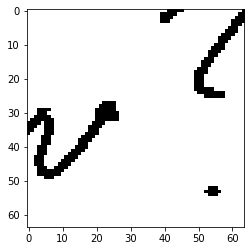

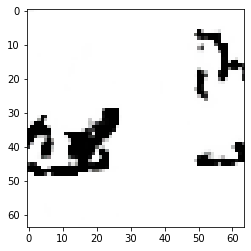

validation loss: 35545.3984375
Random


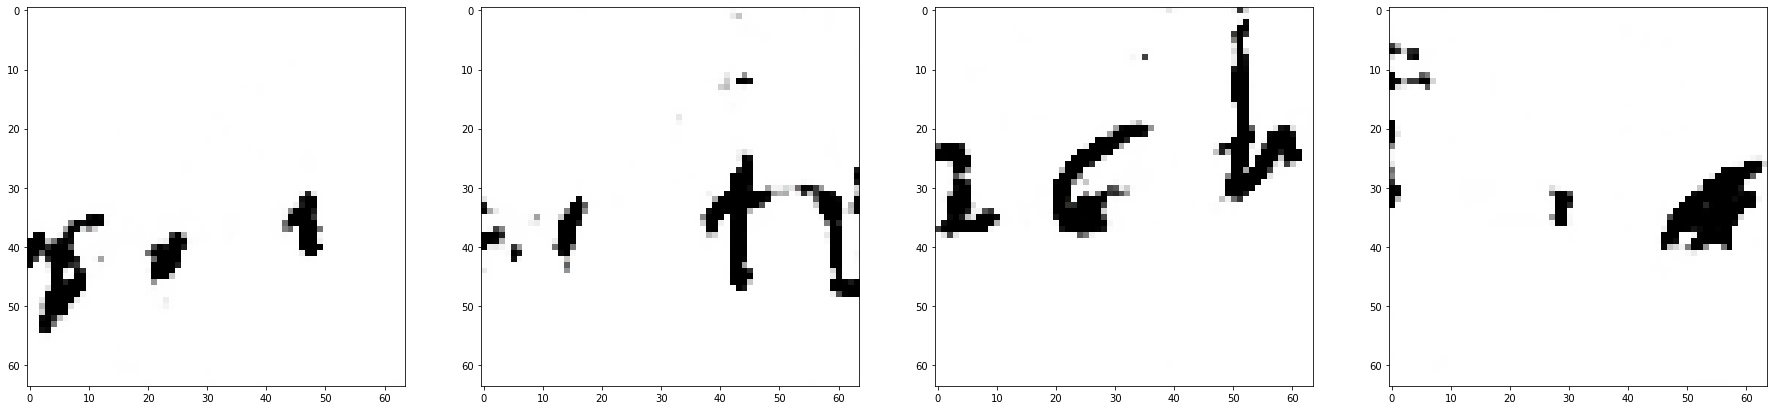

n_iter : 8025/46000, loss = 35376.811093750, time_since: 6709.89
n_iter : 8050/46000, loss = 35657.961250000, time_since: 6732.71
n_iter : 8075/46000, loss = 35387.222343750, time_since: 6750.86
n_iter : 8100/46000, loss = 35124.815156250, time_since: 6772.65
n_iter : 8125/46000, loss = 35783.401875000, time_since: 6790.72
n_iter : 8150/46000, loss = 35378.881250000, time_since: 6812.72
n_iter : 8175/46000, loss = 36001.116406250, time_since: 6831.07
n_iter : 8200/46000, loss = 35880.970625000, time_since: 6853.39
n_iter : 8225/46000, loss = 35169.744062500, time_since: 6871.58
n_iter : 8250/46000, loss = 34676.062343750, time_since: 6893.78


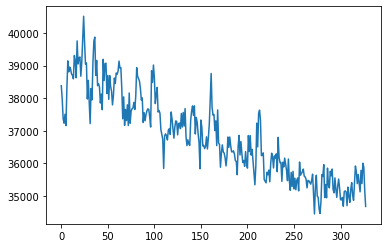

Validation


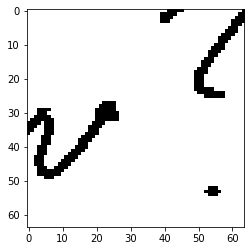

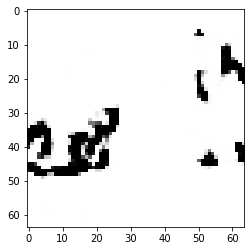

validation loss: 36696.4921875
Random


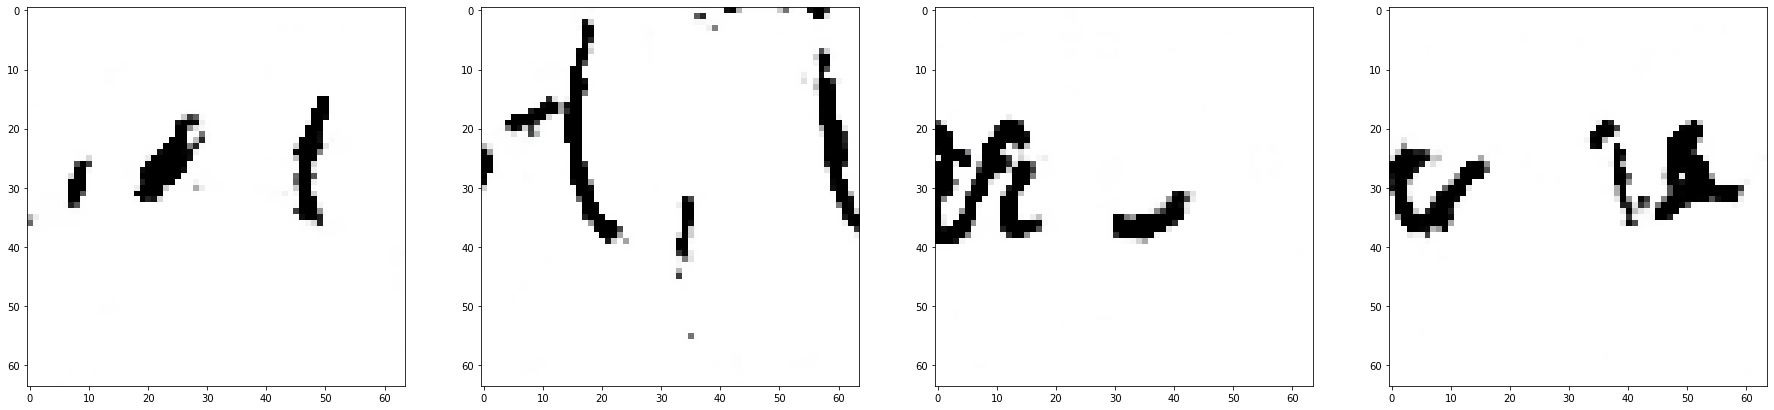

n_iter : 8275/46000, loss = 34595.107734375, time_since: 6911.84
n_iter : 8300/46000, loss = 34451.890703125, time_since: 6935.19
n_iter : 8325/46000, loss = 34880.403593750, time_since: 6954.32
n_iter : 8350/46000, loss = 34796.256406250, time_since: 6977.83
n_iter : 8375/46000, loss = 34773.243906250, time_since: 7000.30
n_iter : 8400/46000, loss = 34994.321562500, time_since: 7021.86
n_iter : 8425/46000, loss = 34559.339062500, time_since: 7044.12
n_iter : 8450/46000, loss = 34705.359218750, time_since: 7064.79
n_iter : 8475/46000, loss = 34993.997500000, time_since: 7087.49
n_iter : 8500/46000, loss = 34197.684218750, time_since: 7108.26


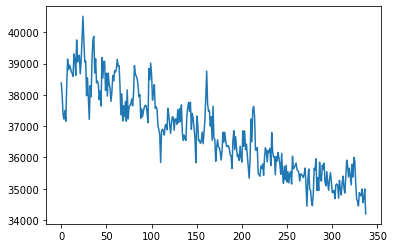

Validation


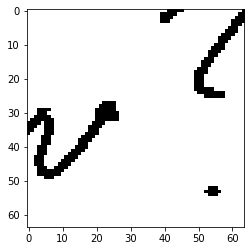

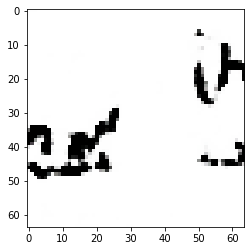

validation loss: 35980.87890625
Random


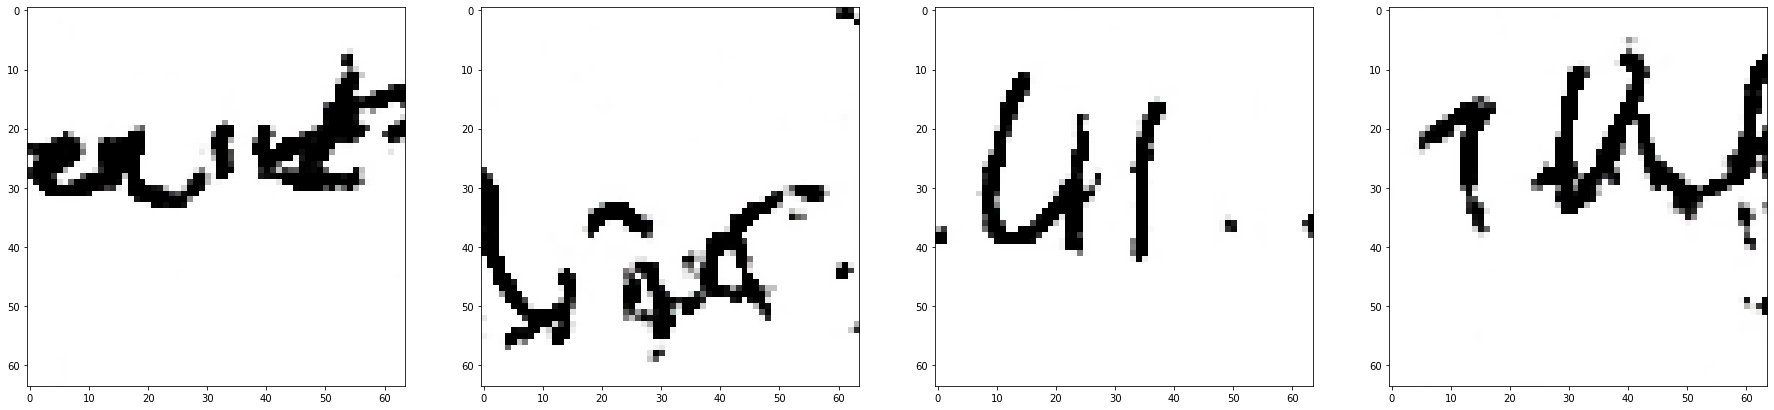

n_iter : 8525/46000, loss = 34448.521250000, time_since: 7130.43
n_iter : 8550/46000, loss = 34651.421875000, time_since: 7148.74
n_iter : 8575/46000, loss = 34490.796796875, time_since: 7170.29
n_iter : 8600/46000, loss = 34313.651328125, time_since: 7188.87
n_iter : 8625/46000, loss = 34532.732031250, time_since: 7210.67
n_iter : 8650/46000, loss = 34140.133203125, time_since: 7232.88
n_iter : 8675/46000, loss = 34007.478359375, time_since: 7250.97
n_iter : 8700/46000, loss = 33893.597343750, time_since: 7273.47
n_iter : 8725/46000, loss = 34385.230000000, time_since: 7291.35
n_iter : 8750/46000, loss = 33909.709687500, time_since: 7313.86


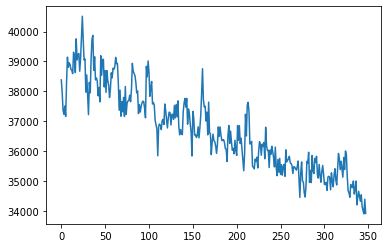

Validation


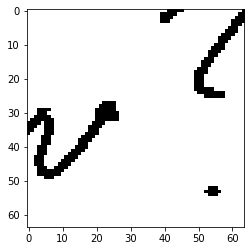

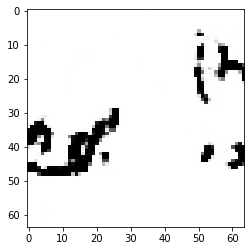

validation loss: 34203.18359375
Random


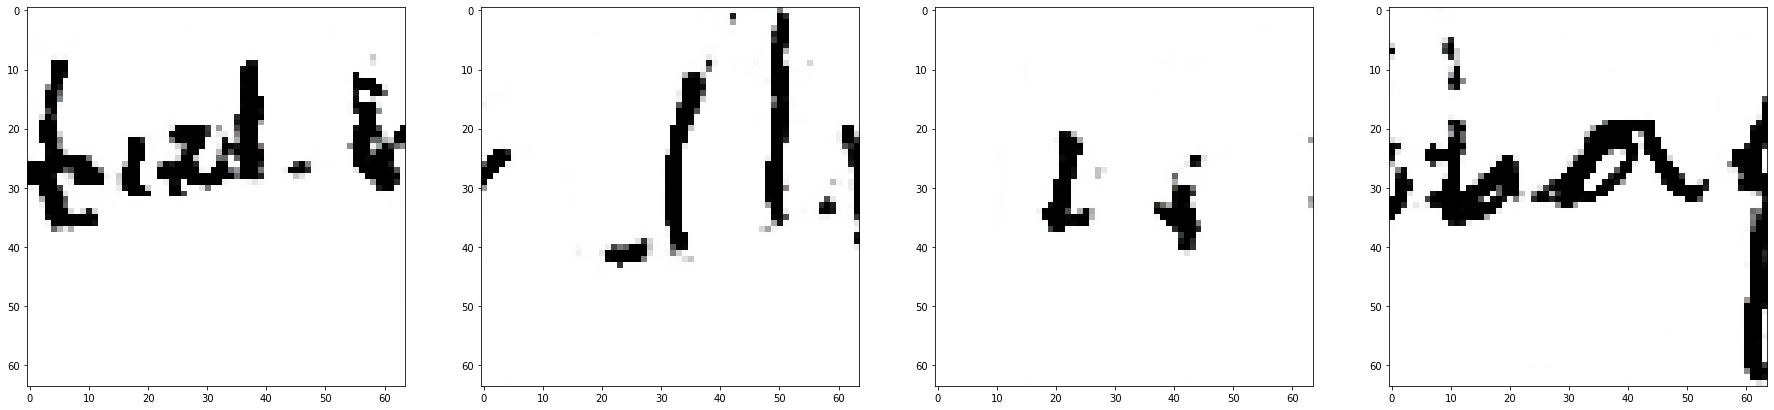

n_iter : 8775/46000, loss = 33772.904531250, time_since: 7332.00
n_iter : 8800/46000, loss = 34466.301406250, time_since: 7354.33
n_iter : 8825/46000, loss = 34304.104296875, time_since: 7374.50
n_iter : 8850/46000, loss = 34651.286250000, time_since: 7397.92
n_iter : 8875/46000, loss = 34575.165312500, time_since: 7418.31
n_iter : 8900/46000, loss = 34537.502031250, time_since: 7442.50
n_iter : 8925/46000, loss = 35128.354375000, time_since: 7466.32
n_iter : 8950/46000, loss = 34445.868906250, time_since: 7486.35
n_iter : 8975/46000, loss = 33997.018984375, time_since: 7510.46
n_iter : 9000/46000, loss = 34141.861015625, time_since: 7530.24


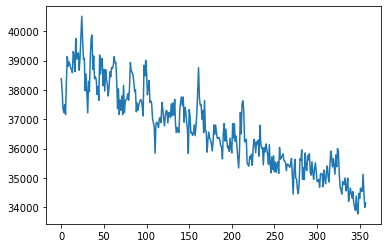

Validation


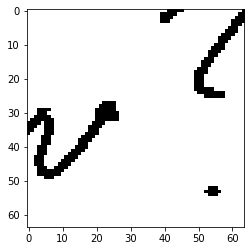

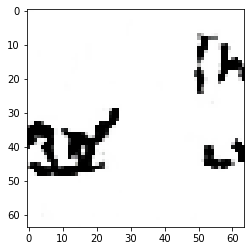

validation loss: 37214.28515625
Random


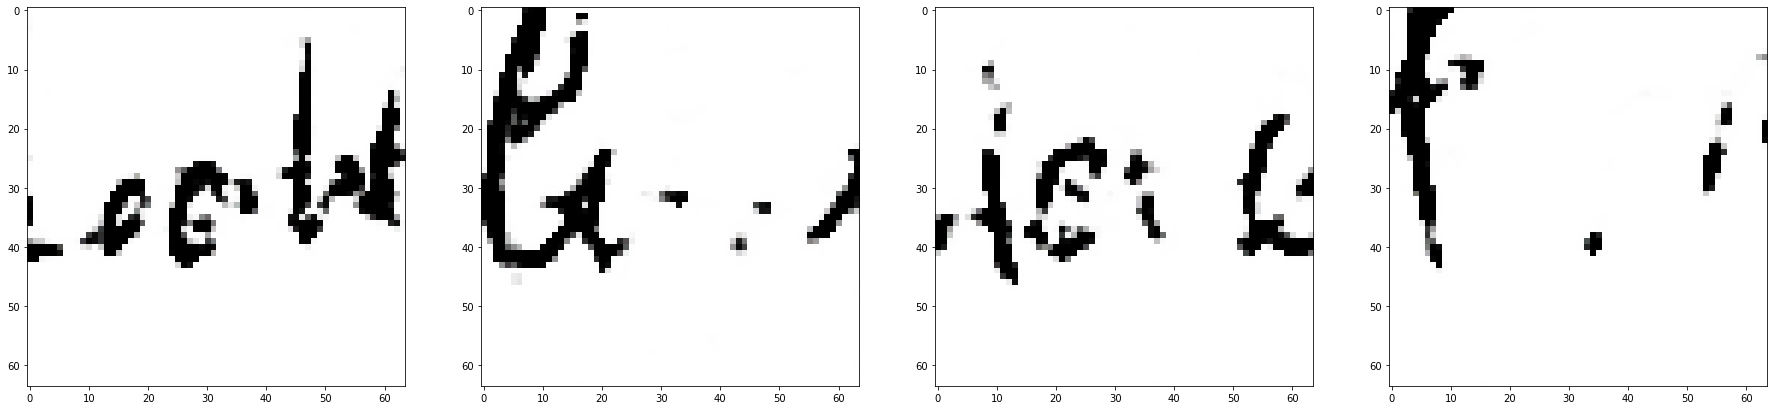

n_iter : 9025/46000, loss = 34286.463671875, time_since: 7553.45
n_iter : 9050/46000, loss = 34695.088593750, time_since: 7571.64
n_iter : 9075/46000, loss = 33968.548515625, time_since: 7594.08
n_iter : 9100/46000, loss = 34222.655156250, time_since: 7613.14
n_iter : 9125/46000, loss = 33892.644140625, time_since: 7634.90
n_iter : 9150/46000, loss = 34487.630156250, time_since: 7653.30
n_iter : 9175/46000, loss = 34450.164375000, time_since: 7675.83
n_iter : 9200/46000, loss = 34241.013671875, time_since: 7698.32
n_iter : 9225/46000, loss = 34115.327187500, time_since: 7716.89
n_iter : 9250/46000, loss = 34039.155625000, time_since: 7739.61


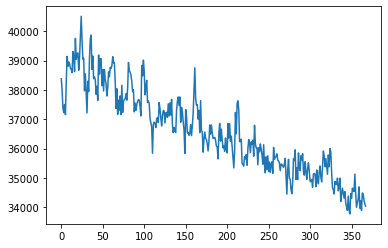

Validation


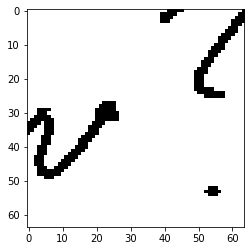

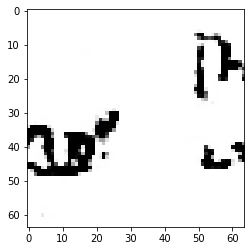

validation loss: 37156.171875
Random


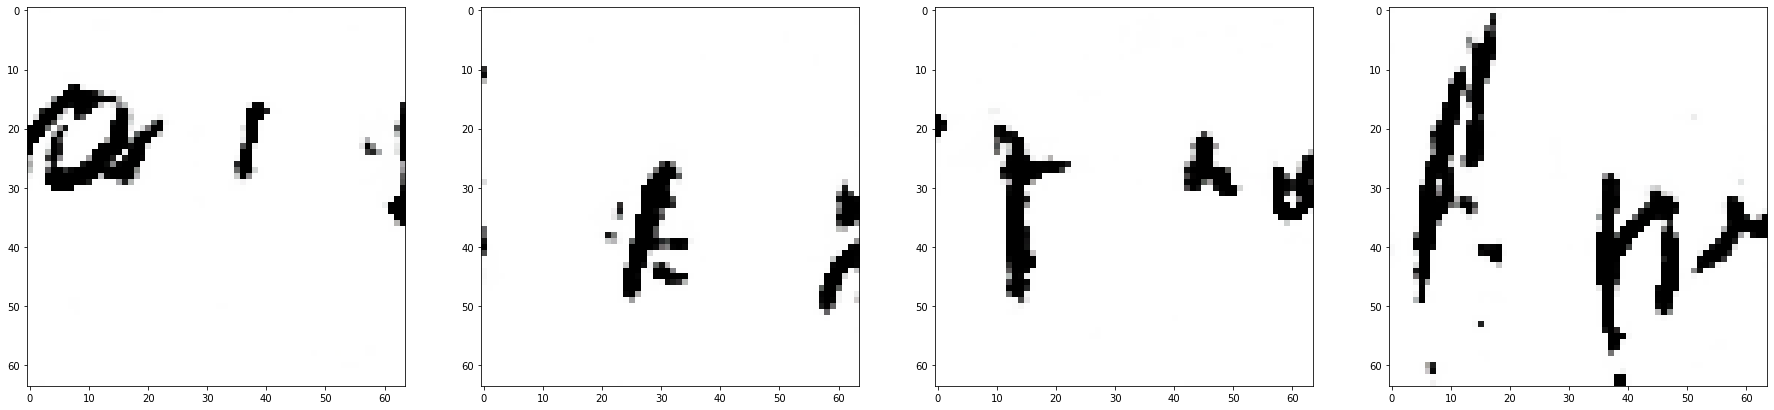

n_iter : 9275/46000, loss = 34737.034843750, time_since: 7757.80
n_iter : 9300/46000, loss = 34608.407500000, time_since: 7780.96
n_iter : 9325/46000, loss = 34838.592578125, time_since: 7801.42
n_iter : 9350/46000, loss = 34678.896406250, time_since: 7824.99
n_iter : 9375/46000, loss = 34516.437031250, time_since: 7844.81
n_iter : 9400/46000, loss = 34211.904921875, time_since: 7868.27
n_iter : 9425/46000, loss = 34566.761093750, time_since: 7887.86
n_iter : 9450/46000, loss = 35125.242031250, time_since: 7911.42
n_iter : 9475/46000, loss = 35452.192968750, time_since: 7931.64
n_iter : 9500/46000, loss = 34438.196562500, time_since: 7955.26


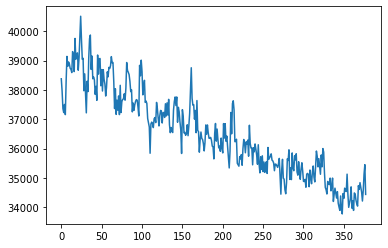

Validation


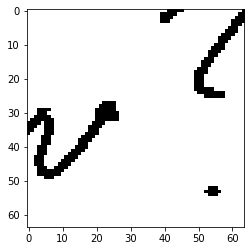

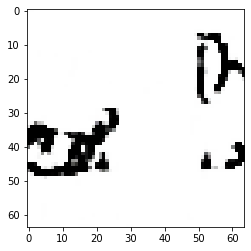

validation loss: 34715.7734375
Random


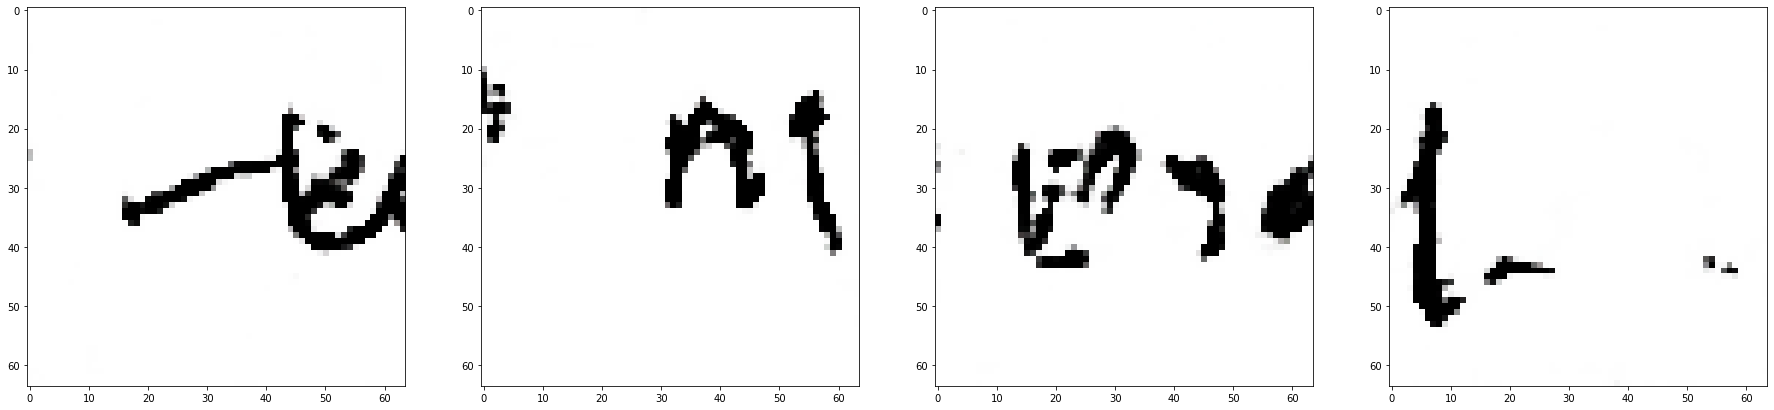

n_iter : 9525/46000, loss = 34662.569218750, time_since: 7978.01
n_iter : 9550/46000, loss = 33725.228515625, time_since: 7997.00
n_iter : 9575/46000, loss = 33988.169687500, time_since: 8018.55
n_iter : 9600/46000, loss = 34386.334921875, time_since: 8037.78
n_iter : 9625/46000, loss = 33902.485703125, time_since: 8059.25
n_iter : 9650/46000, loss = 33966.093281250, time_since: 8078.12
n_iter : 9675/46000, loss = 34089.431875000, time_since: 8099.52
n_iter : 9700/46000, loss = 34175.921250000, time_since: 8118.65
n_iter : 9725/46000, loss = 33316.457265625, time_since: 8140.15
n_iter : 9750/46000, loss = 34277.051328125, time_since: 8158.79


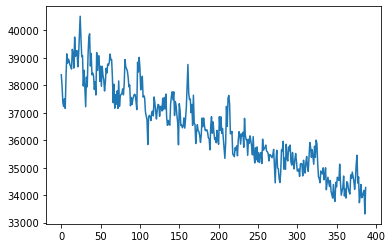

Validation


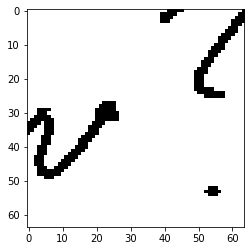

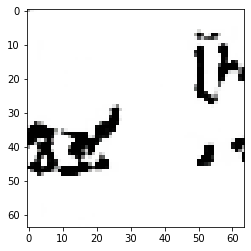

validation loss: 34835.46484375
Random


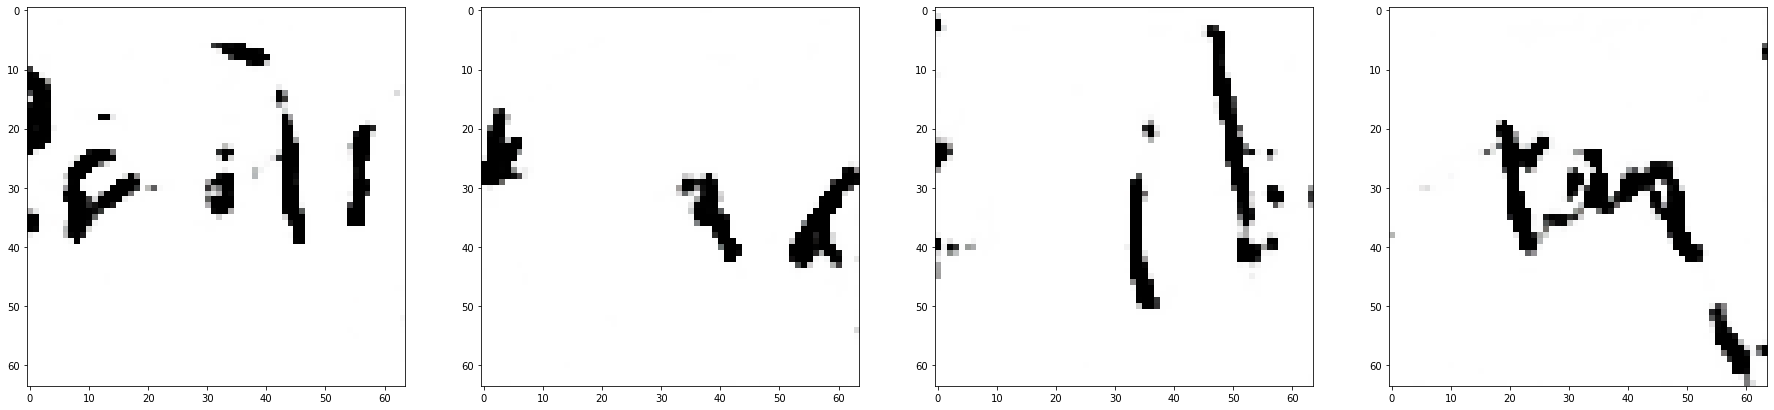

n_iter : 9775/46000, loss = 33951.958359375, time_since: 8182.64
n_iter : 9800/46000, loss = 33888.811406250, time_since: 8206.47
n_iter : 9825/46000, loss = 34560.381718750, time_since: 8226.34
n_iter : 9850/46000, loss = 33895.095859375, time_since: 8249.55
n_iter : 9875/46000, loss = 33856.393203125, time_since: 8269.59
n_iter : 9900/46000, loss = 33338.707031250, time_since: 8293.23
n_iter : 9925/46000, loss = 34119.013750000, time_since: 8313.08
n_iter : 9950/46000, loss = 33590.689921875, time_since: 8336.61
n_iter : 9975/46000, loss = 33618.265078125, time_since: 8356.32
n_iter : 10000/46000, loss = 34082.309375000, time_since: 8380.11


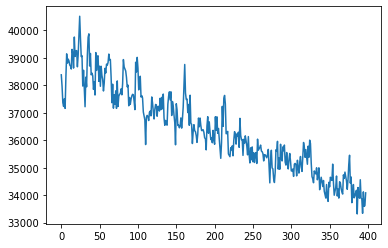

Validation


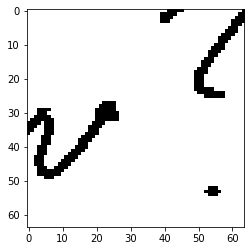

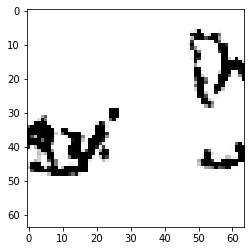

validation loss: 36786.7890625
Random


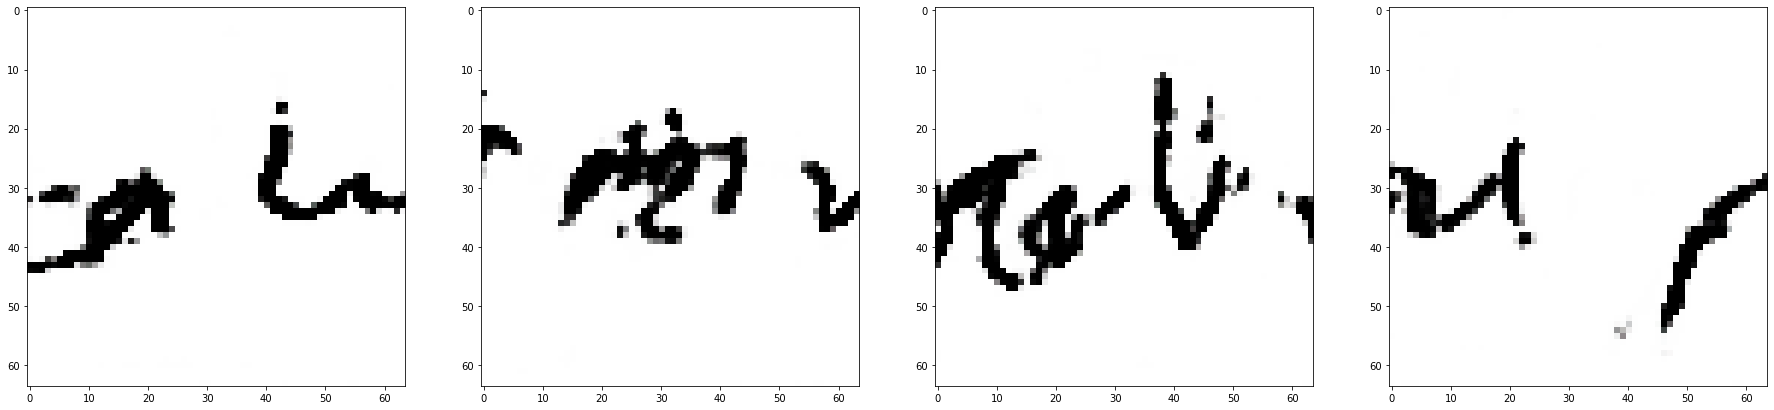

n_iter : 10025/46000, loss = 34335.916093750, time_since: 8398.44
n_iter : 10050/46000, loss = 34397.215546875, time_since: 8421.31
n_iter : 10075/46000, loss = 34519.193984375, time_since: 8443.63
n_iter : 10100/46000, loss = 34279.637187500, time_since: 8462.32
n_iter : 10125/46000, loss = 34547.353281250, time_since: 8484.24
n_iter : 10150/46000, loss = 33976.226093750, time_since: 8502.77
n_iter : 10175/46000, loss = 33907.153828125, time_since: 8525.24
n_iter : 10200/46000, loss = 33980.995625000, time_since: 8543.14
n_iter : 10225/46000, loss = 34371.998203125, time_since: 8565.45
n_iter : 10250/46000, loss = 33960.320078125, time_since: 8583.69


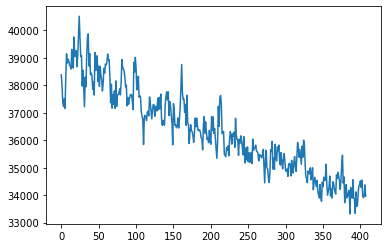

Validation


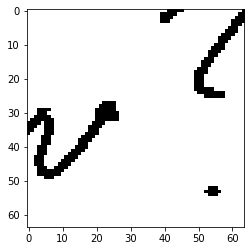

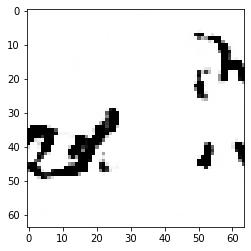

validation loss: 41263.56640625
Random


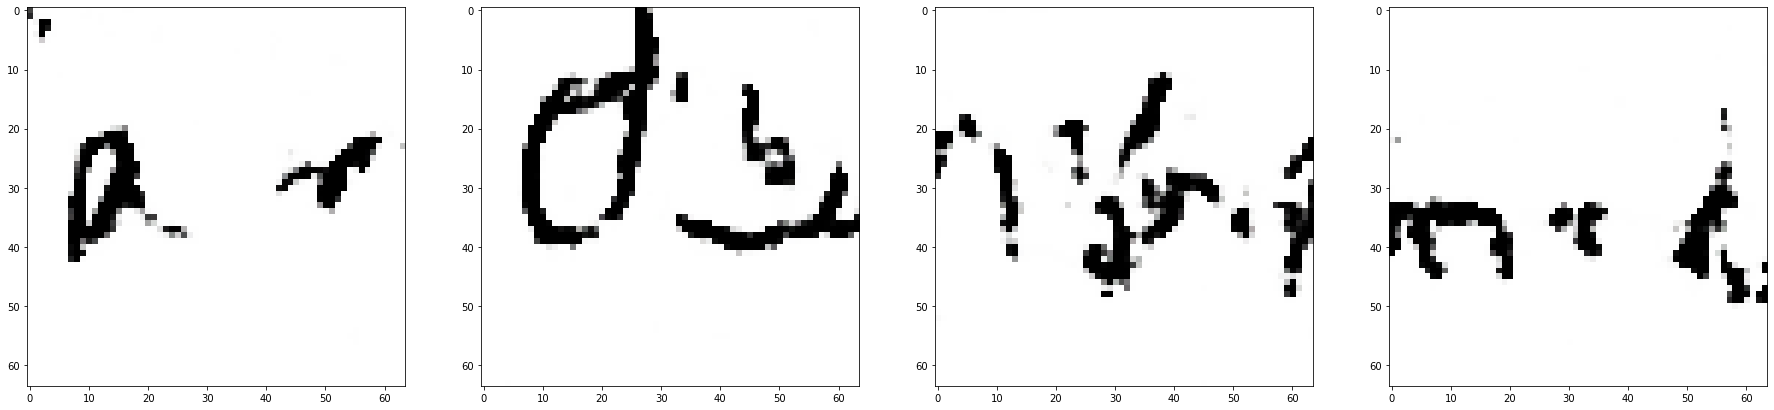

n_iter : 10275/46000, loss = 33982.310937500, time_since: 8606.62
n_iter : 10300/46000, loss = 35096.465937500, time_since: 8626.44
n_iter : 10325/46000, loss = 34844.876875000, time_since: 8650.29
n_iter : 10350/46000, loss = 34381.525156250, time_since: 8674.04
n_iter : 10375/46000, loss = 33751.902578125, time_since: 8693.95
n_iter : 10400/46000, loss = 34850.771250000, time_since: 8717.89
n_iter : 10425/46000, loss = 34265.680625000, time_since: 8737.40
n_iter : 10450/46000, loss = 34912.481718750, time_since: 8761.61
n_iter : 10475/46000, loss = 35437.707343750, time_since: 8781.41
n_iter : 10500/46000, loss = 34375.117890625, time_since: 8805.28


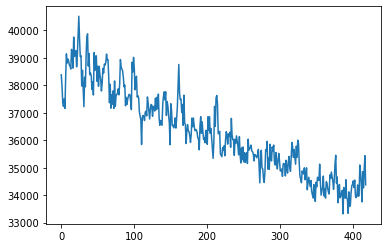

Validation


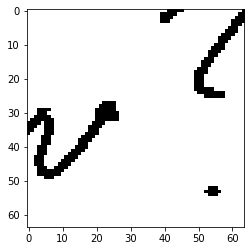

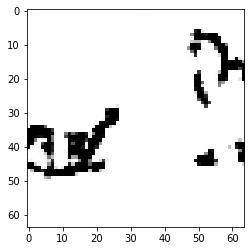

validation loss: 40933.5859375
Random


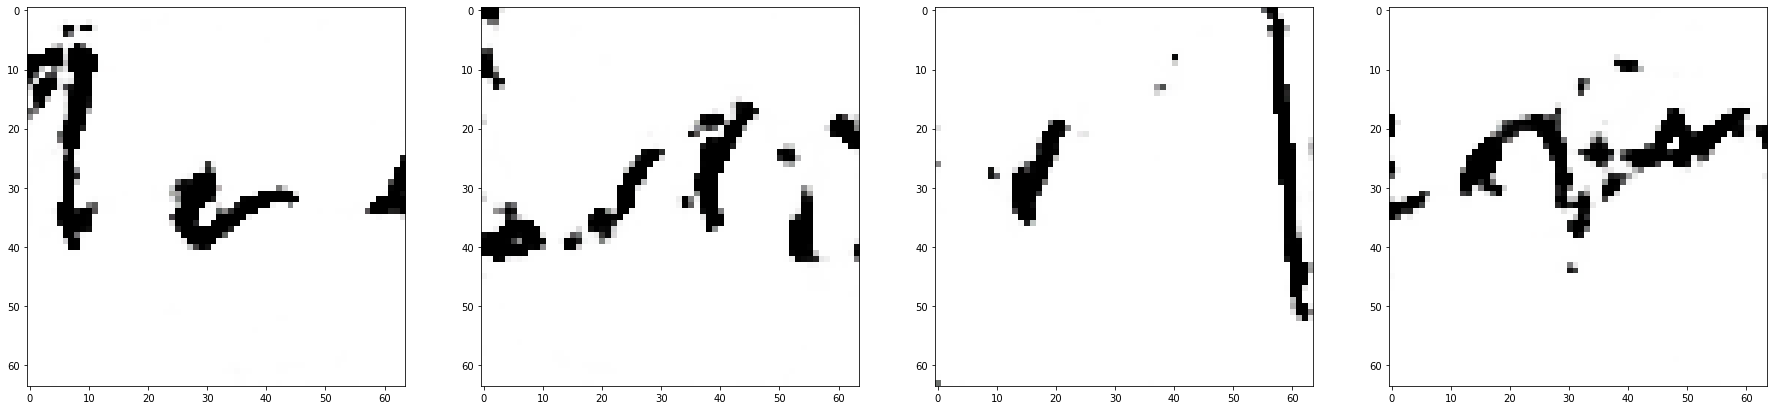

n_iter : 10525/46000, loss = 34395.124062500, time_since: 8825.06
n_iter : 10550/46000, loss = 34653.933359375, time_since: 8847.97
n_iter : 10575/46000, loss = 34800.773437500, time_since: 8866.08
n_iter : 10600/46000, loss = 34361.463437500, time_since: 8888.34
n_iter : 10625/46000, loss = 34080.300390625, time_since: 8906.62
n_iter : 10650/46000, loss = 33500.086015625, time_since: 8928.86
n_iter : 10675/46000, loss = 34262.938593750, time_since: 8950.43
n_iter : 10700/46000, loss = 33811.610156250, time_since: 8969.17
n_iter : 10725/46000, loss = 33530.651015625, time_since: 8990.56
n_iter : 10750/46000, loss = 33351.606328125, time_since: 9009.20


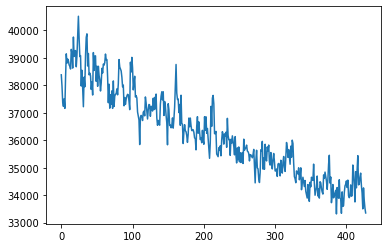

Validation


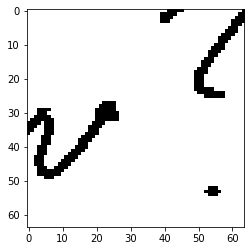

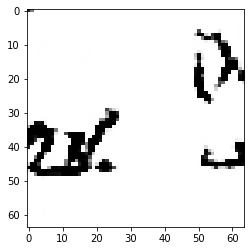

validation loss: 34568.96875
Random


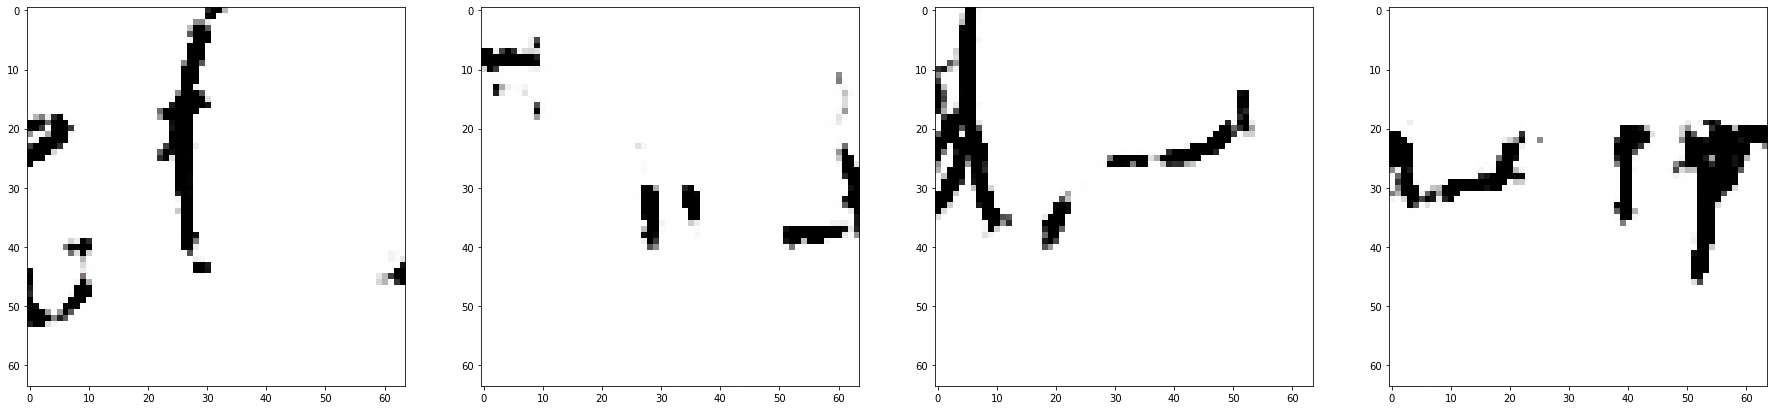

n_iter : 10775/46000, loss = 33287.891250000, time_since: 9031.27
n_iter : 10800/46000, loss = 32956.819531250, time_since: 9052.10
n_iter : 10825/46000, loss = 33429.480546875, time_since: 9075.75
n_iter : 10850/46000, loss = 33087.456796875, time_since: 9097.00
n_iter : 10875/46000, loss = 32968.618125000, time_since: 9119.19
n_iter : 10900/46000, loss = 33341.741328125, time_since: 9140.33
n_iter : 10925/46000, loss = 33068.685468750, time_since: 9162.94
n_iter : 10950/46000, loss = 33614.235625000, time_since: 9186.44
n_iter : 10975/46000, loss = 33851.633203125, time_since: 9206.66
n_iter : 11000/46000, loss = 33658.016953125, time_since: 9230.30


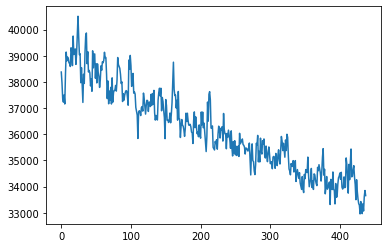

Validation


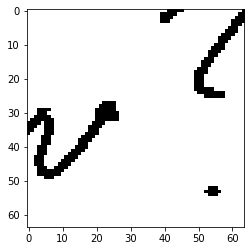

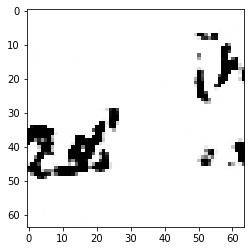

validation loss: 37224.2734375
Random


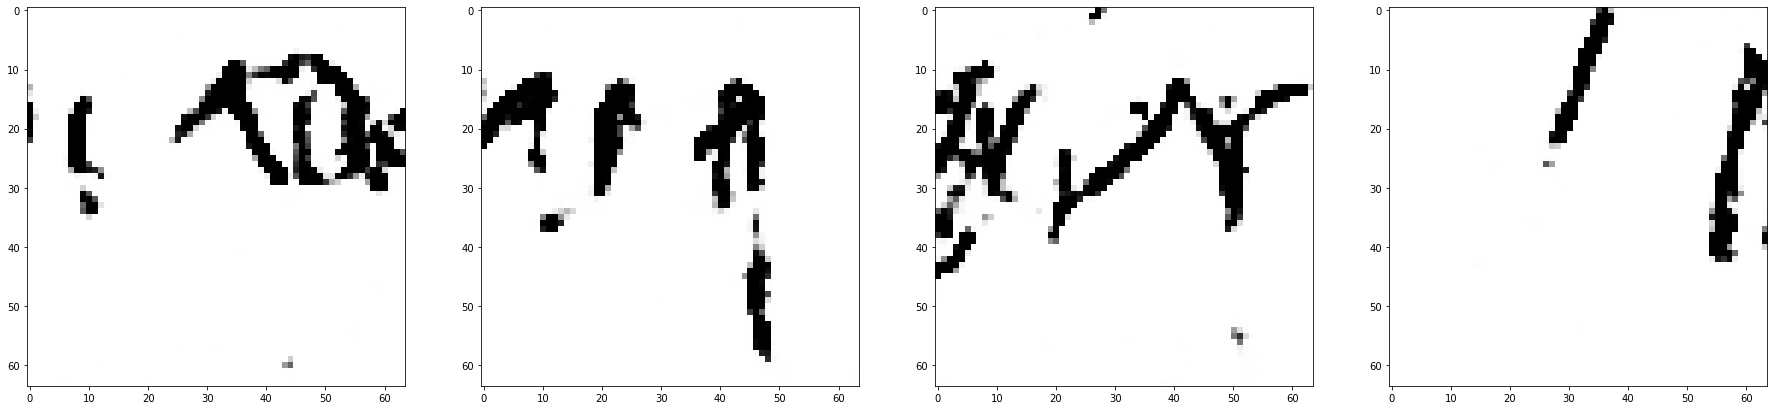

n_iter : 11025/46000, loss = 33614.358203125, time_since: 9250.19
n_iter : 11050/46000, loss = 33891.891015625, time_since: 9273.42
n_iter : 11075/46000, loss = 34008.013203125, time_since: 9291.87
n_iter : 11100/46000, loss = 33432.699296875, time_since: 9313.85
n_iter : 11125/46000, loss = 33935.605468750, time_since: 9332.64
n_iter : 11150/46000, loss = 33619.100781250, time_since: 9354.67
n_iter : 11175/46000, loss = 33827.138906250, time_since: 9372.68
n_iter : 11200/46000, loss = 33397.167656250, time_since: 9394.89
n_iter : 11225/46000, loss = 33510.044140625, time_since: 9417.05
n_iter : 11250/46000, loss = 33729.374531250, time_since: 9435.94


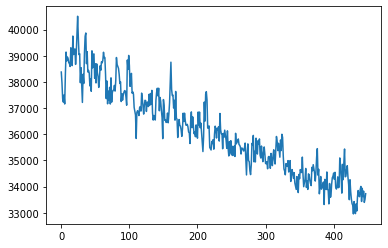

Validation


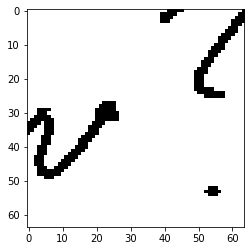

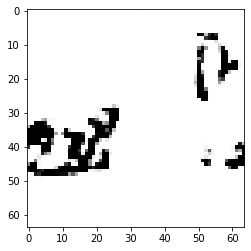

validation loss: 32792.390625
Random


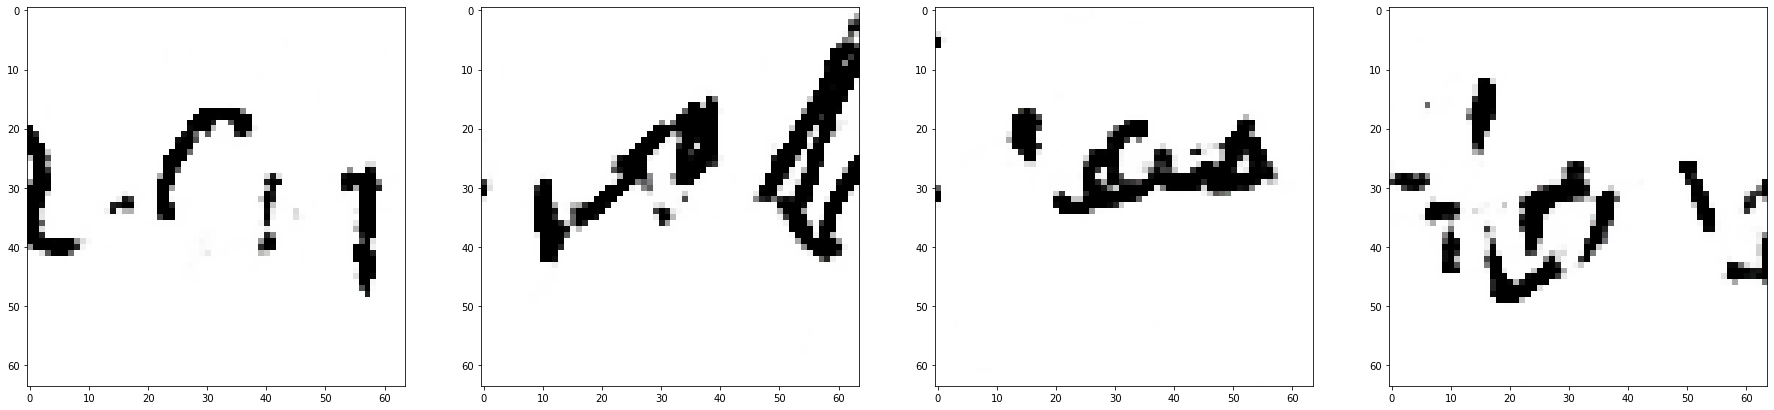

n_iter : 11275/46000, loss = 33283.014531250, time_since: 9457.65
n_iter : 11300/46000, loss = 32965.305468750, time_since: 9477.48
n_iter : 11325/46000, loss = 33094.236640625, time_since: 9501.05
n_iter : 11350/46000, loss = 33347.016953125, time_since: 9521.06
n_iter : 11375/46000, loss = 32677.072421875, time_since: 9544.71
n_iter : 11400/46000, loss = 33545.991796875, time_since: 9564.83
n_iter : 11425/46000, loss = 33682.605781250, time_since: 9588.99
n_iter : 11450/46000, loss = 33695.798593750, time_since: 9608.92
n_iter : 11475/46000, loss = 33992.446328125, time_since: 9632.78
n_iter : 11500/46000, loss = 33201.007421875, time_since: 9656.23


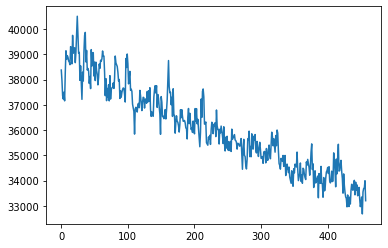

Validation


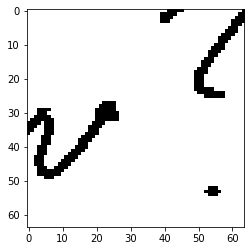

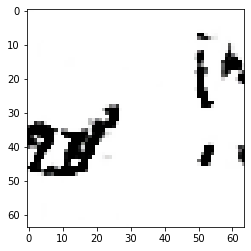

validation loss: 38475.625
Random


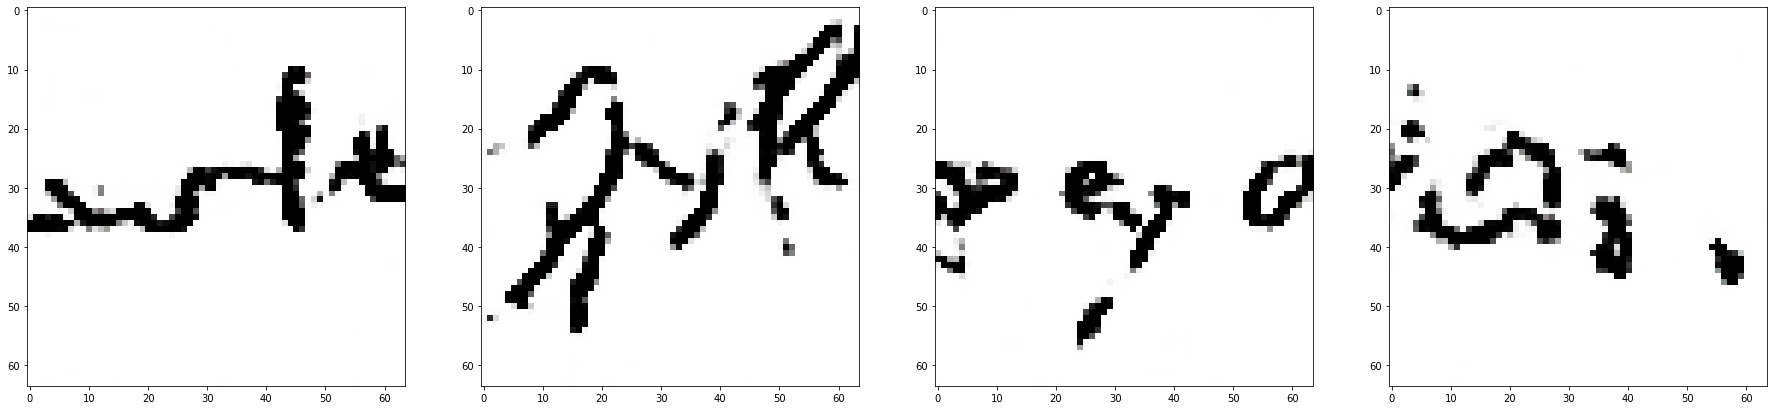

n_iter : 11525/46000, loss = 32972.163515625, time_since: 9676.62
n_iter : 11550/46000, loss = 33533.887890625, time_since: 9700.11
n_iter : 11575/46000, loss = 33824.230000000, time_since: 9718.52
n_iter : 11600/46000, loss = 33581.103828125, time_since: 9740.46
n_iter : 11625/46000, loss = 33999.252890625, time_since: 9759.19
n_iter : 11650/46000, loss = 33895.616875000, time_since: 9781.16
n_iter : 11675/46000, loss = 34485.471406250, time_since: 9799.35
n_iter : 11700/46000, loss = 33568.840156250, time_since: 9821.32
n_iter : 11725/46000, loss = 33991.481406250, time_since: 9839.72
n_iter : 11750/46000, loss = 33239.962031250, time_since: 9861.86


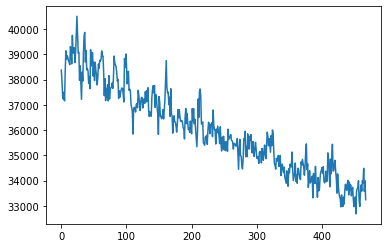

Validation


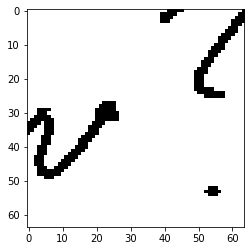

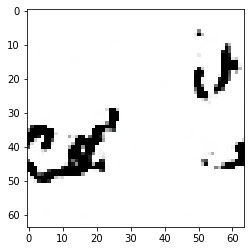

validation loss: 41165.2890625
Random


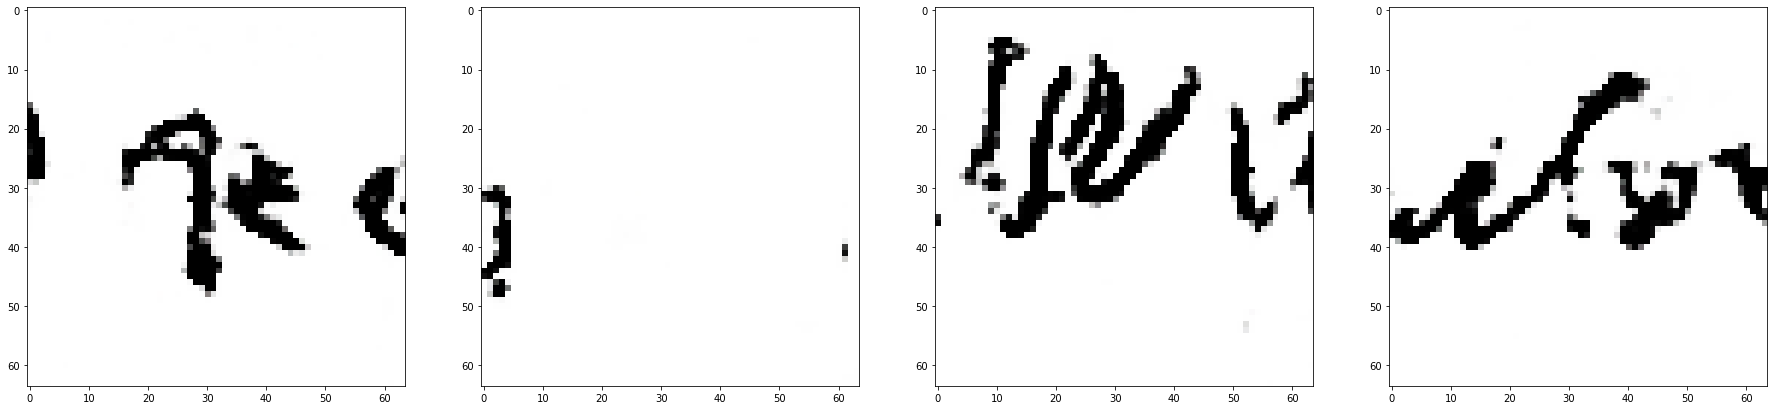

n_iter : 11775/46000, loss = 33271.908203125, time_since: 9879.80
n_iter : 11800/46000, loss = 32971.851640625, time_since: 9904.43
n_iter : 11825/46000, loss = 32872.304140625, time_since: 9927.16
n_iter : 11850/46000, loss = 33087.654609375, time_since: 9948.79
n_iter : 11875/46000, loss = 32793.438281250, time_since: 9971.30
n_iter : 11900/46000, loss = 32487.496093750, time_since: 9992.43
n_iter : 11925/46000, loss = 33271.405625000, time_since: 10015.28
n_iter : 11950/46000, loss = 33137.092343750, time_since: 10035.74
n_iter : 11975/46000, loss = 32866.756796875, time_since: 10058.32
n_iter : 12000/46000, loss = 33936.362187500, time_since: 10079.13


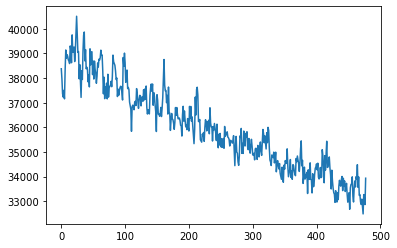

Validation


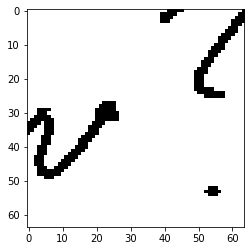

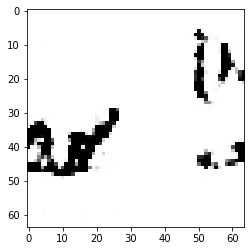

validation loss: 37677.46875
Random


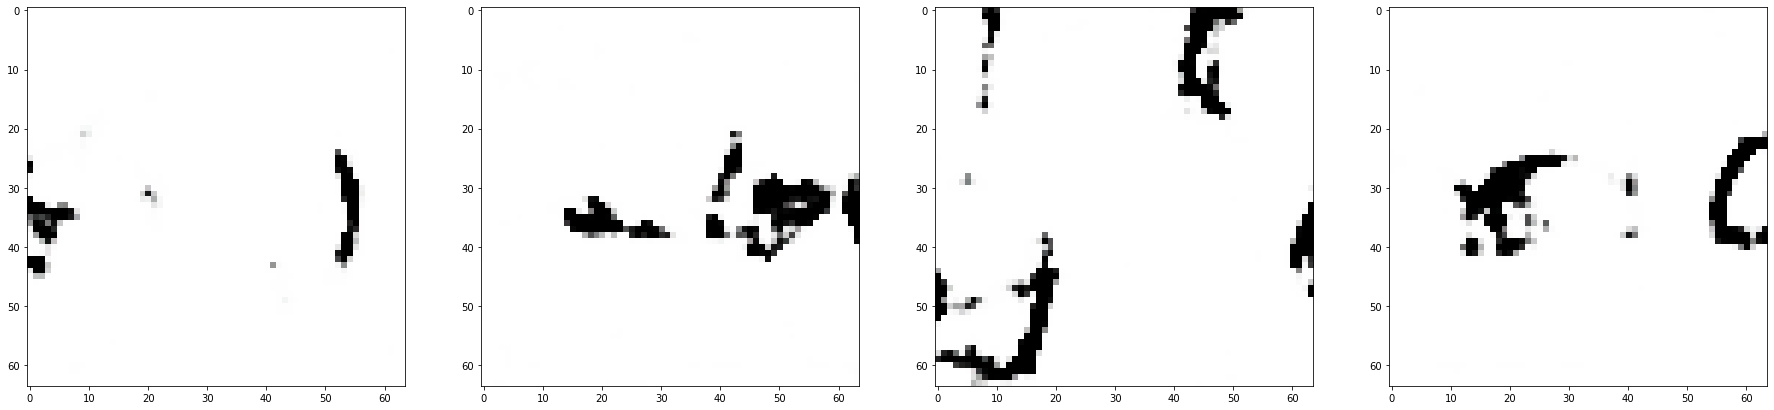

n_iter : 12025/46000, loss = 33100.306406250, time_since: 10101.25
n_iter : 12050/46000, loss = 33477.194687500, time_since: 10119.90
n_iter : 12075/46000, loss = 33208.471640625, time_since: 10141.72
n_iter : 12100/46000, loss = 33820.500625000, time_since: 10163.41
n_iter : 12125/46000, loss = 33468.303671875, time_since: 10181.77
n_iter : 12150/46000, loss = 33634.347265625, time_since: 10204.12
n_iter : 12175/46000, loss = 33873.589375000, time_since: 10222.26
n_iter : 12200/46000, loss = 34663.278437500, time_since: 10244.56
n_iter : 12225/46000, loss = 33713.594375000, time_since: 10262.92
n_iter : 12250/46000, loss = 34056.273515625, time_since: 10284.96


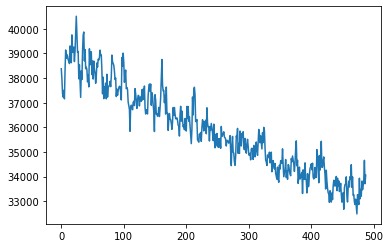

Validation


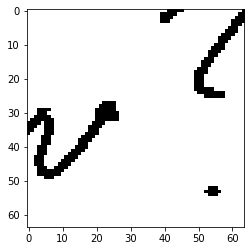

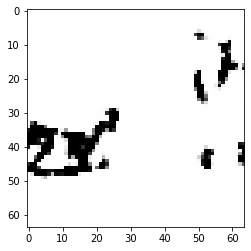

validation loss: 37396.5234375
Random


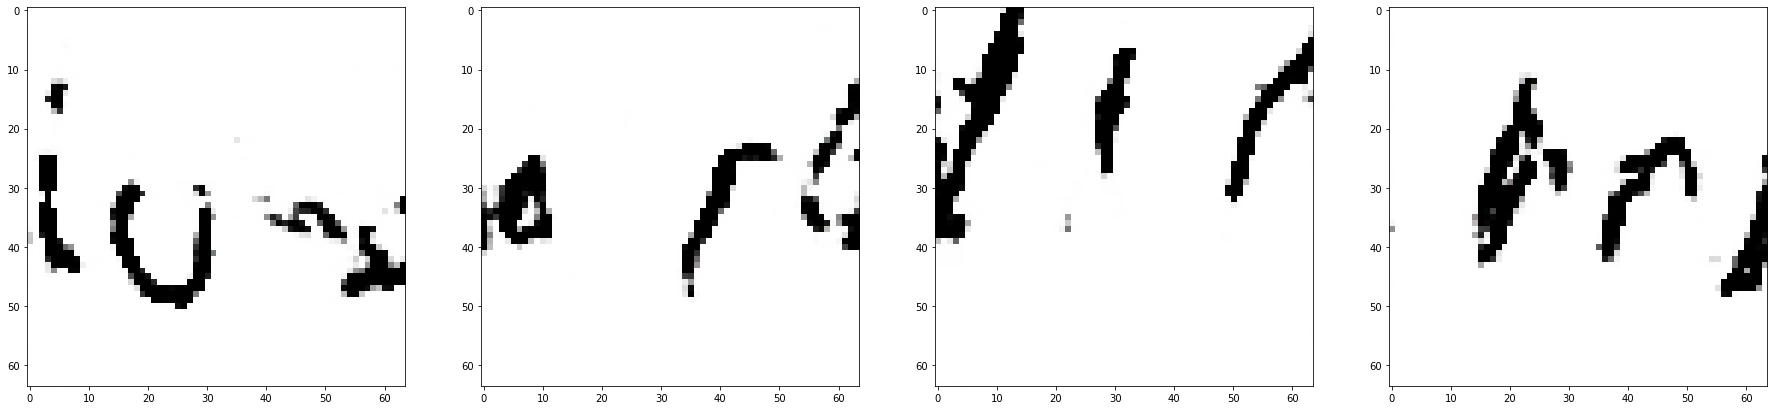

n_iter : 12275/46000, loss = 33790.182265625, time_since: 10303.16
n_iter : 12300/46000, loss = 33512.883750000, time_since: 10326.33
n_iter : 12325/46000, loss = 33103.896484375, time_since: 10346.27
n_iter : 12350/46000, loss = 32868.325546875, time_since: 10370.43
n_iter : 12375/46000, loss = 33185.058203125, time_since: 10394.55
n_iter : 12400/46000, loss = 33945.769843750, time_since: 10414.41
n_iter : 12425/46000, loss = 33634.542109375, time_since: 10437.94
n_iter : 12450/46000, loss = 33445.116171875, time_since: 10458.22
n_iter : 12475/46000, loss = 34141.757187500, time_since: 10481.30
n_iter : 12500/46000, loss = 33324.702734375, time_since: 10501.52


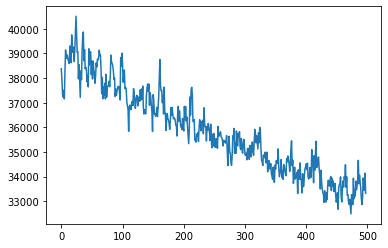

Validation


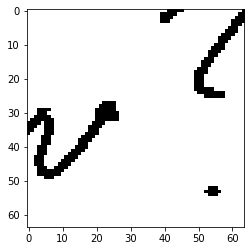

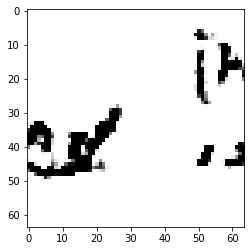

validation loss: 39679.046875
Random


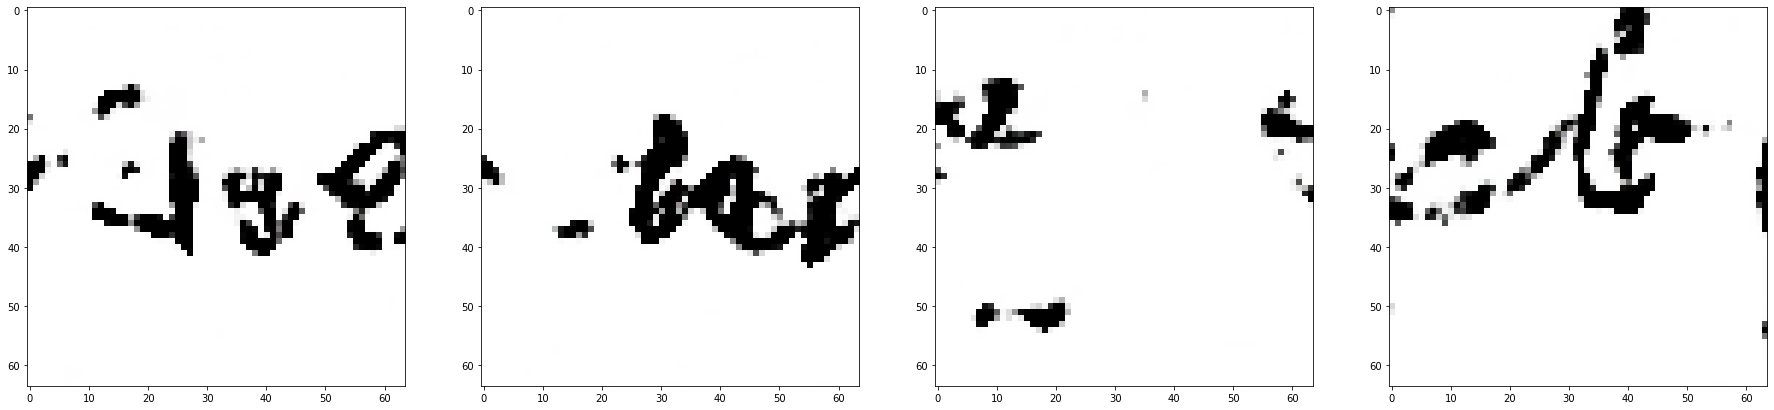

n_iter : 12525/46000, loss = 32955.856796875, time_since: 10524.20
n_iter : 12550/46000, loss = 33045.283046875, time_since: 10542.28
n_iter : 12575/46000, loss = 32688.209218750, time_since: 10564.30
n_iter : 12600/46000, loss = 33105.574453125, time_since: 10582.39
n_iter : 12625/46000, loss = 32572.513750000, time_since: 10604.27
n_iter : 12650/46000, loss = 33323.473281250, time_since: 10626.77
n_iter : 12675/46000, loss = 33396.085781250, time_since: 10644.55
n_iter : 12700/46000, loss = 32823.280156250, time_since: 10666.59
n_iter : 12725/46000, loss = 32672.621718750, time_since: 10684.54
n_iter : 12750/46000, loss = 32864.802734375, time_since: 10706.76


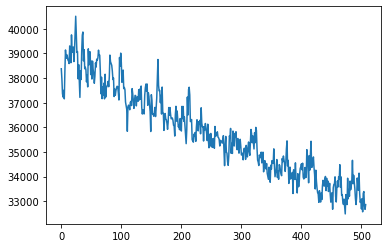

Validation


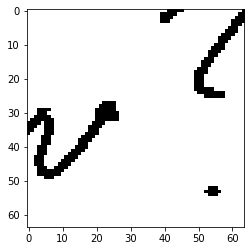

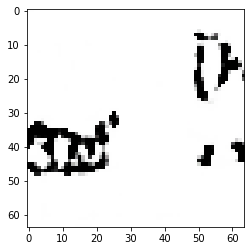

validation loss: 40575.27734375
Random


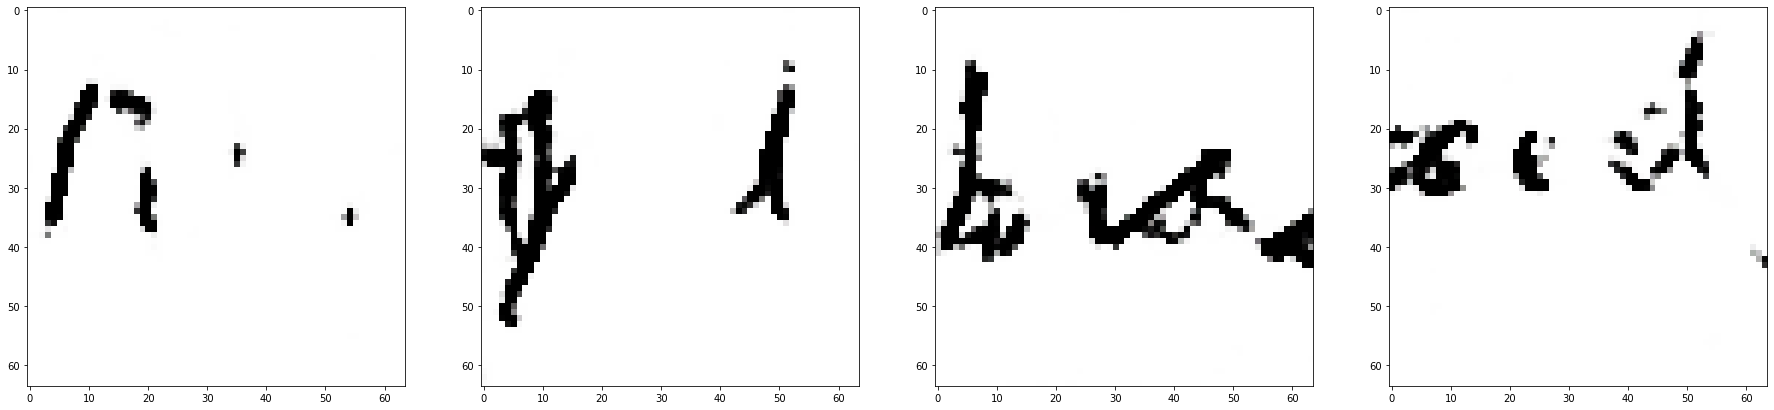

n_iter : 12775/46000, loss = 32709.825000000, time_since: 10725.24
n_iter : 12800/46000, loss = 33088.626093750, time_since: 10747.75
n_iter : 12825/46000, loss = 32767.337656250, time_since: 10768.06
n_iter : 12850/46000, loss = 32946.880781250, time_since: 10791.98
n_iter : 12875/46000, loss = 34551.731406250, time_since: 10812.00
n_iter : 12900/46000, loss = 34669.906406250, time_since: 10835.31
n_iter : 12925/46000, loss = 35142.736562500, time_since: 10855.11
n_iter : 12950/46000, loss = 34228.410703125, time_since: 10879.75
n_iter : 12975/46000, loss = 34160.676718750, time_since: 10902.25
n_iter : 13000/46000, loss = 33229.429062500, time_since: 10924.16


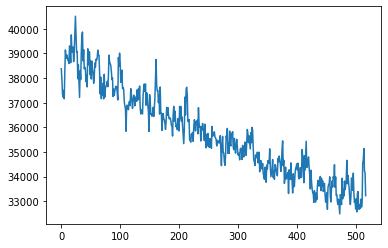

Validation


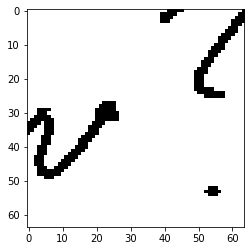

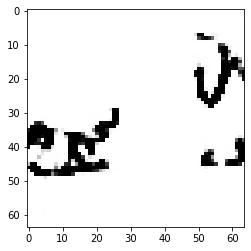

validation loss: 36873.8984375
Random


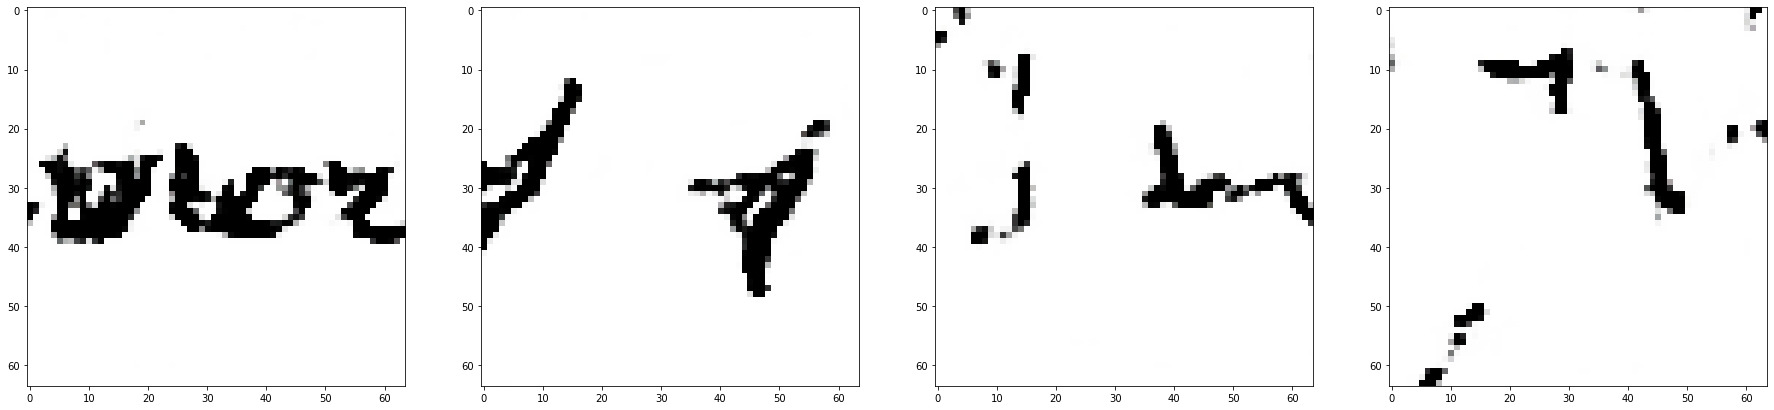

n_iter : 13025/46000, loss = 32734.023671875, time_since: 10946.27
n_iter : 13050/46000, loss = 33439.186250000, time_since: 10965.22
n_iter : 13075/46000, loss = 32273.270234375, time_since: 10986.78
n_iter : 13100/46000, loss = 32487.438984375, time_since: 11005.83
n_iter : 13125/46000, loss = 32303.210312500, time_since: 11027.21
n_iter : 13150/46000, loss = 33304.616406250, time_since: 11045.97
n_iter : 13175/46000, loss = 32498.076171875, time_since: 11067.34
n_iter : 13200/46000, loss = 32180.986640625, time_since: 11085.80
n_iter : 13225/46000, loss = 32233.617656250, time_since: 11107.89
n_iter : 13250/46000, loss = 32480.897187500, time_since: 11130.04


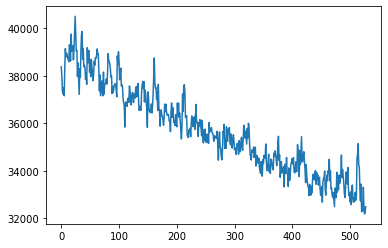

Validation


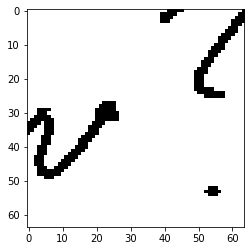

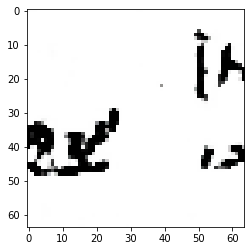

validation loss: 41100.58203125
Random


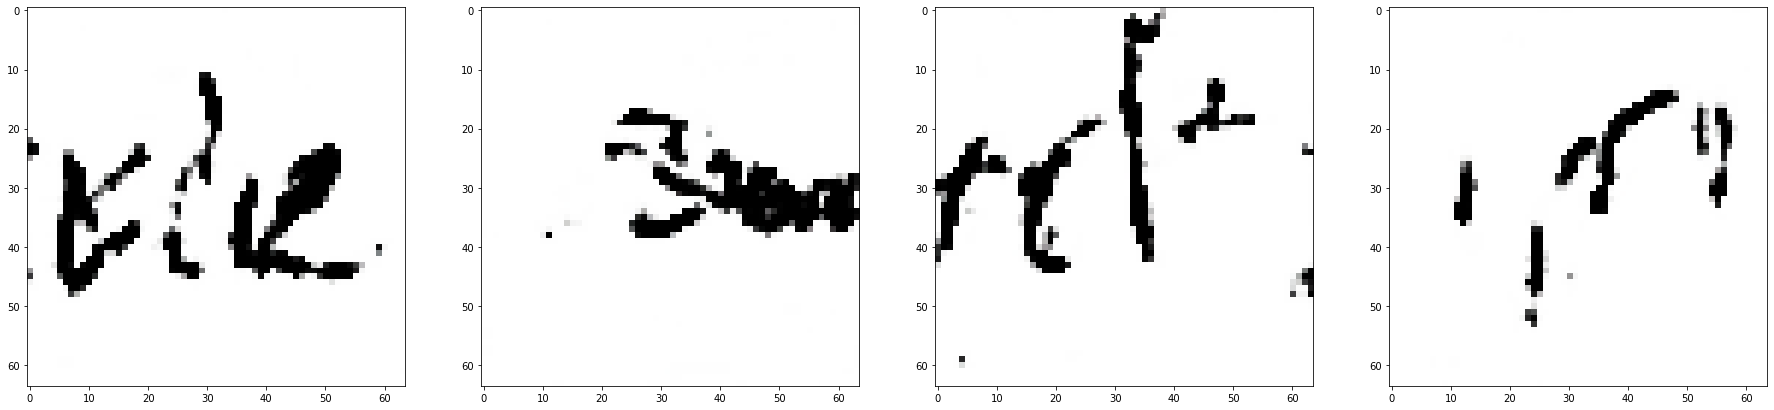

n_iter : 13275/46000, loss = 32344.436015625, time_since: 11148.35
n_iter : 13300/46000, loss = 32646.373046875, time_since: 11170.23
n_iter : 13325/46000, loss = 32507.370000000, time_since: 11190.23
n_iter : 13350/46000, loss = 32700.913437500, time_since: 11214.17
n_iter : 13375/46000, loss = 33346.361093750, time_since: 11233.90
n_iter : 13400/46000, loss = 33602.932890625, time_since: 11257.62
n_iter : 13425/46000, loss = 33542.513593750, time_since: 11277.38
n_iter : 13450/46000, loss = 33307.740468750, time_since: 11301.13
n_iter : 13475/46000, loss = 33643.283125000, time_since: 11320.78
n_iter : 13500/46000, loss = 33292.126718750, time_since: 11344.64


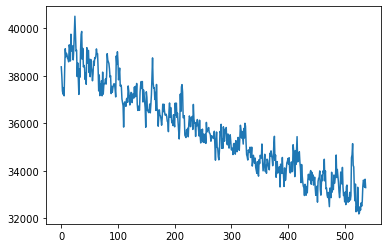

Validation


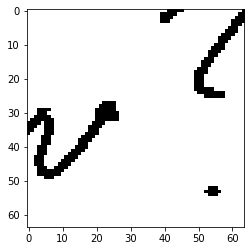

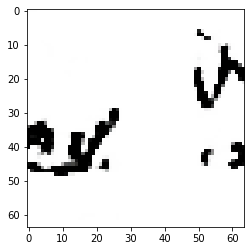

validation loss: 39344.1875
Random


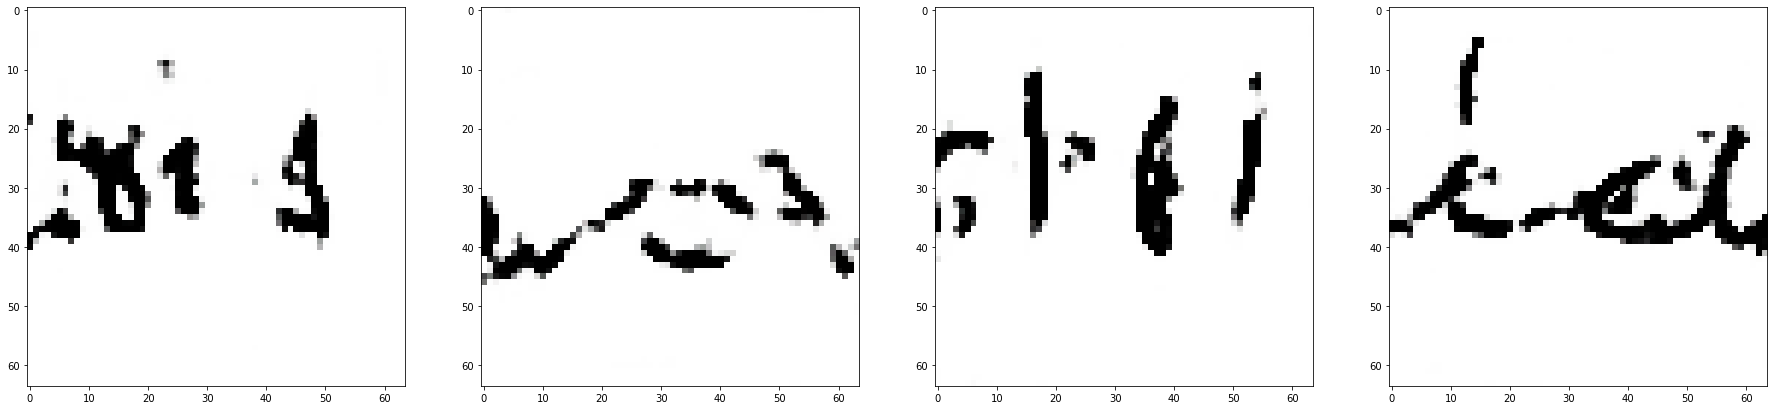

n_iter : 13525/46000, loss = 32640.168515625, time_since: 11368.97
n_iter : 13550/46000, loss = 32420.670546875, time_since: 11387.15
n_iter : 13575/46000, loss = 33035.096250000, time_since: 11409.44
n_iter : 13600/46000, loss = 32927.402968750, time_since: 11427.61
n_iter : 13625/46000, loss = 32973.580390625, time_since: 11449.79
n_iter : 13650/46000, loss = 32819.558437500, time_since: 11468.01
n_iter : 13675/46000, loss = 32636.066171875, time_since: 11490.42
n_iter : 13700/46000, loss = 33051.760937500, time_since: 11508.23
n_iter : 13725/46000, loss = 32997.607031250, time_since: 11530.34
n_iter : 13750/46000, loss = 32457.680546875, time_since: 11548.53


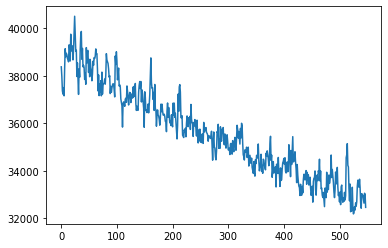

Validation


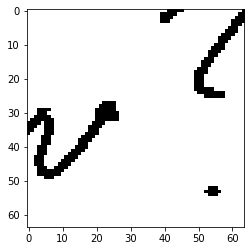

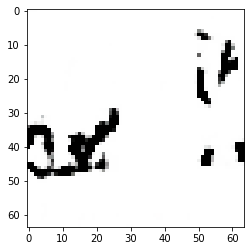

validation loss: 40670.22265625
Random


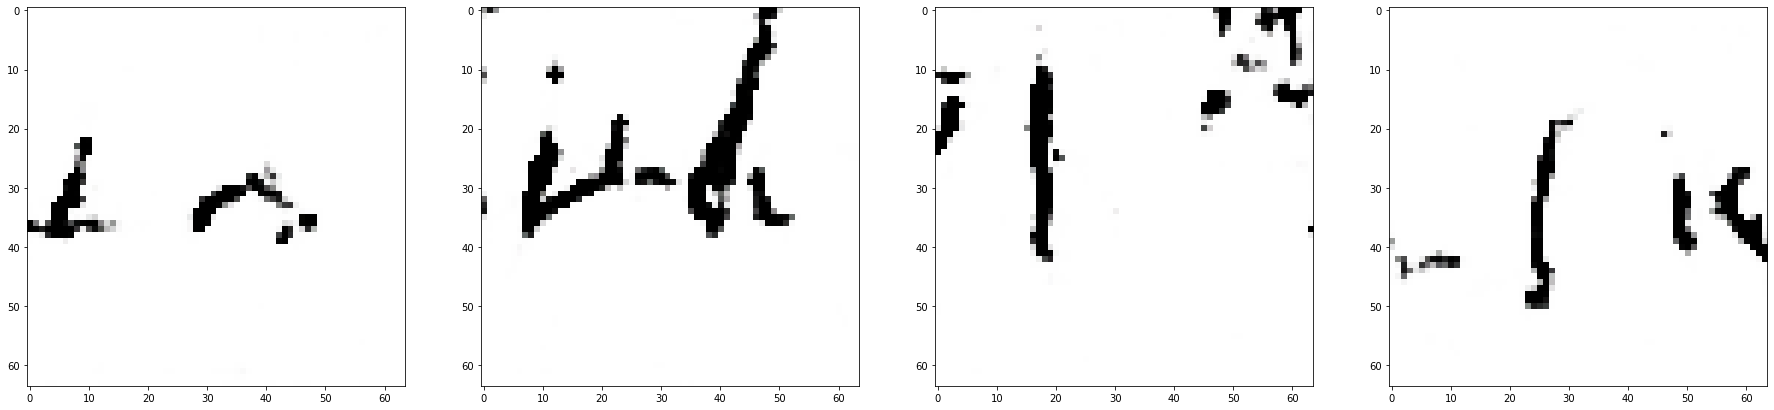

n_iter : 13775/46000, loss = 32558.053906250, time_since: 11572.41
n_iter : 13800/46000, loss = 32734.825468750, time_since: 11596.15
n_iter : 13825/46000, loss = 32553.580781250, time_since: 11616.02
n_iter : 13850/46000, loss = 32377.553515625, time_since: 11640.87
n_iter : 13875/46000, loss = 32561.563984375, time_since: 11660.80
n_iter : 13900/46000, loss = 32419.925234375, time_since: 11684.37
n_iter : 13925/46000, loss = 32567.962265625, time_since: 11704.47
n_iter : 13950/46000, loss = 32408.911484375, time_since: 11728.44
n_iter : 13975/46000, loss = 32459.110390625, time_since: 11748.62
n_iter : 14000/46000, loss = 31791.157968750, time_since: 11772.54


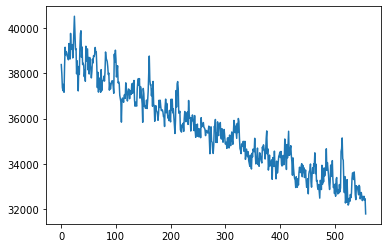

Validation


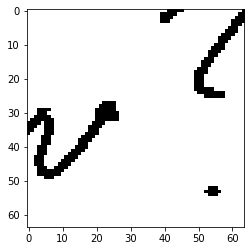

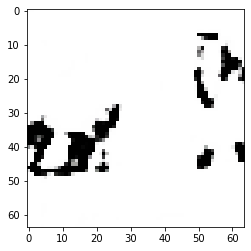

validation loss: 35641.38671875
Random


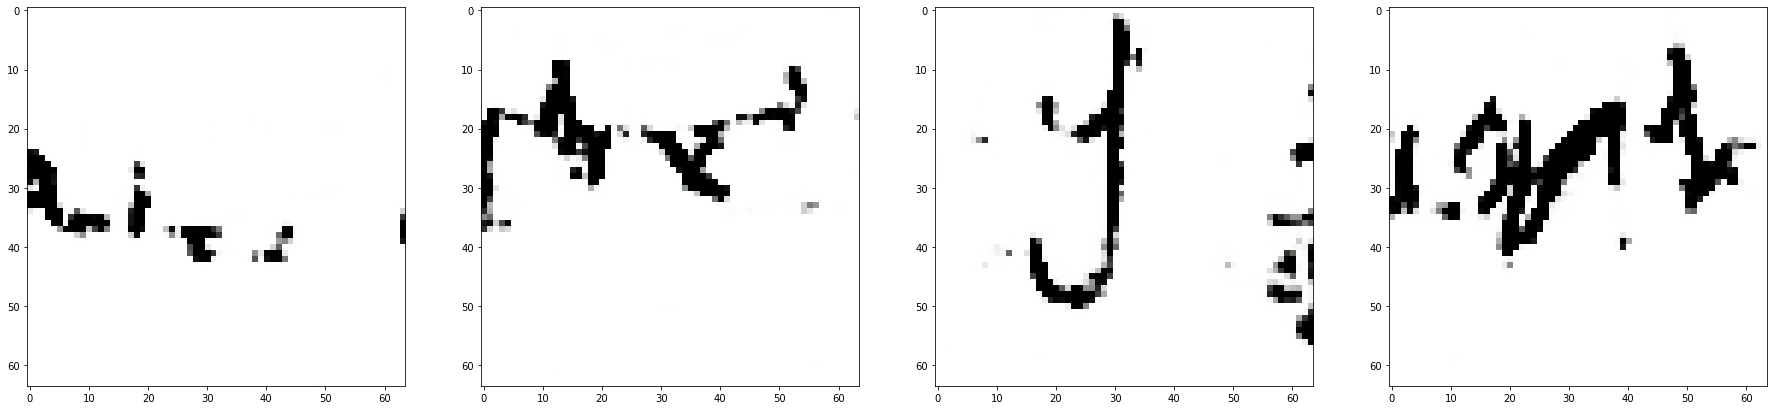

n_iter : 14025/46000, loss = 32601.313203125, time_since: 11792.64
n_iter : 14050/46000, loss = 32645.156718750, time_since: 11815.83
n_iter : 14075/46000, loss = 32285.638828125, time_since: 11833.81
n_iter : 14100/46000, loss = 32021.954531250, time_since: 11855.73
n_iter : 14125/46000, loss = 32724.348906250, time_since: 11877.46
n_iter : 14150/46000, loss = 32662.470234375, time_since: 11896.35
n_iter : 14175/46000, loss = 31663.149062500, time_since: 11917.98
n_iter : 14200/46000, loss = 32319.552343750, time_since: 11936.96
n_iter : 14225/46000, loss = 32492.136640625, time_since: 11958.40
n_iter : 14250/46000, loss = 32747.639375000, time_since: 11977.86


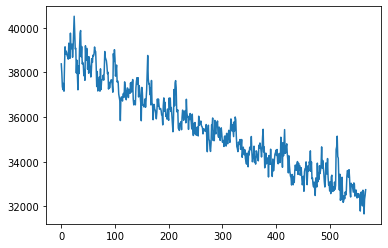

Validation


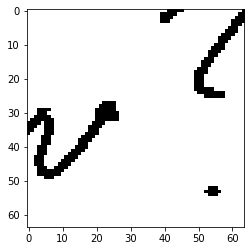

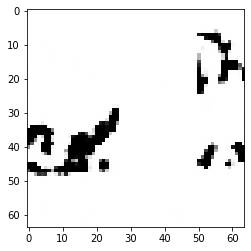

validation loss: 41719.6015625
Random


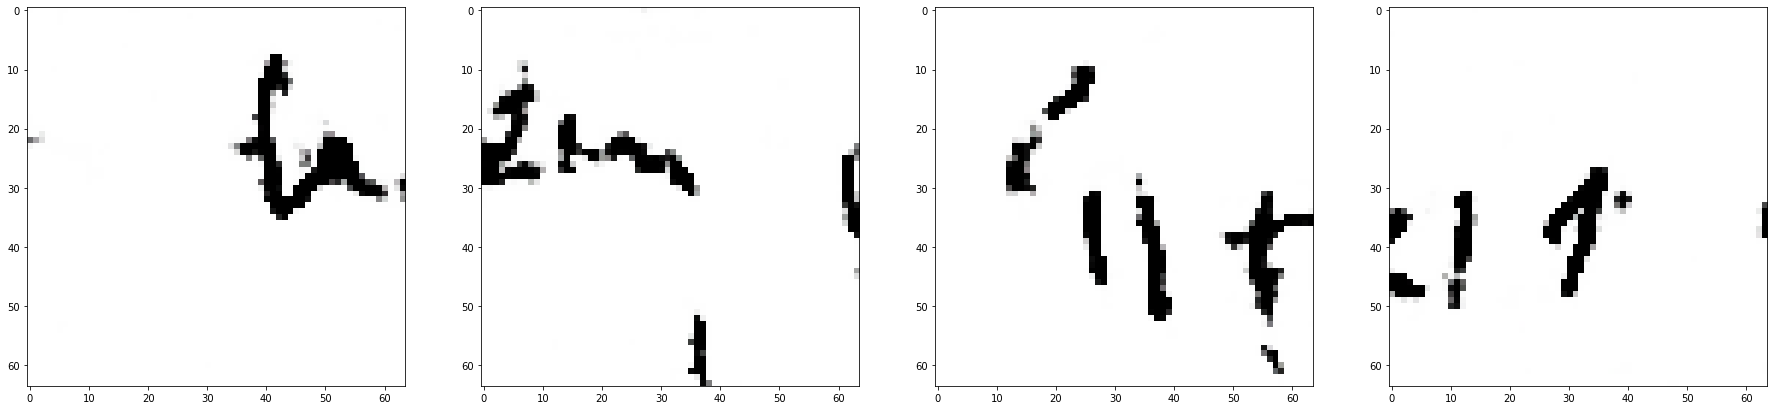

n_iter : 14275/46000, loss = 32536.911484375, time_since: 12000.70
n_iter : 14300/46000, loss = 32914.125156250, time_since: 12020.54
n_iter : 14325/46000, loss = 32622.491875000, time_since: 12043.46
n_iter : 14350/46000, loss = 33290.471796875, time_since: 12064.94
n_iter : 14375/46000, loss = 33104.285703125, time_since: 12087.44
n_iter : 14400/46000, loss = 33248.582421875, time_since: 12110.87
n_iter : 14425/46000, loss = 33154.731718750, time_since: 12130.93
n_iter : 14450/46000, loss = 33067.364375000, time_since: 12154.39
n_iter : 14475/46000, loss = 32612.878359375, time_since: 12174.63
n_iter : 14500/46000, loss = 32637.332109375, time_since: 12198.05


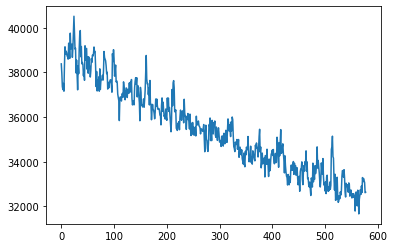

Validation


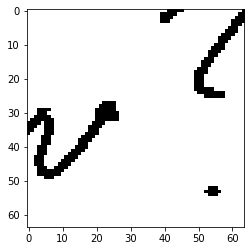

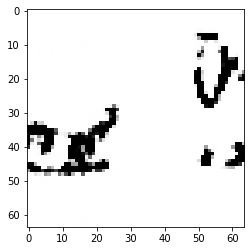

validation loss: 37206.5390625
Random


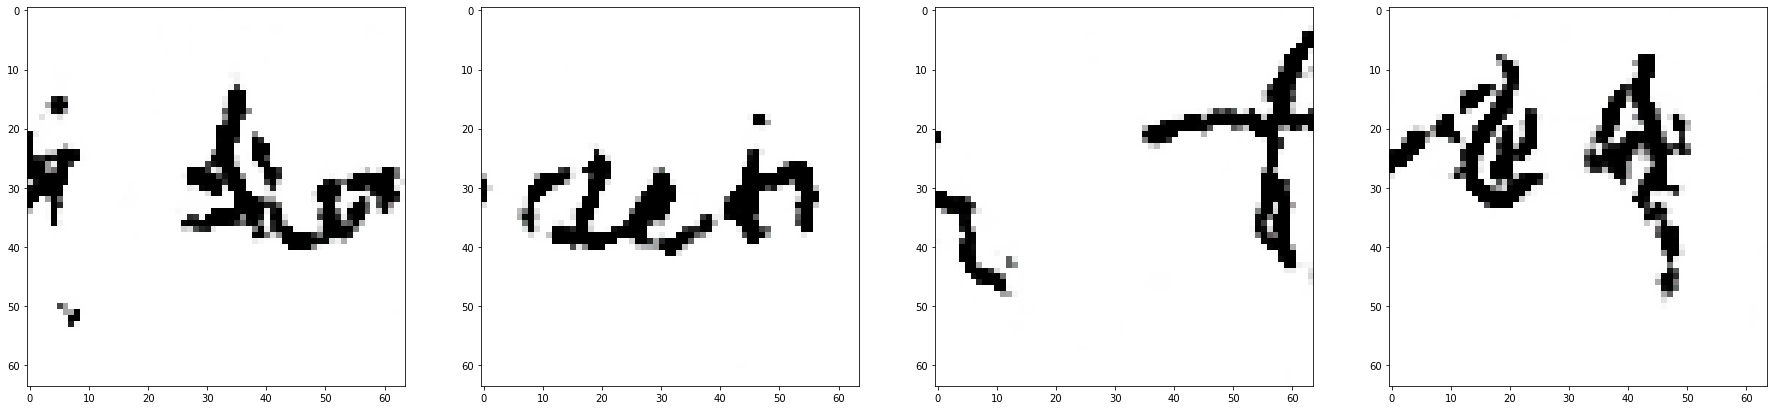

n_iter : 14525/46000, loss = 32530.186484375, time_since: 12217.62
n_iter : 14550/46000, loss = 32886.331640625, time_since: 12240.32
n_iter : 14575/46000, loss = 33729.831484375, time_since: 12258.29
n_iter : 14600/46000, loss = 33407.833515625, time_since: 12280.63
n_iter : 14625/46000, loss = 33558.861562500, time_since: 12298.75
n_iter : 14650/46000, loss = 33391.765000000, time_since: 12320.98
n_iter : 14675/46000, loss = 32707.835234375, time_since: 12343.73
n_iter : 14700/46000, loss = 32121.927734375, time_since: 12362.87
n_iter : 14725/46000, loss = 32538.723359375, time_since: 12384.73
n_iter : 14750/46000, loss = 32933.577656250, time_since: 12403.45


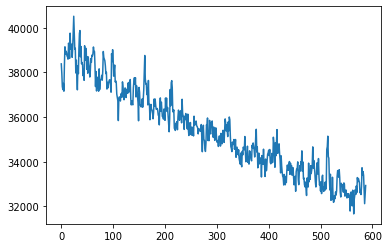

Validation


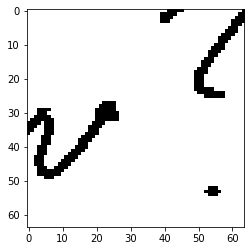

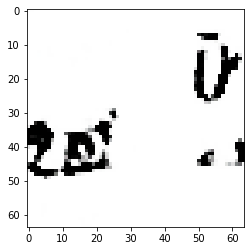

validation loss: 35840.078125
Random


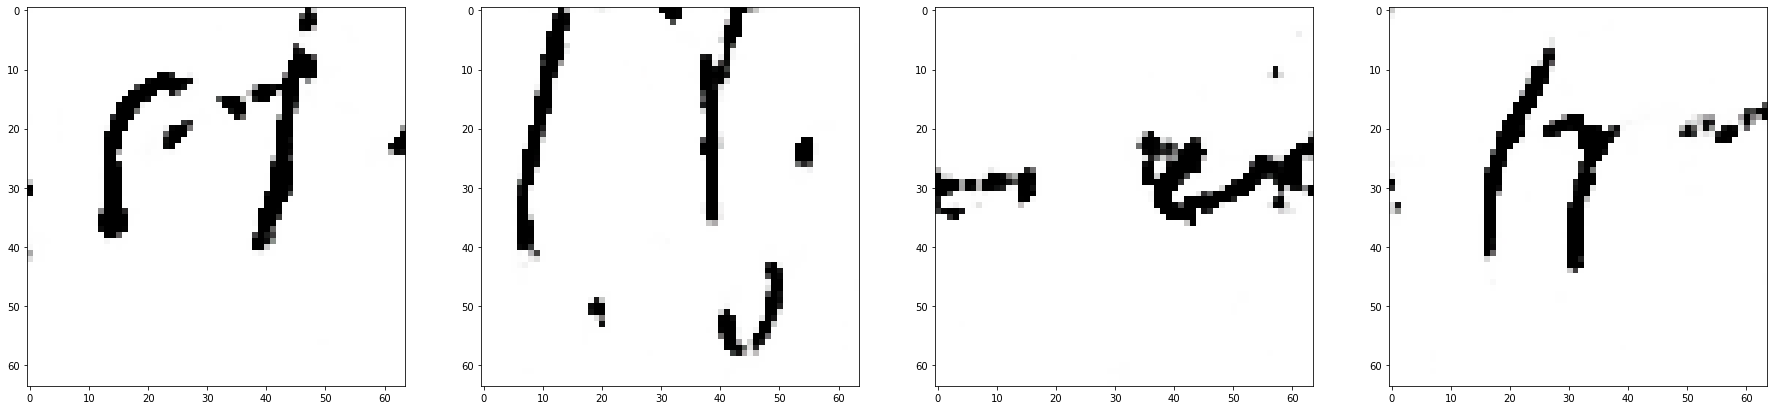

n_iter : 14775/46000, loss = 32769.356718750, time_since: 12425.94
n_iter : 14800/46000, loss = 32846.796718750, time_since: 12445.77
n_iter : 14825/46000, loss = 32829.199062500, time_since: 12468.86
n_iter : 14850/46000, loss = 32303.783750000, time_since: 12489.61
n_iter : 14875/46000, loss = 32159.536718750, time_since: 12513.84
n_iter : 14900/46000, loss = 32225.465390625, time_since: 12533.99
n_iter : 14925/46000, loss = 31976.162656250, time_since: 12557.22
n_iter : 14950/46000, loss = 31974.484140625, time_since: 12581.16
n_iter : 14975/46000, loss = 32411.341640625, time_since: 12601.18
n_iter : 15000/46000, loss = 32733.908125000, time_since: 12624.46


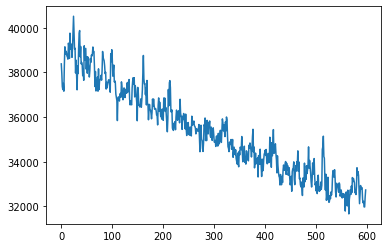

Validation


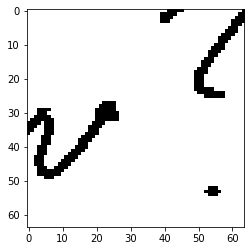

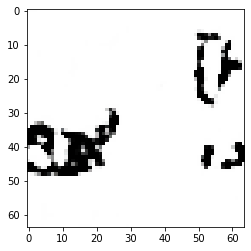

validation loss: 39231.64453125
Random


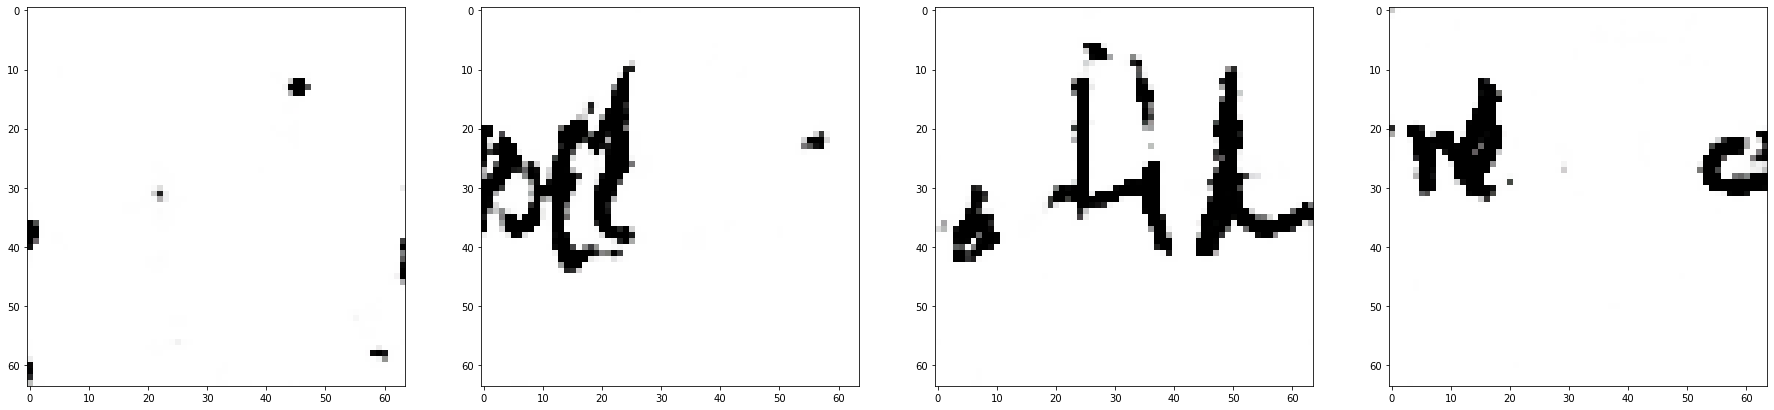

n_iter : 15025/46000, loss = 32281.432656250, time_since: 12644.56
n_iter : 15050/46000, loss = 33014.774062500, time_since: 12666.97
n_iter : 15075/46000, loss = 33485.920781250, time_since: 12685.23
n_iter : 15100/46000, loss = 33052.015781250, time_since: 12706.87
n_iter : 15125/46000, loss = 32996.712187500, time_since: 12724.98
n_iter : 15150/46000, loss = 32237.052890625, time_since: 12747.12
n_iter : 15175/46000, loss = 32505.492109375, time_since: 12764.91
n_iter : 15200/46000, loss = 31734.588750000, time_since: 12786.76
n_iter : 15225/46000, loss = 32368.377734375, time_since: 12804.86
n_iter : 15250/46000, loss = 32160.574843750, time_since: 12827.49


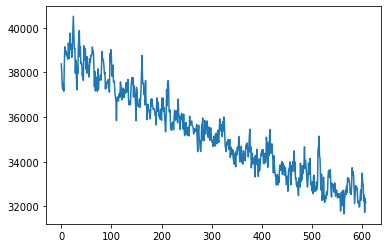

Validation


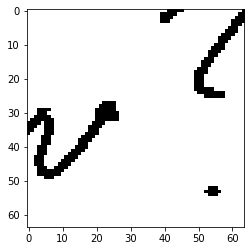

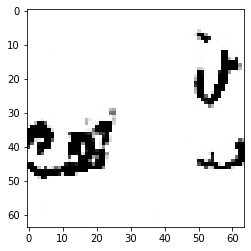

validation loss: 40521.58984375
Random


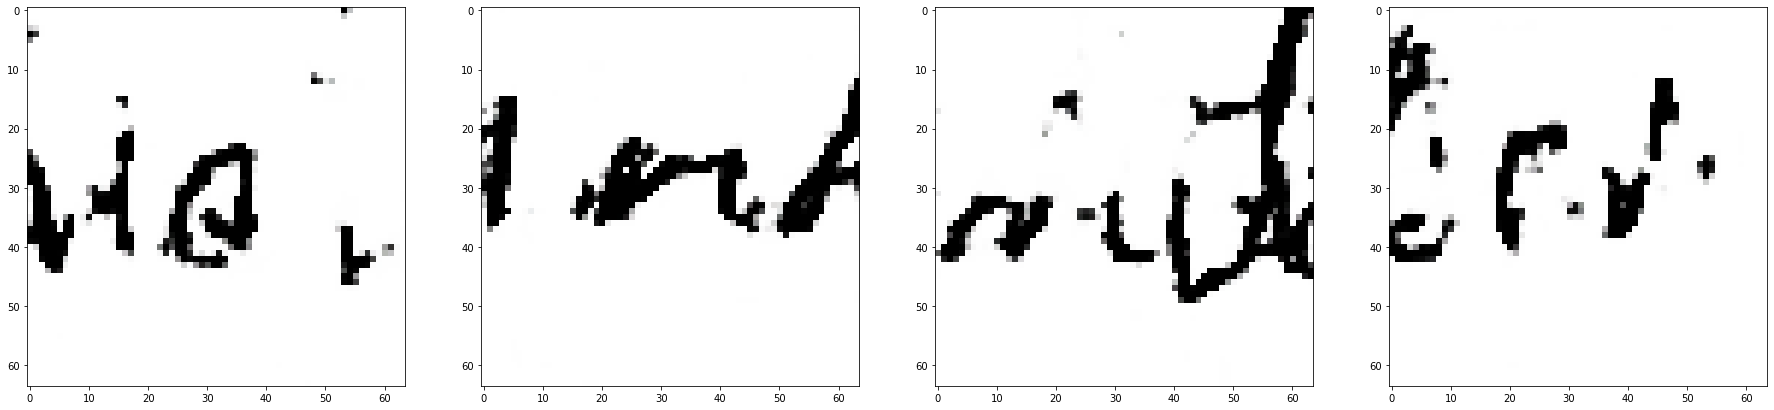

n_iter : 15275/46000, loss = 31857.416250000, time_since: 12848.52
n_iter : 15300/46000, loss = 32035.174609375, time_since: 12869.78
n_iter : 15325/46000, loss = 32390.582187500, time_since: 12892.79
n_iter : 15350/46000, loss = 32366.708906250, time_since: 12914.17
n_iter : 15375/46000, loss = 32069.326406250, time_since: 12937.22
n_iter : 15400/46000, loss = 32486.988046875, time_since: 12958.06
n_iter : 15425/46000, loss = 32612.301015625, time_since: 12981.19
n_iter : 15450/46000, loss = 32708.193984375, time_since: 13001.70
n_iter : 15475/46000, loss = 32508.337265625, time_since: 13024.70
n_iter : 15500/46000, loss = 31934.332812500, time_since: 13045.06


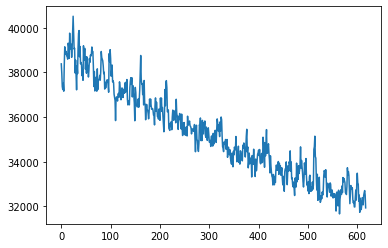

Validation


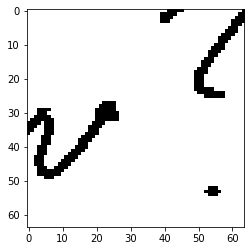

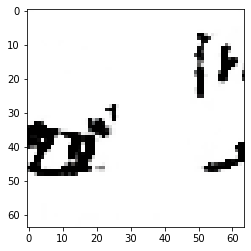

validation loss: 36867.15234375
Random


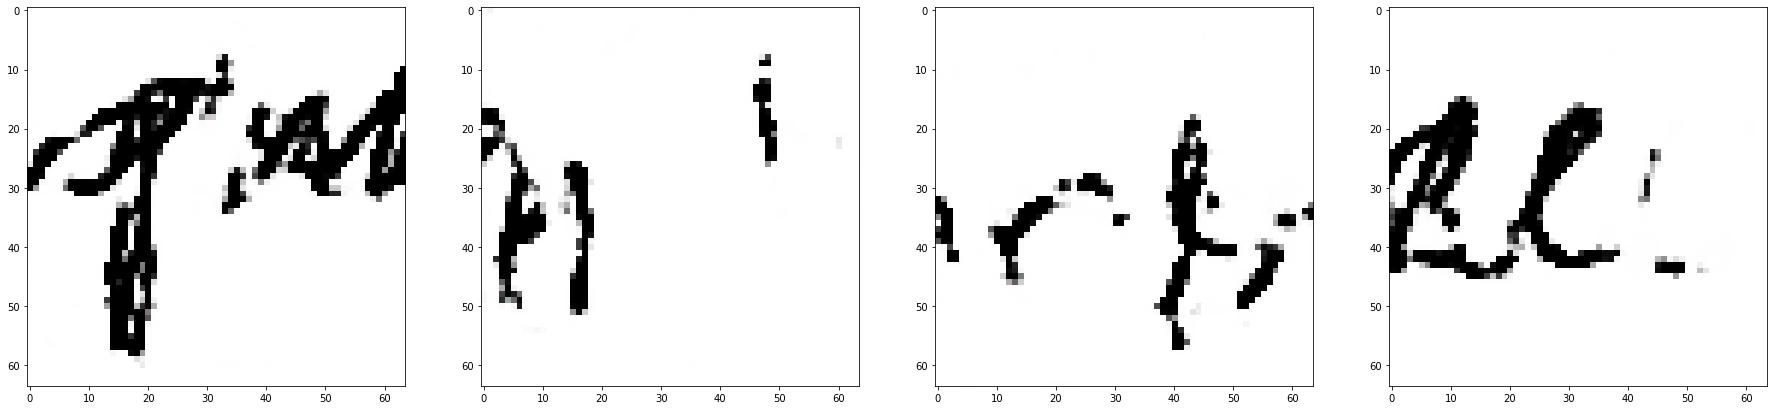

n_iter : 15525/46000, loss = 32153.314921875, time_since: 13067.97
n_iter : 15550/46000, loss = 31885.822187500, time_since: 13090.47
n_iter : 15575/46000, loss = 32377.902812500, time_since: 13108.29
n_iter : 15600/46000, loss = 32320.697500000, time_since: 13130.49
n_iter : 15625/46000, loss = 32428.657187500, time_since: 13148.46
n_iter : 15650/46000, loss = 32164.363750000, time_since: 13170.54
n_iter : 15675/46000, loss = 32067.615156250, time_since: 13188.58
n_iter : 15700/46000, loss = 32357.532031250, time_since: 13210.53
n_iter : 15725/46000, loss = 31737.441328125, time_since: 13228.61
n_iter : 15750/46000, loss = 31519.453828125, time_since: 13250.66


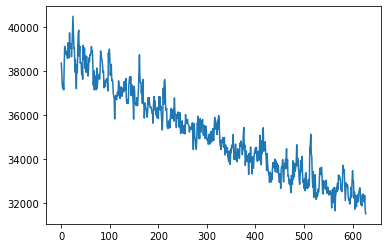

Validation


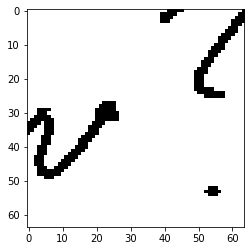

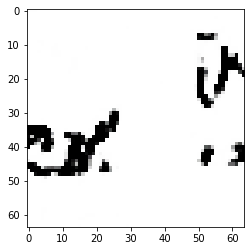

validation loss: 42421.1640625
Random


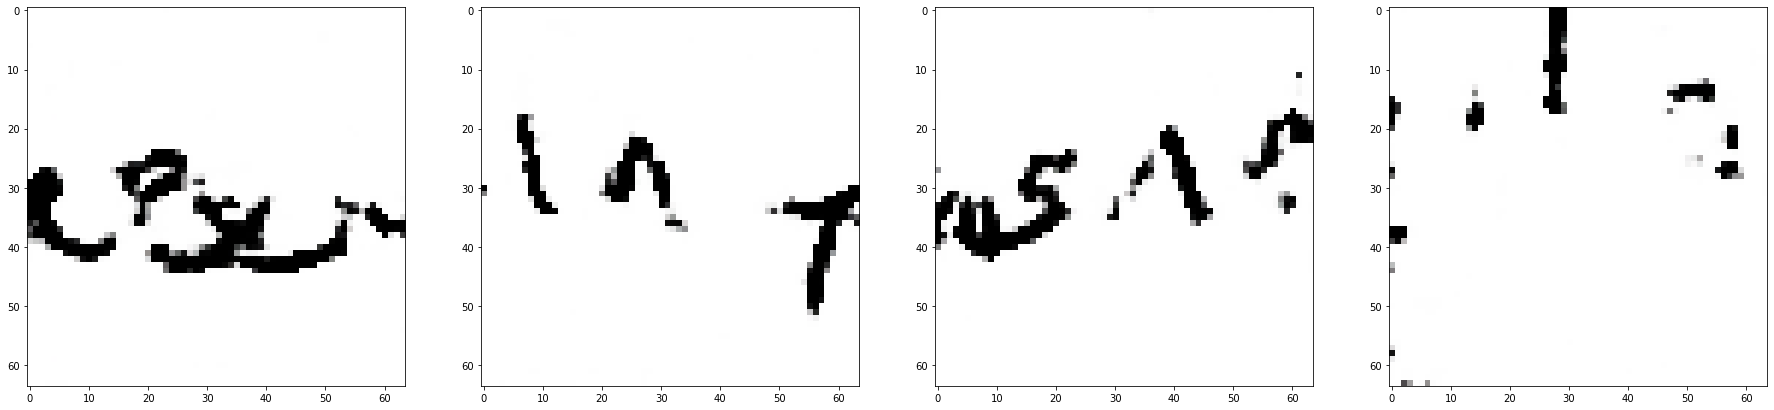

n_iter : 15775/46000, loss = 31974.667500000, time_since: 13269.26
n_iter : 15800/46000, loss = 31829.777421875, time_since: 13292.30
n_iter : 15825/46000, loss = 31627.353125000, time_since: 13316.25
n_iter : 15850/46000, loss = 32341.908593750, time_since: 13335.80
n_iter : 15875/46000, loss = 32174.370390625, time_since: 13359.52
n_iter : 15900/46000, loss = 32079.318046875, time_since: 13380.16
n_iter : 15925/46000, loss = 32007.454296875, time_since: 13403.90
n_iter : 15950/46000, loss = 32515.192734375, time_since: 13424.28
n_iter : 15975/46000, loss = 32537.282578125, time_since: 13447.87
n_iter : 16000/46000, loss = 32663.195546875, time_since: 13468.11


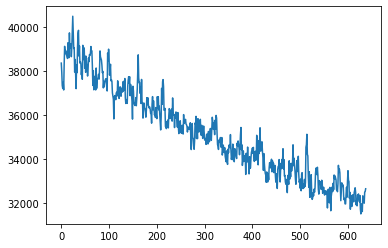

Validation


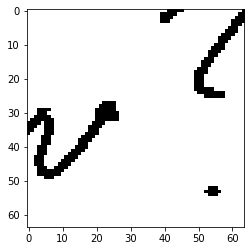

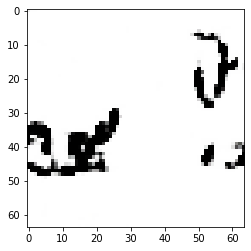

validation loss: 38868.19140625
Random


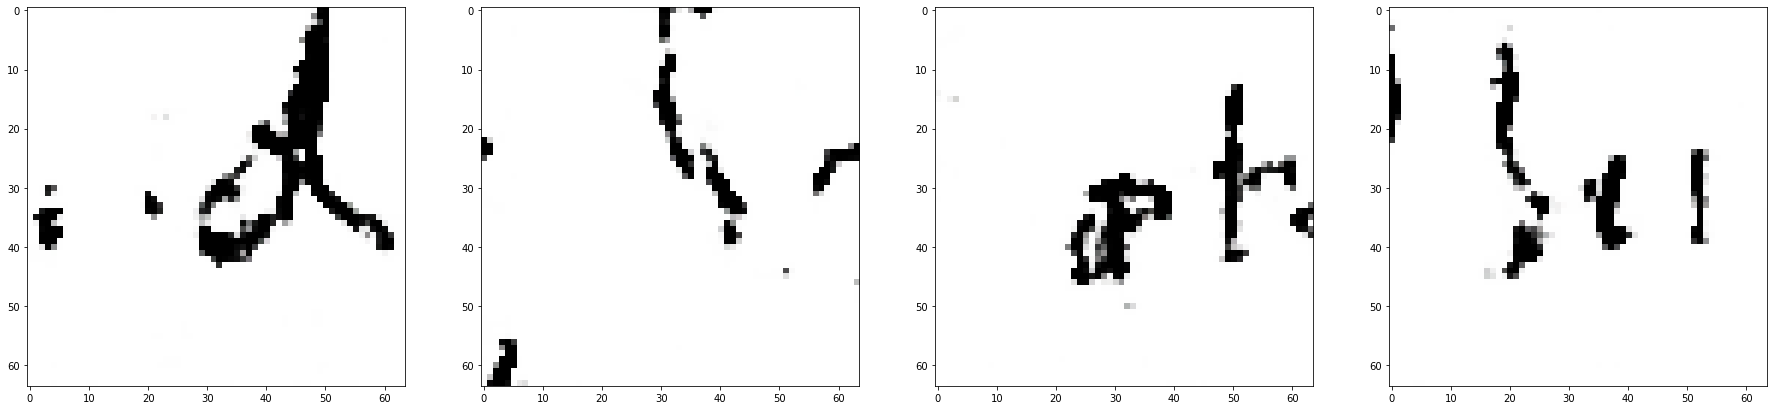

n_iter : 16025/46000, loss = 32331.157031250, time_since: 13490.79
n_iter : 16050/46000, loss = 32702.433281250, time_since: 13508.98
n_iter : 16075/46000, loss = 32416.573671875, time_since: 13531.15
n_iter : 16100/46000, loss = 32589.961875000, time_since: 13553.36
n_iter : 16125/46000, loss = 32627.314218750, time_since: 13571.53
n_iter : 16150/46000, loss = 32769.533281250, time_since: 13593.75
n_iter : 16175/46000, loss = 32797.491015625, time_since: 13611.90
n_iter : 16200/46000, loss = 32134.211484375, time_since: 13633.74
n_iter : 16225/46000, loss = 32635.320390625, time_since: 13651.97
n_iter : 16250/46000, loss = 32186.741718750, time_since: 13674.19


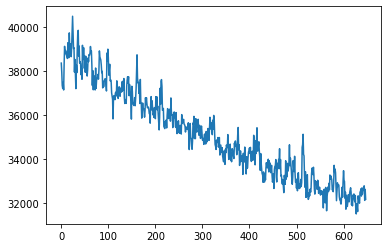

Validation


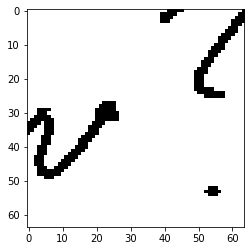

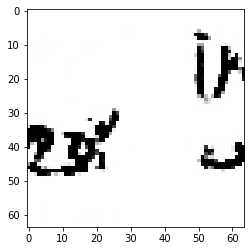

validation loss: 42608.15625
Random


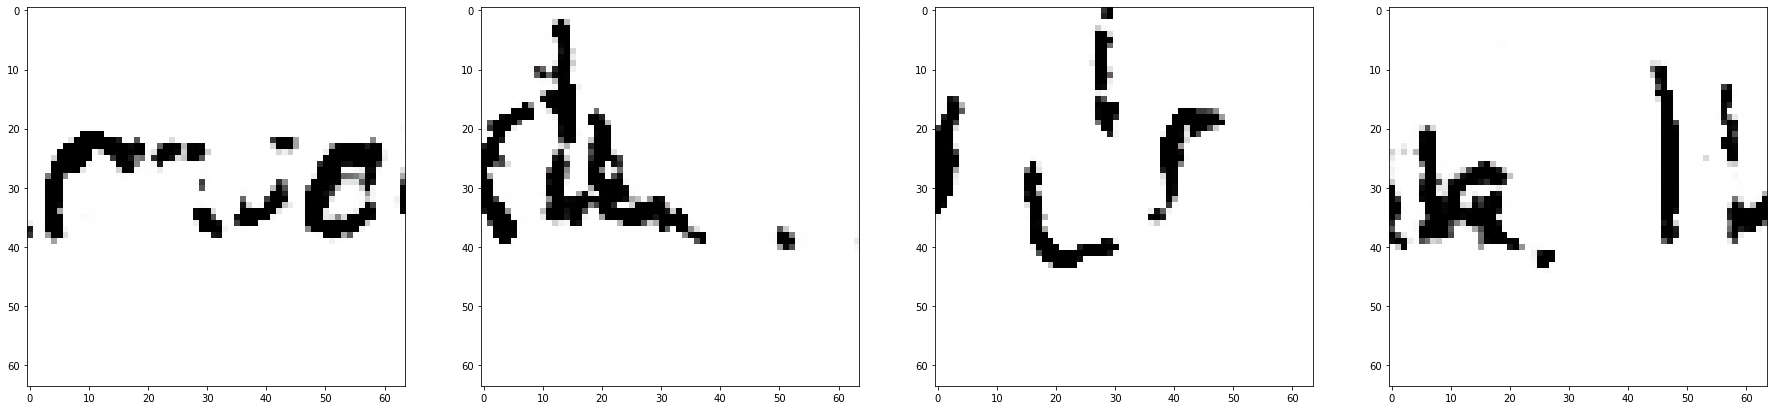

n_iter : 16275/46000, loss = 31936.501562500, time_since: 13692.65
n_iter : 16300/46000, loss = 31780.654843750, time_since: 13715.69
n_iter : 16325/46000, loss = 31981.116406250, time_since: 13735.48
n_iter : 16350/46000, loss = 32079.638281250, time_since: 13759.11
n_iter : 16375/46000, loss = 32179.452031250, time_since: 13779.38
n_iter : 16400/46000, loss = 31860.486015625, time_since: 13804.41
n_iter : 16425/46000, loss = 31714.383125000, time_since: 13826.84
n_iter : 16450/46000, loss = 31726.271015625, time_since: 13847.80
n_iter : 16475/46000, loss = 32163.389687500, time_since: 13870.30
n_iter : 16500/46000, loss = 32077.480390625, time_since: 13892.12


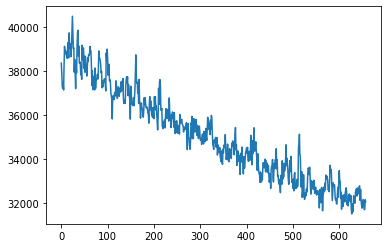

Validation


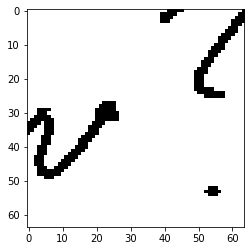

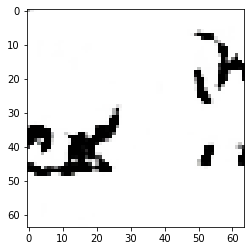

validation loss: 37797.5546875
Random


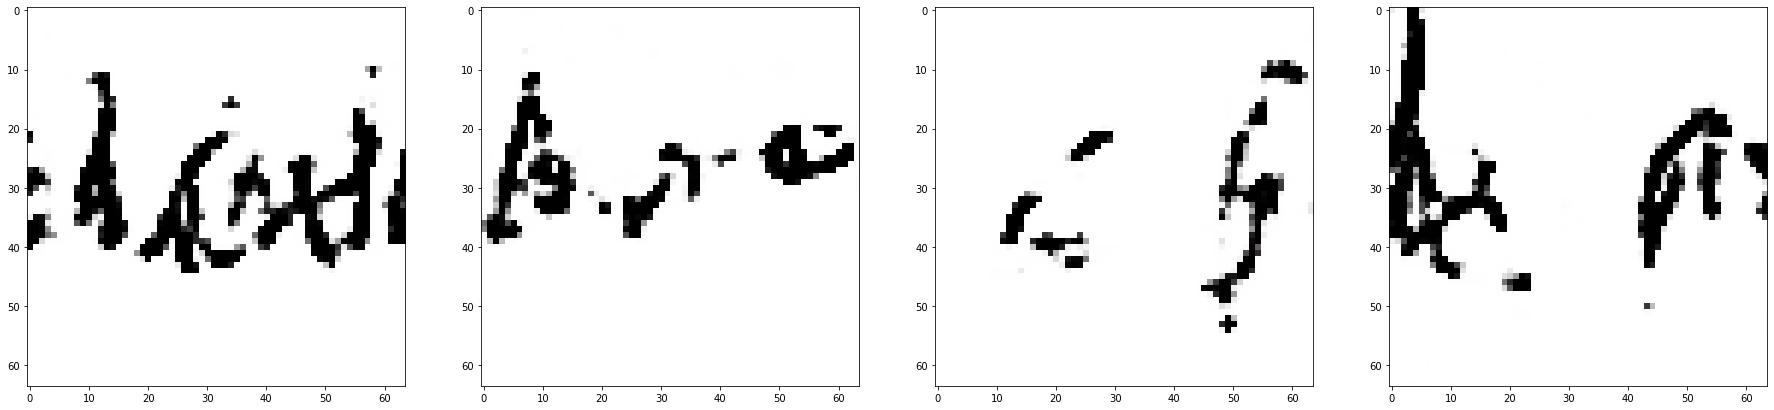

n_iter : 16525/46000, loss = 32272.105781250, time_since: 13914.35
n_iter : 16550/46000, loss = 32593.910000000, time_since: 13933.79
n_iter : 16575/46000, loss = 32165.926250000, time_since: 13955.39
n_iter : 16600/46000, loss = 31936.499218750, time_since: 13974.55
n_iter : 16625/46000, loss = 31537.416015625, time_since: 13999.07
n_iter : 16650/46000, loss = 31905.739921875, time_since: 14020.33
n_iter : 16675/46000, loss = 31642.527187500, time_since: 14044.24
n_iter : 16700/46000, loss = 31539.041640625, time_since: 14069.86
n_iter : 16725/46000, loss = 31588.443359375, time_since: 14091.15
n_iter : 16750/46000, loss = 31392.928750000, time_since: 14116.07


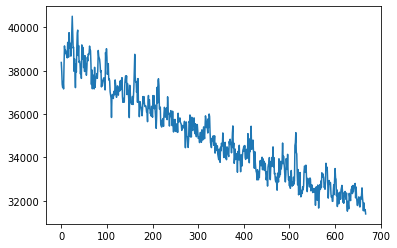

Validation


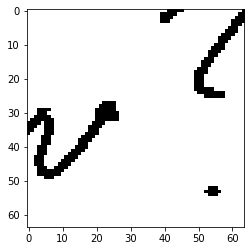

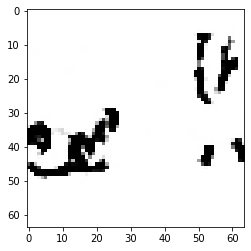

validation loss: 36188.58984375
Random


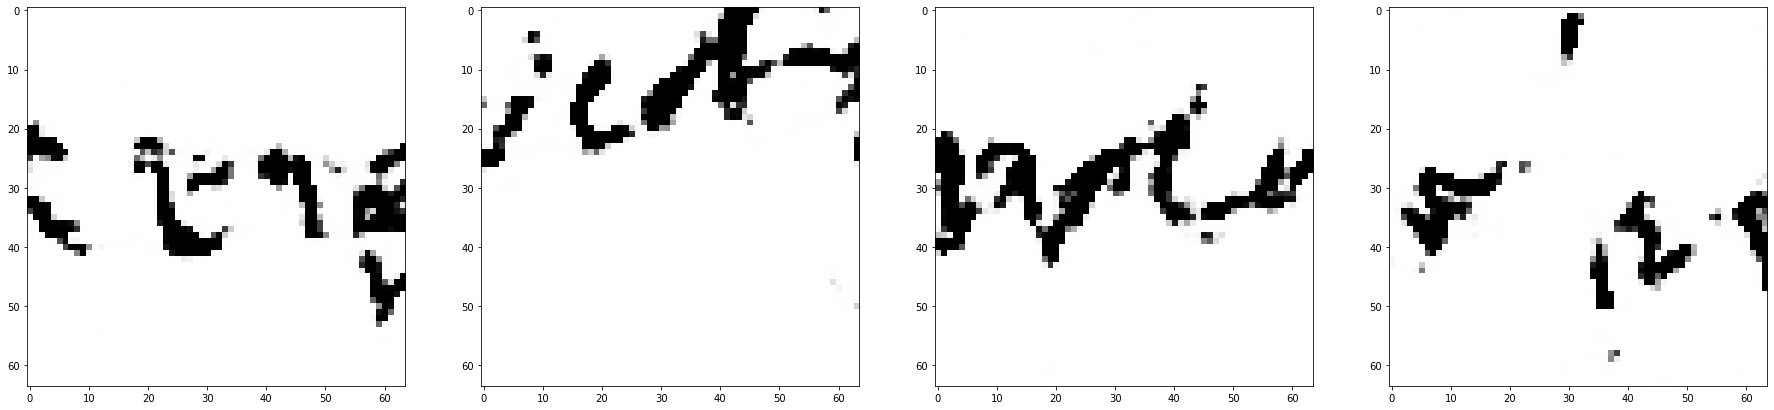

n_iter : 16775/46000, loss = 31616.600546875, time_since: 14136.12
n_iter : 16800/46000, loss = 31523.676250000, time_since: 14159.87
n_iter : 16825/46000, loss = 32135.627656250, time_since: 14180.29
n_iter : 16850/46000, loss = 31971.143671875, time_since: 14205.18
n_iter : 16875/46000, loss = 31718.497265625, time_since: 14226.79
n_iter : 16900/46000, loss = 31388.032187500, time_since: 14250.28
n_iter : 16925/46000, loss = 31741.772187500, time_since: 14272.61
n_iter : 16950/46000, loss = 31559.351875000, time_since: 14296.91
n_iter : 16975/46000, loss = 31767.563046875, time_since: 14322.33
n_iter : 17000/46000, loss = 31762.921093750, time_since: 14343.95


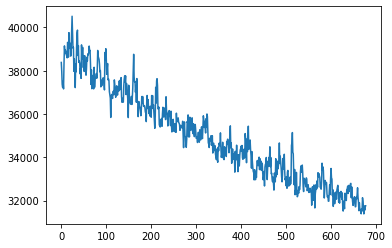

Validation


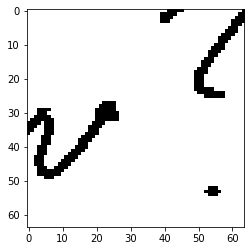

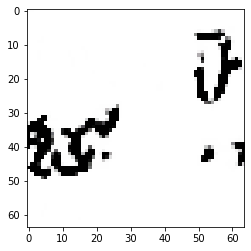

validation loss: 32805.984375
Random


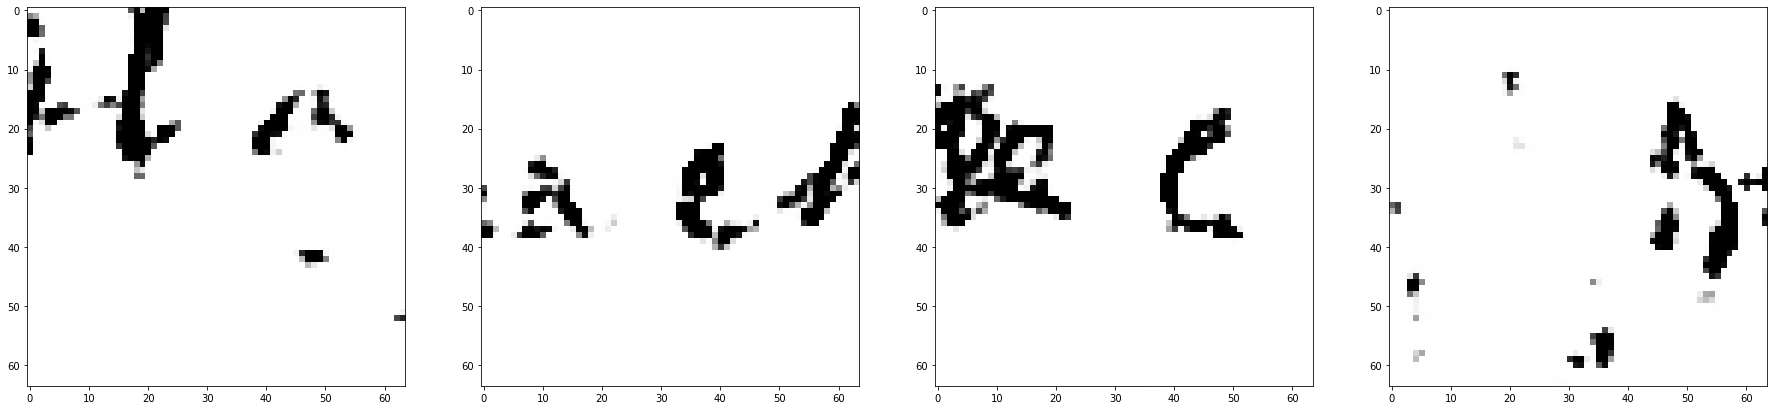

n_iter : 17025/46000, loss = 31941.152265625, time_since: 14370.04
n_iter : 17050/46000, loss = 31400.721796875, time_since: 14392.52
n_iter : 17075/46000, loss = 31609.506250000, time_since: 14417.75
n_iter : 17100/46000, loss = 31776.749687500, time_since: 14438.99
n_iter : 17125/46000, loss = 31620.278593750, time_since: 14463.61
n_iter : 17150/46000, loss = 31695.217421875, time_since: 14483.72
n_iter : 17175/46000, loss = 31644.077500000, time_since: 14510.09
n_iter : 17200/46000, loss = 31931.411640625, time_since: 14530.36
n_iter : 17225/46000, loss = 31694.844140625, time_since: 14554.94
n_iter : 17250/46000, loss = 32095.603437500, time_since: 14580.81


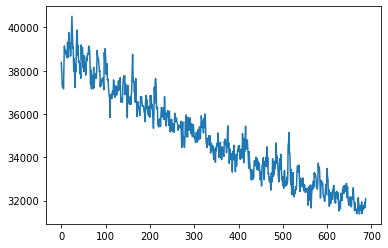

Validation


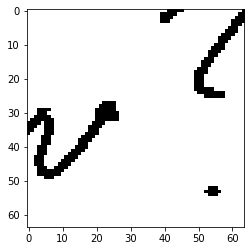

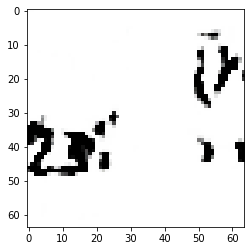

validation loss: 35494.00390625
Random


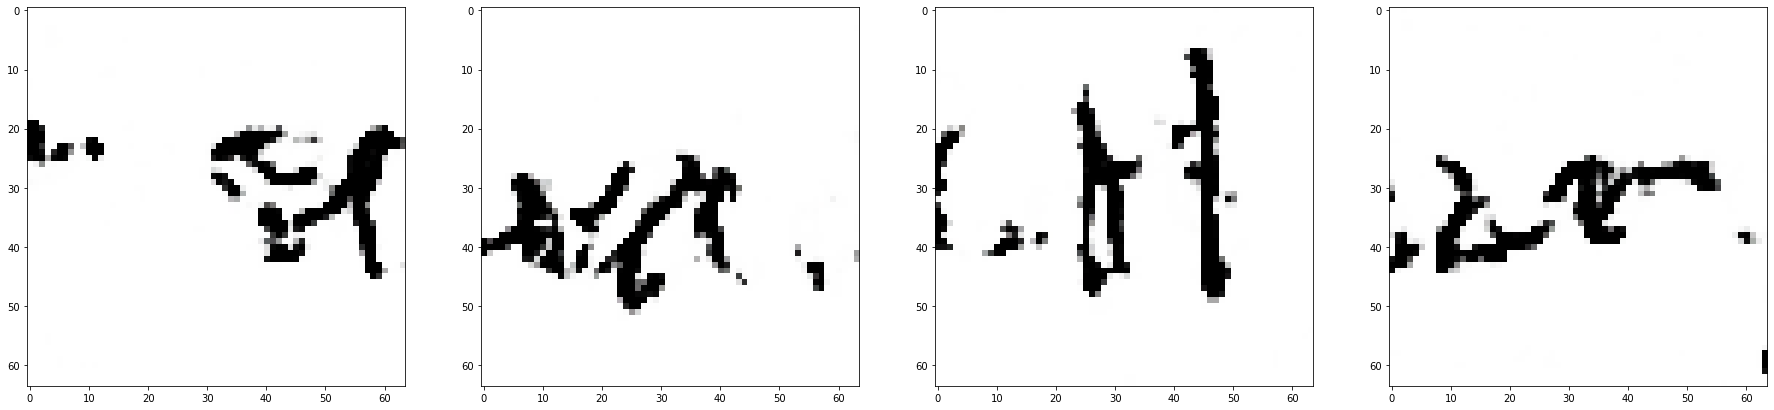

n_iter : 17275/46000, loss = 31931.618203125, time_since: 14602.17
n_iter : 17300/46000, loss = 31824.919140625, time_since: 14626.54
n_iter : 17325/46000, loss = 31947.911250000, time_since: 14649.32
n_iter : 17350/46000, loss = 32158.157578125, time_since: 14677.28
n_iter : 17375/46000, loss = 31962.004062500, time_since: 14701.13
n_iter : 17400/46000, loss = 31560.986718750, time_since: 14729.51
n_iter : 17425/46000, loss = 31609.338671875, time_since: 14752.17
n_iter : 17450/46000, loss = 31423.245937500, time_since: 14778.76
n_iter : 17475/46000, loss = 31795.633906250, time_since: 14800.97
n_iter : 17500/46000, loss = 31669.373125000, time_since: 14828.72


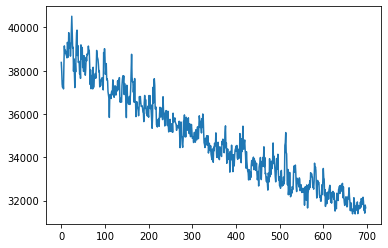

Validation


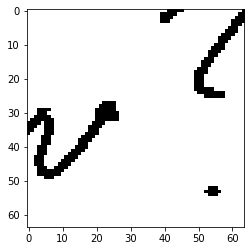

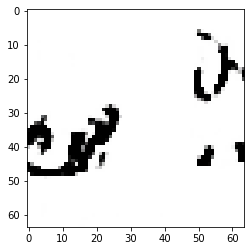

validation loss: 35175.1484375
Random


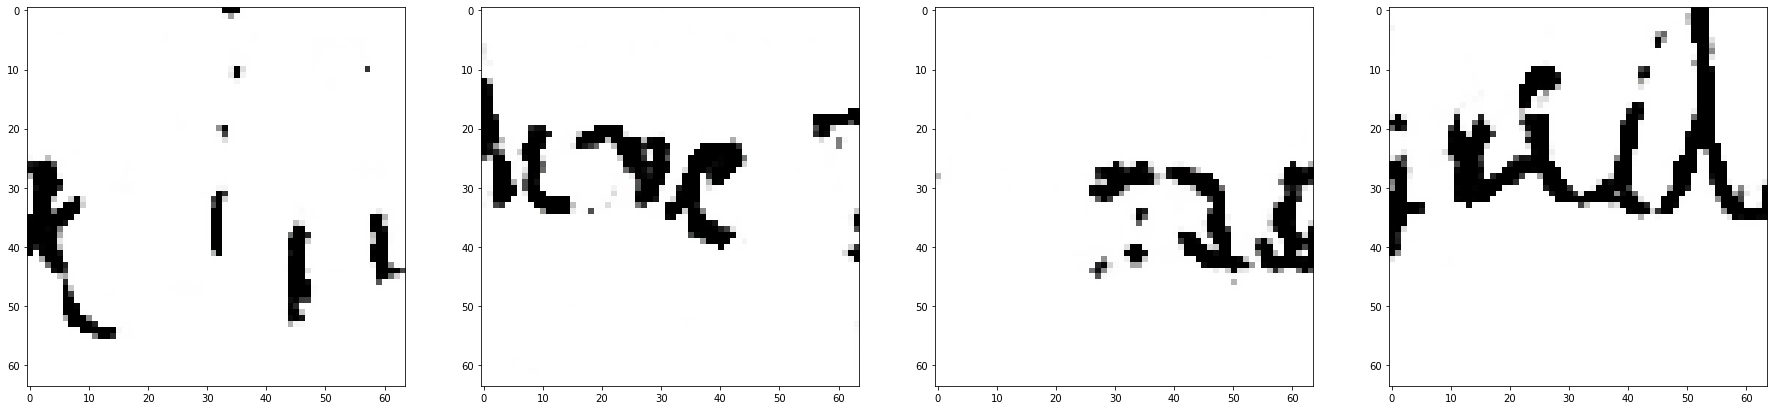

n_iter : 17525/46000, loss = 32187.752109375, time_since: 14852.00
n_iter : 17550/46000, loss = 32091.685546875, time_since: 14876.71
n_iter : 17575/46000, loss = 32641.909609375, time_since: 14902.58
n_iter : 17600/46000, loss = 32538.819531250, time_since: 14923.06
n_iter : 17625/46000, loss = 32183.309531250, time_since: 14949.17
n_iter : 17650/46000, loss = 31956.863046875, time_since: 14969.74
n_iter : 17675/46000, loss = 32082.626640625, time_since: 14994.08
n_iter : 17700/46000, loss = 31565.447421875, time_since: 15014.64
n_iter : 17725/46000, loss = 31512.198046875, time_since: 15040.43
n_iter : 17750/46000, loss = 31794.387109375, time_since: 15061.59


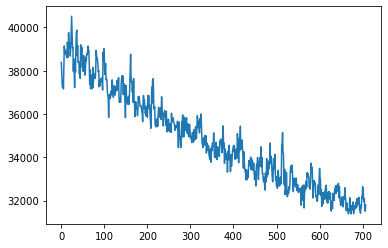

Validation


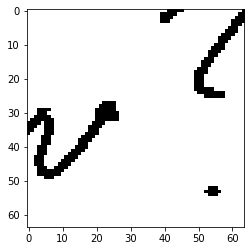

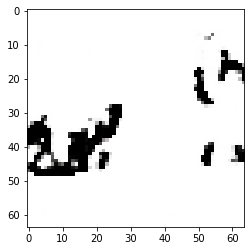

validation loss: 38265.078125
Random


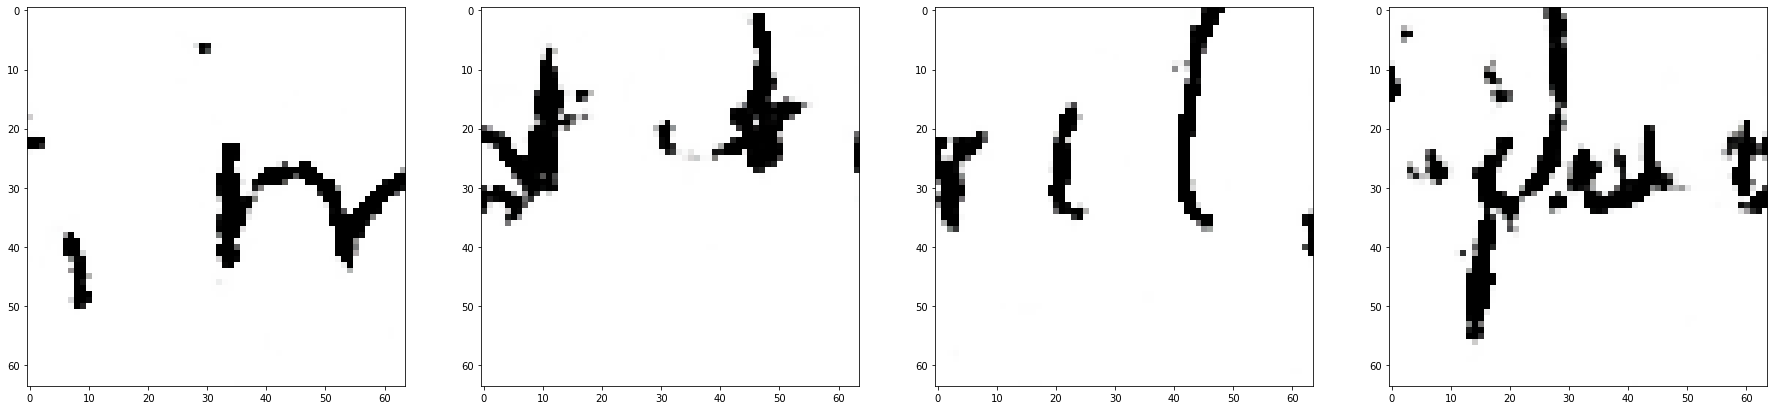

n_iter : 17775/46000, loss = 31241.647578125, time_since: 15087.73
n_iter : 17800/46000, loss = 31452.219843750, time_since: 15111.87
n_iter : 17825/46000, loss = 31390.349218750, time_since: 15137.19
n_iter : 17850/46000, loss = 31554.375468750, time_since: 15164.35
n_iter : 17875/46000, loss = 31692.890468750, time_since: 15186.91
n_iter : 17900/46000, loss = 31693.065625000, time_since: 15213.15
n_iter : 17925/46000, loss = 31962.691484375, time_since: 15235.91
n_iter : 17950/46000, loss = 31694.204765625, time_since: 15264.73
n_iter : 17975/46000, loss = 32116.380546875, time_since: 15288.38
n_iter : 18000/46000, loss = 31301.637343750, time_since: 15317.42


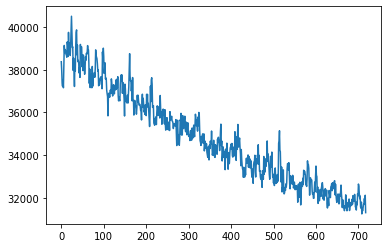

Validation


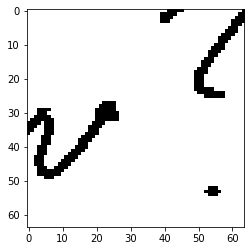

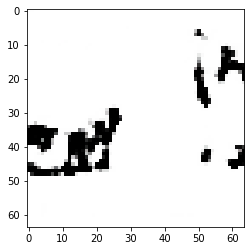

validation loss: 41793.71484375
Random


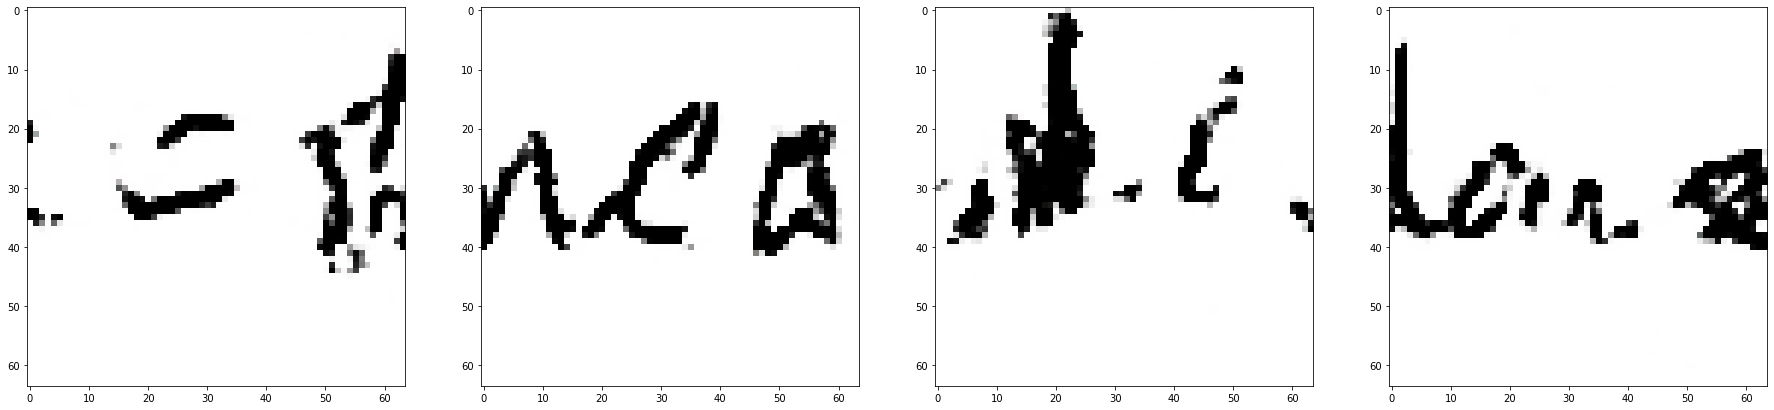

n_iter : 18025/46000, loss = 31446.561640625, time_since: 15339.56
n_iter : 18050/46000, loss = 31671.162187500, time_since: 15365.53
n_iter : 18075/46000, loss = 31972.393671875, time_since: 15385.98
n_iter : 18100/46000, loss = 31481.866406250, time_since: 15412.90
n_iter : 18125/46000, loss = 31345.650937500, time_since: 15436.97
n_iter : 18150/46000, loss = 31367.827812500, time_since: 15458.66
n_iter : 18175/46000, loss = 31103.147656250, time_since: 15483.59
n_iter : 18200/46000, loss = 30804.056640625, time_since: 15504.33
n_iter : 18225/46000, loss = 30872.117578125, time_since: 15529.81
n_iter : 18250/46000, loss = 31549.402890625, time_since: 15550.16


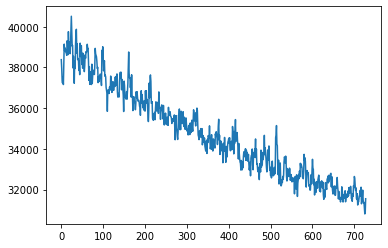

Validation


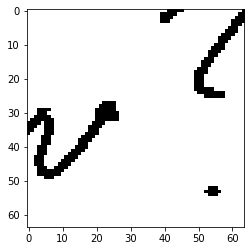

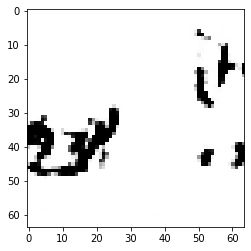

validation loss: 37245.1328125
Random


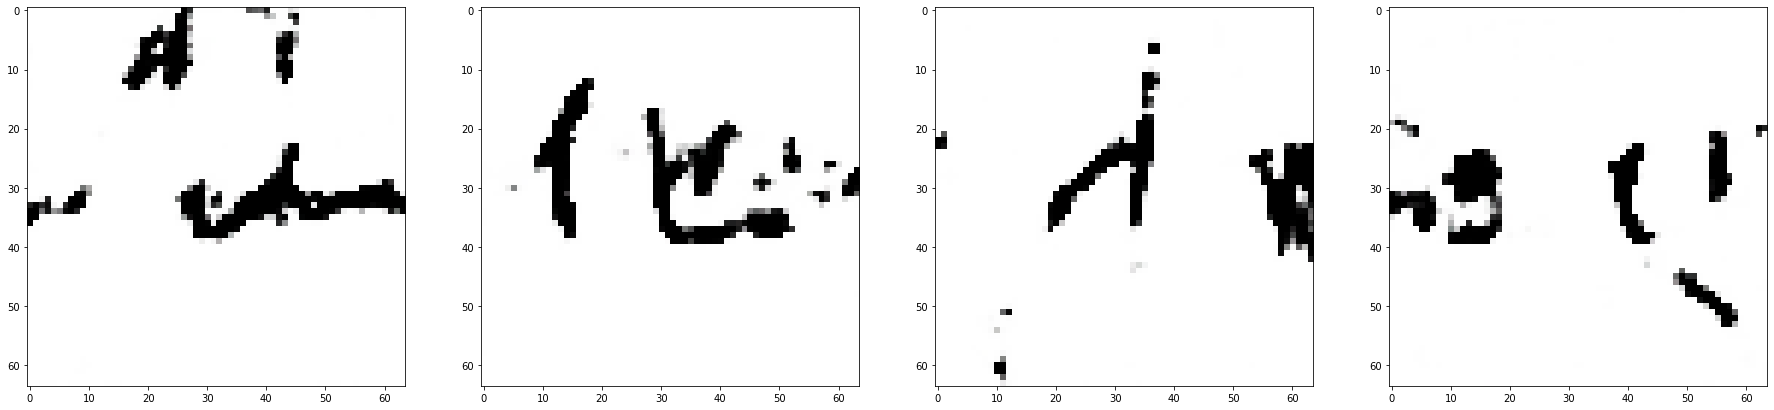

n_iter : 18275/46000, loss = 31370.423125000, time_since: 15576.72
n_iter : 18300/46000, loss = 31259.366875000, time_since: 15598.26
n_iter : 18325/46000, loss = 31156.179296875, time_since: 15626.16
n_iter : 18350/46000, loss = 31558.433046875, time_since: 15648.86
n_iter : 18375/46000, loss = 31369.864375000, time_since: 15675.55
n_iter : 18400/46000, loss = 31720.069453125, time_since: 15702.77
n_iter : 18425/46000, loss = 31206.259531250, time_since: 15726.25
n_iter : 18450/46000, loss = 32372.836640625, time_since: 15753.11
n_iter : 18475/46000, loss = 32539.690078125, time_since: 15777.37
n_iter : 18500/46000, loss = 31976.832578125, time_since: 15804.78


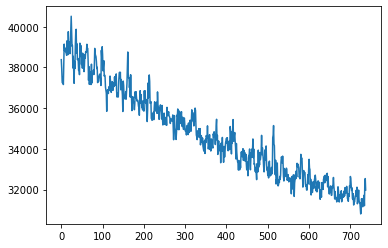

Validation


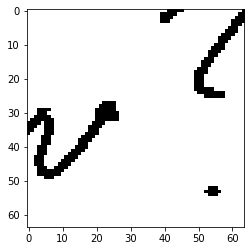

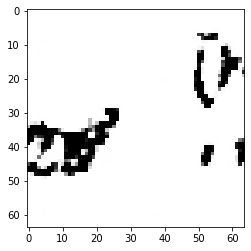

validation loss: 39245.99609375
Random


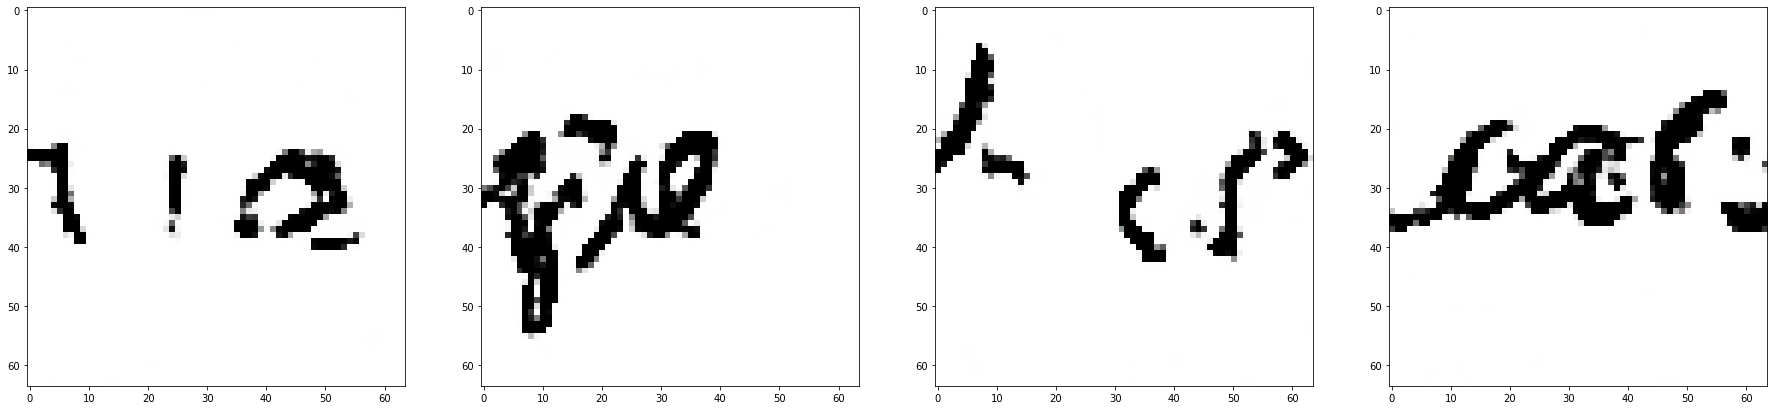

n_iter : 18525/46000, loss = 31888.701484375, time_since: 15829.16
n_iter : 18550/46000, loss = 31631.642265625, time_since: 15855.05
n_iter : 18575/46000, loss = 31619.030546875, time_since: 15875.78
n_iter : 18600/46000, loss = 31206.461093750, time_since: 15901.93
n_iter : 18625/46000, loss = 30954.165468750, time_since: 15922.43
n_iter : 18650/46000, loss = 30448.338906250, time_since: 15949.86
n_iter : 18675/46000, loss = 30943.676093750, time_since: 15971.23
n_iter : 18700/46000, loss = 31050.472187500, time_since: 15996.42
n_iter : 18725/46000, loss = 31069.786015625, time_since: 16023.07
n_iter : 18750/46000, loss = 31264.455859375, time_since: 16043.93


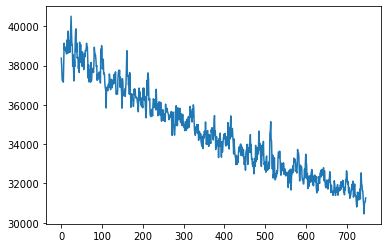

Validation


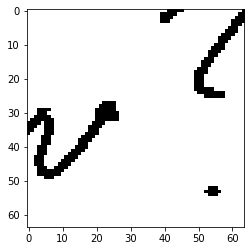

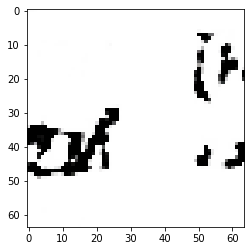

validation loss: 38511.97265625
Random


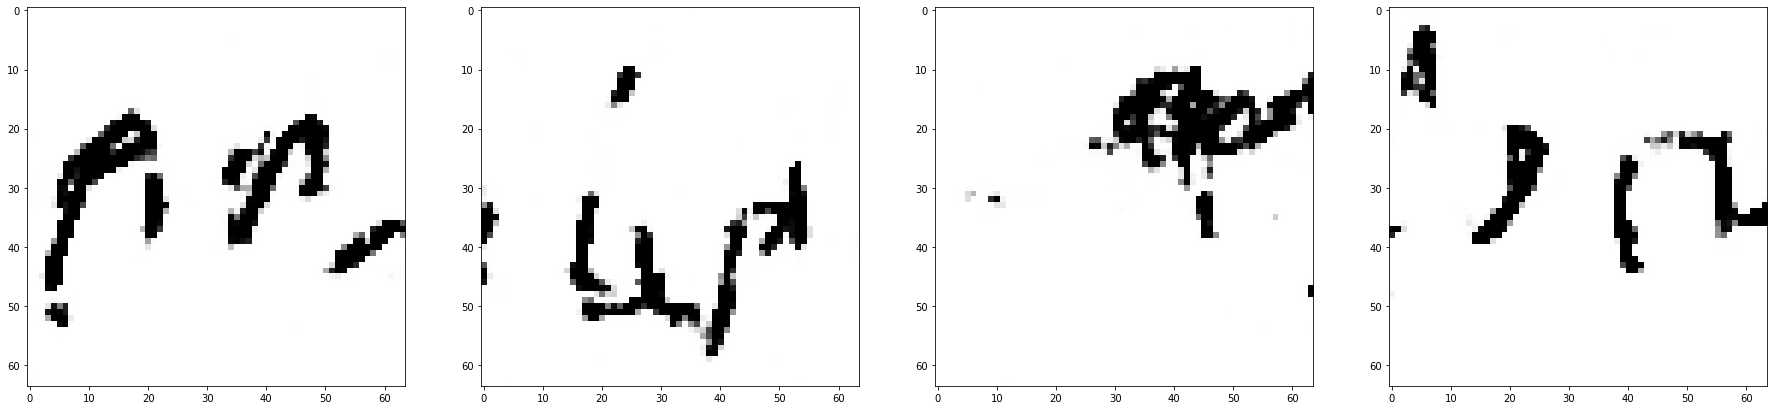

n_iter : 18775/46000, loss = 31256.318437500, time_since: 16067.02
n_iter : 18800/46000, loss = 31399.835000000, time_since: 16090.55
n_iter : 18825/46000, loss = 31199.009843750, time_since: 16118.18
n_iter : 18850/46000, loss = 31388.175859375, time_since: 16144.83
n_iter : 18875/46000, loss = 31268.916015625, time_since: 16170.64
n_iter : 18900/46000, loss = 31113.056171875, time_since: 16195.15
n_iter : 18925/46000, loss = 31162.869140625, time_since: 16223.37
n_iter : 18950/46000, loss = 31606.698359375, time_since: 16249.05
n_iter : 18975/46000, loss = 31220.030000000, time_since: 16275.20
n_iter : 19000/46000, loss = 31675.907812500, time_since: 16301.10


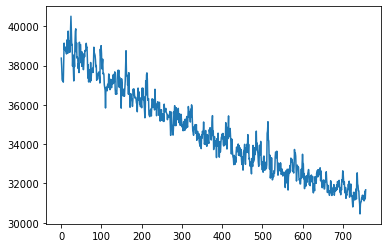

Validation


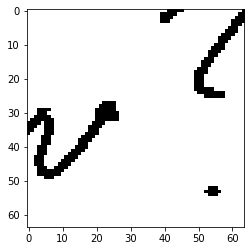

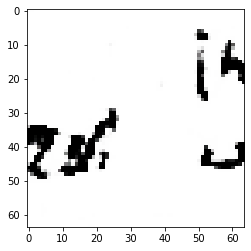

validation loss: 42789.98828125
Random


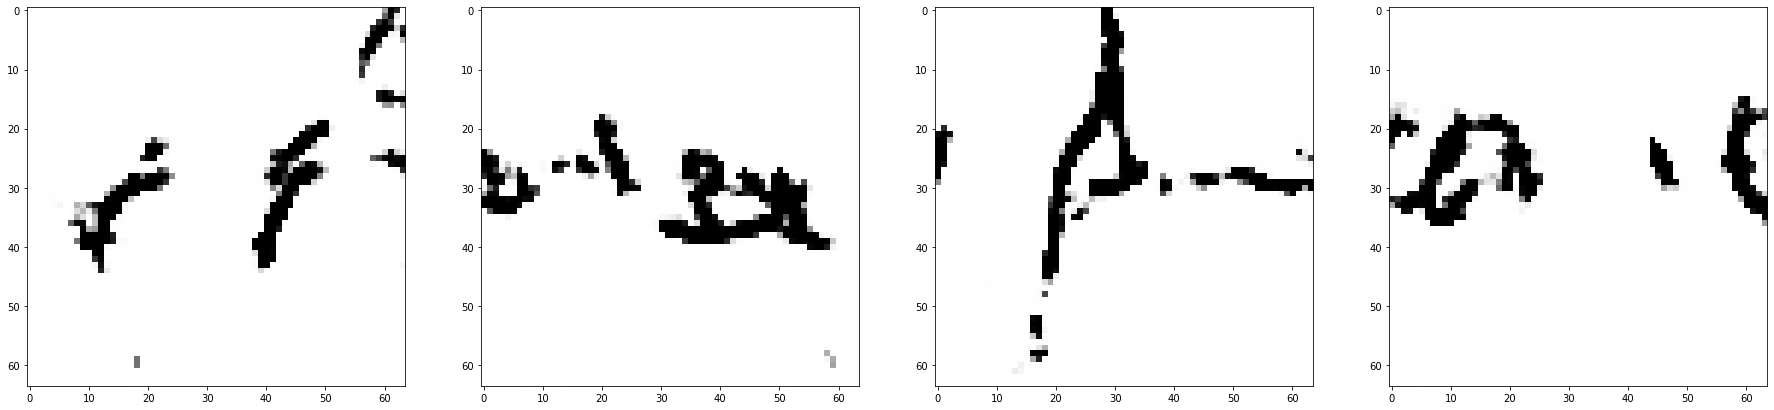

n_iter : 19025/46000, loss = 31461.961015625, time_since: 16324.14
n_iter : 19050/46000, loss = 31532.956250000, time_since: 16351.37
n_iter : 19075/46000, loss = 30937.509843750, time_since: 16371.42
n_iter : 19100/46000, loss = 30835.417656250, time_since: 16397.25
n_iter : 19125/46000, loss = 31102.763125000, time_since: 16417.06
n_iter : 19150/46000, loss = 31052.277187500, time_since: 16441.59
n_iter : 19175/46000, loss = 31514.101093750, time_since: 16464.57
n_iter : 19200/46000, loss = 31104.487109375, time_since: 16490.44
n_iter : 19225/46000, loss = 31424.784609375, time_since: 16511.27
n_iter : 19250/46000, loss = 31450.964687500, time_since: 16535.13


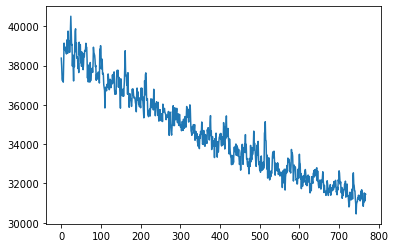

Validation


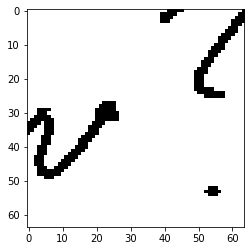

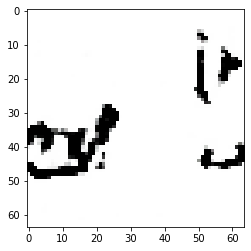

validation loss: 37120.51171875
Random


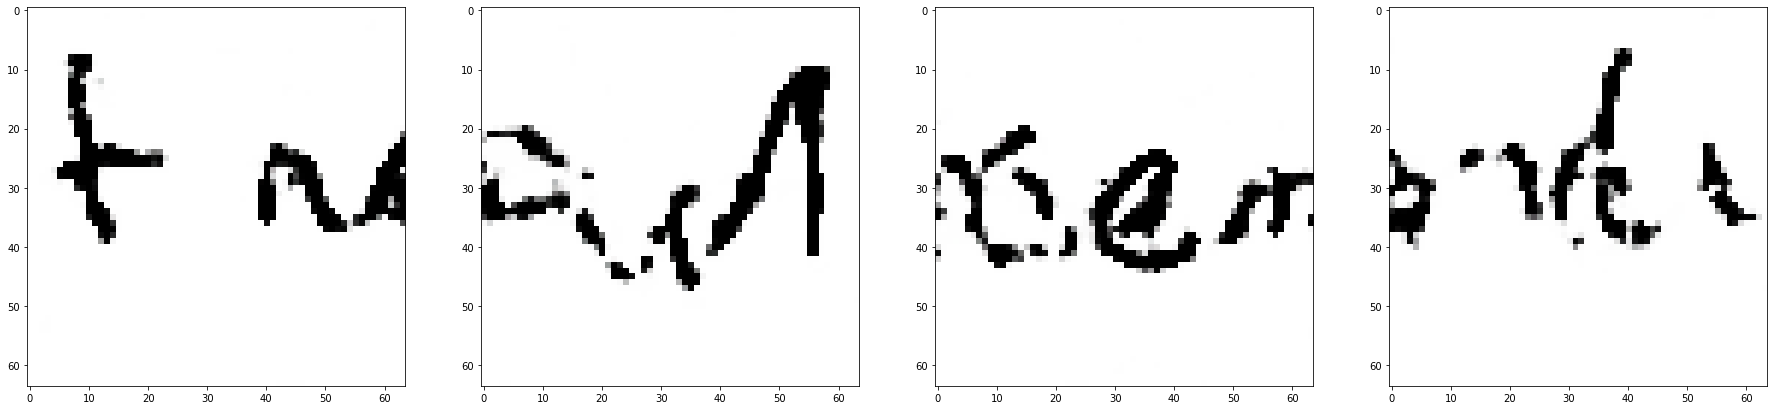

n_iter : 19275/46000, loss = 31014.150859375, time_since: 16560.33
n_iter : 19300/46000, loss = 30860.638828125, time_since: 16581.65
n_iter : 19325/46000, loss = 31082.190312500, time_since: 16606.53
n_iter : 19350/46000, loss = 31599.975000000, time_since: 16629.53
n_iter : 19375/46000, loss = 31382.595156250, time_since: 16653.78
n_iter : 19400/46000, loss = 31144.154062500, time_since: 16674.92
n_iter : 19425/46000, loss = 30727.058984375, time_since: 16698.57
n_iter : 19450/46000, loss = 31202.793671875, time_since: 16721.87
n_iter : 19475/46000, loss = 31283.857656250, time_since: 16746.65
n_iter : 19500/46000, loss = 31209.001250000, time_since: 16768.64


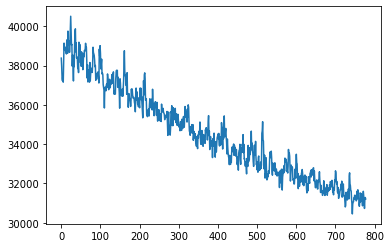

Validation


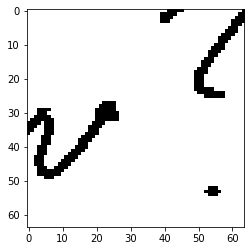

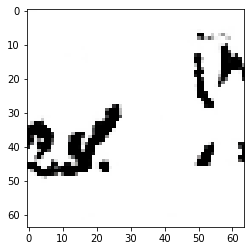

validation loss: 36033.71484375
Random


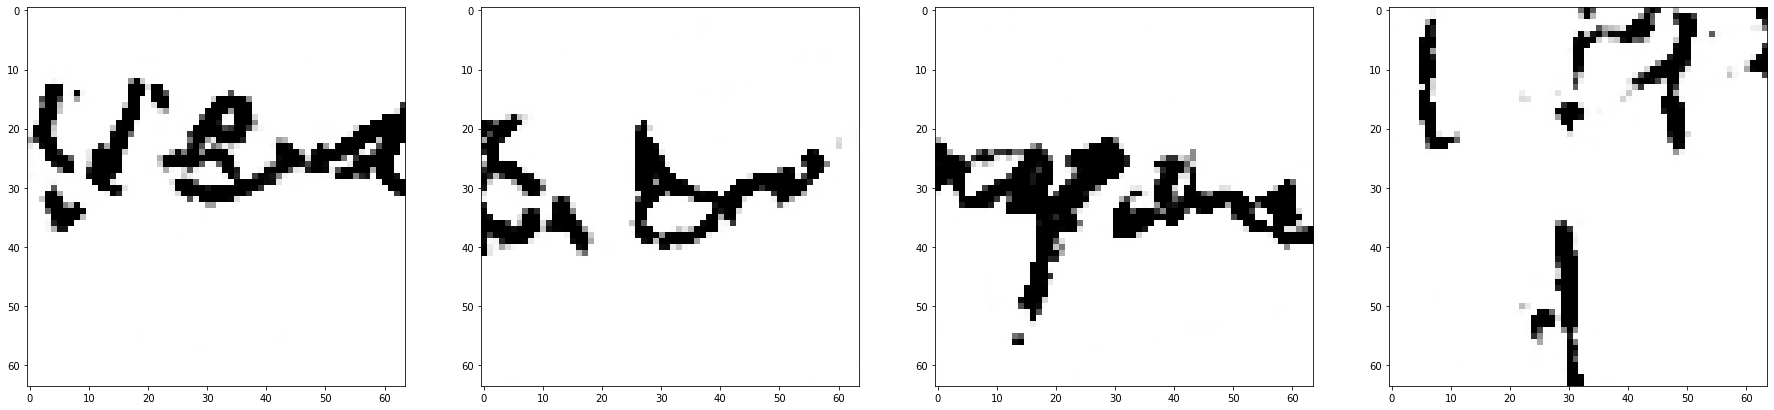

n_iter : 19525/46000, loss = 31608.683671875, time_since: 16797.87
n_iter : 19550/46000, loss = 31364.435781250, time_since: 16823.00
n_iter : 19575/46000, loss = 31144.489218750, time_since: 16845.96
n_iter : 19600/46000, loss = 31090.586640625, time_since: 16872.27
n_iter : 19625/46000, loss = 31600.182734375, time_since: 16895.49
n_iter : 19650/46000, loss = 31755.975546875, time_since: 16921.71
n_iter : 19675/46000, loss = 31444.434843750, time_since: 16945.08
n_iter : 19700/46000, loss = 31873.745390625, time_since: 16970.91
n_iter : 19725/46000, loss = 31619.914921875, time_since: 16994.87
n_iter : 19750/46000, loss = 31840.086640625, time_since: 17023.37


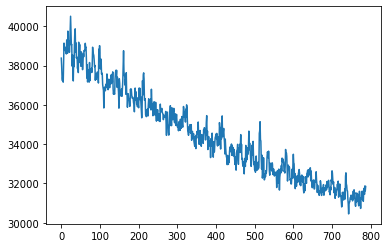

Validation


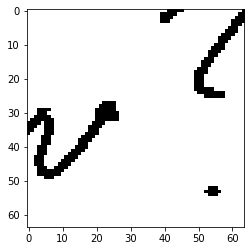

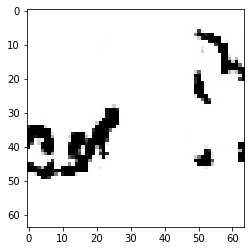

validation loss: 42303.39453125
Random


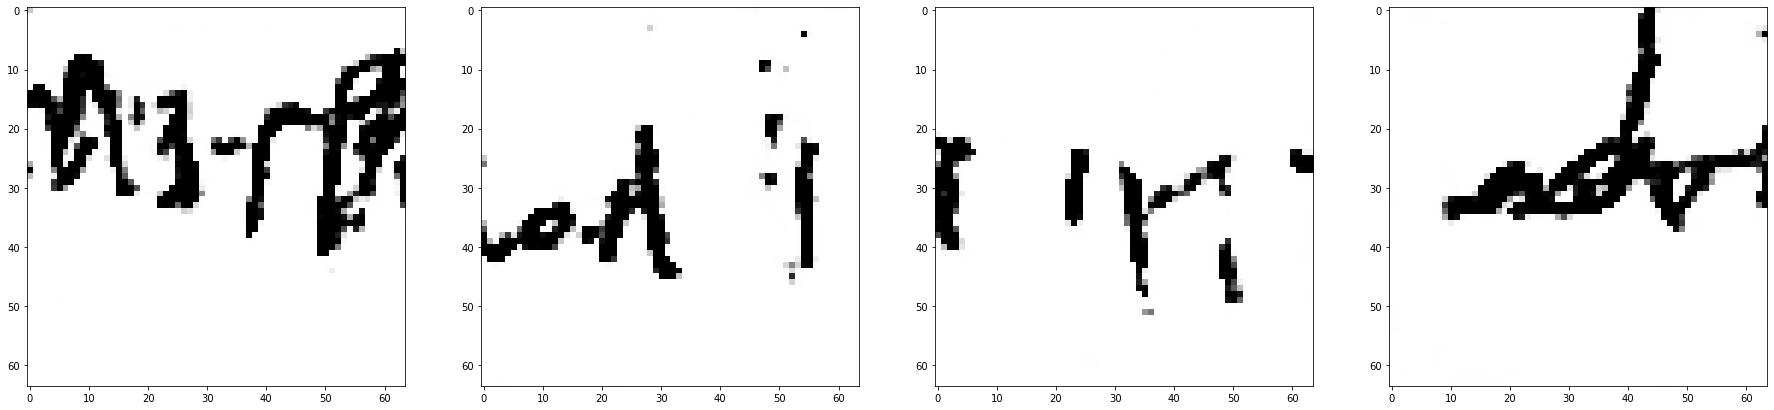

n_iter : 19775/46000, loss = 31376.152812500, time_since: 17045.16
n_iter : 19800/46000, loss = 31538.451640625, time_since: 17069.07
n_iter : 19825/46000, loss = 31051.655468750, time_since: 17088.96
n_iter : 19850/46000, loss = 31332.690546875, time_since: 17114.61
n_iter : 19875/46000, loss = 31033.305234375, time_since: 17139.36
n_iter : 19900/46000, loss = 31030.528671875, time_since: 17160.79
n_iter : 19925/46000, loss = 30946.583984375, time_since: 17185.52
n_iter : 19950/46000, loss = 30607.461015625, time_since: 17207.92
n_iter : 19975/46000, loss = 30446.026328125, time_since: 17231.43
n_iter : 20000/46000, loss = 31244.633125000, time_since: 17252.70


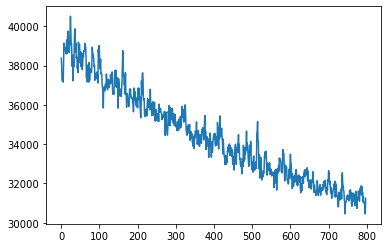

Validation


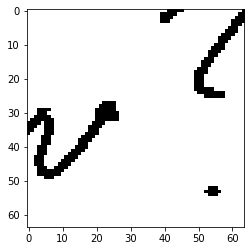

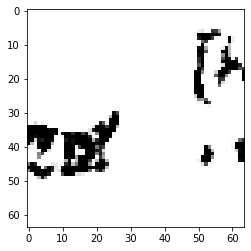

validation loss: 40567.88671875
Random


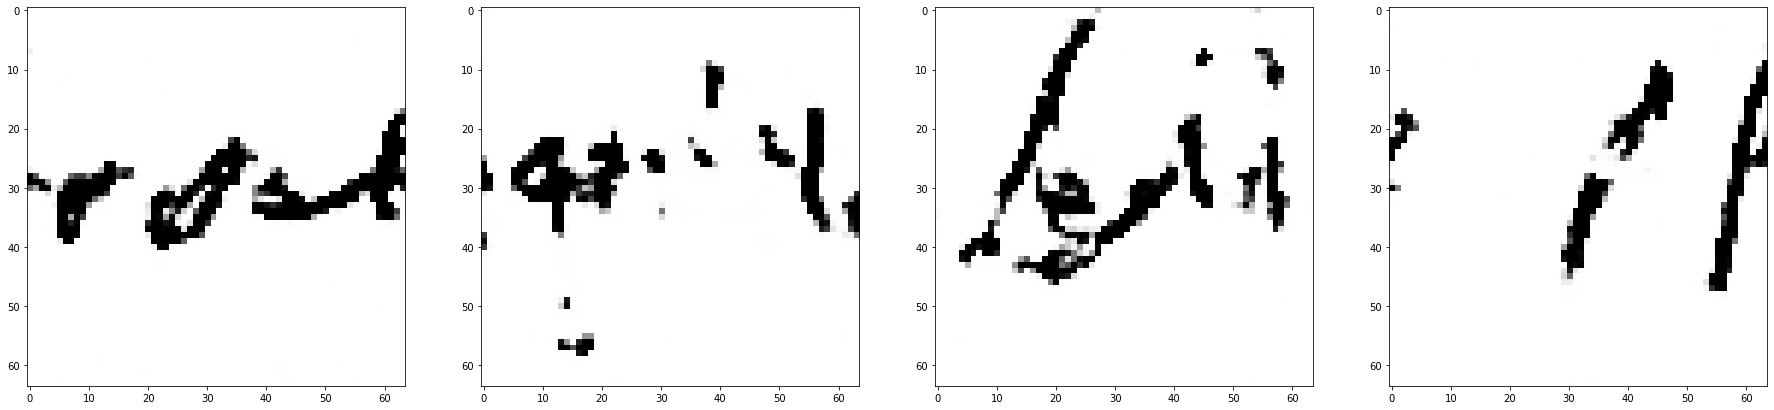

n_iter : 20025/46000, loss = 31185.120781250, time_since: 17276.58
n_iter : 20050/46000, loss = 31428.961171875, time_since: 17301.62
n_iter : 20075/46000, loss = 31381.070000000, time_since: 17326.62
n_iter : 20100/46000, loss = 32192.059921875, time_since: 17349.78
n_iter : 20125/46000, loss = 31588.057421875, time_since: 17375.48
n_iter : 20150/46000, loss = 31482.947187500, time_since: 17403.21
n_iter : 20175/46000, loss = 31777.659765625, time_since: 17424.34
n_iter : 20200/46000, loss = 31189.878515625, time_since: 17452.65
n_iter : 20225/46000, loss = 31369.803203125, time_since: 17475.98
n_iter : 20250/46000, loss = 30366.530390625, time_since: 17503.16


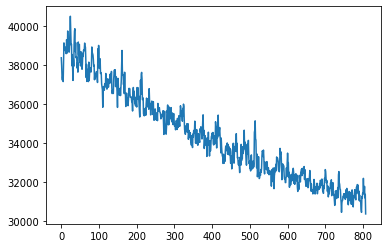

Validation


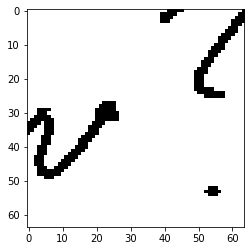

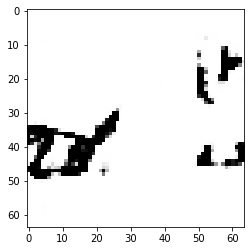

validation loss: 44205.8125
Random


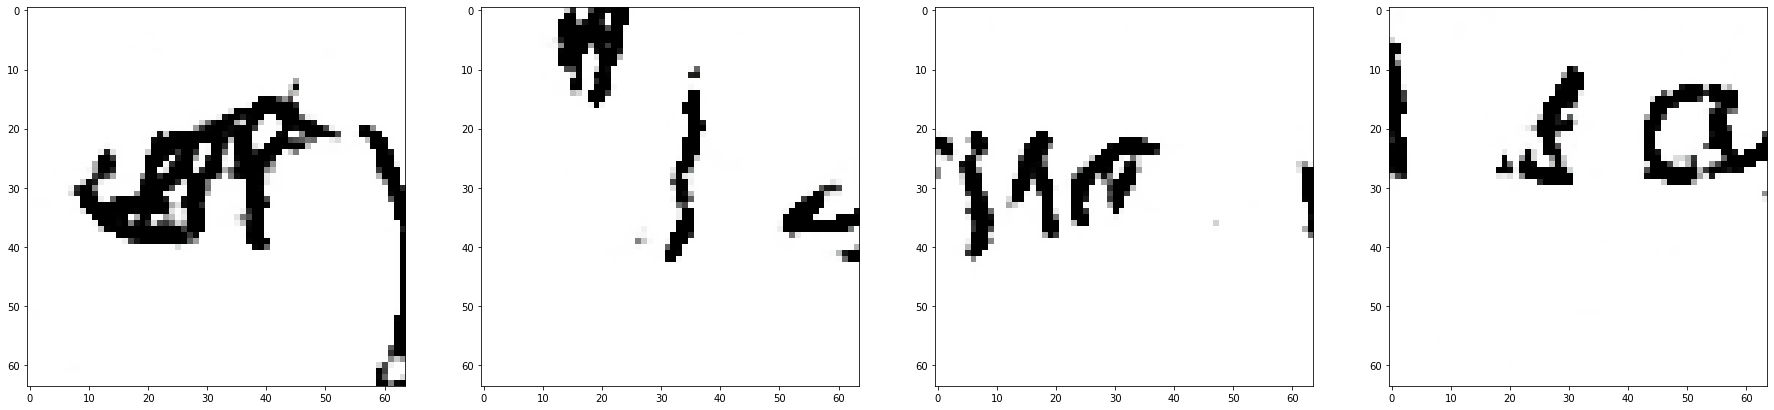

n_iter : 20275/46000, loss = 30872.010234375, time_since: 17526.58
n_iter : 20300/46000, loss = 30959.233750000, time_since: 17552.01
n_iter : 20325/46000, loss = 30645.389453125, time_since: 17574.04
n_iter : 20350/46000, loss = 30445.335468750, time_since: 17599.25
n_iter : 20375/46000, loss = 30650.875859375, time_since: 17619.15
n_iter : 20400/46000, loss = 31462.186562500, time_since: 17644.10
n_iter : 20425/46000, loss = 31262.428593750, time_since: 17668.69
n_iter : 20450/46000, loss = 31223.297187500, time_since: 17690.86
n_iter : 20475/46000, loss = 30931.410390625, time_since: 17716.48
n_iter : 20500/46000, loss = 30855.224375000, time_since: 17736.20


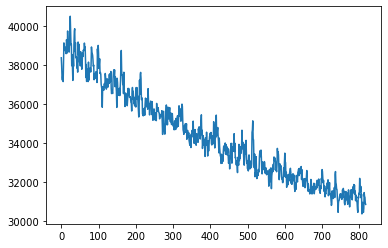

Validation


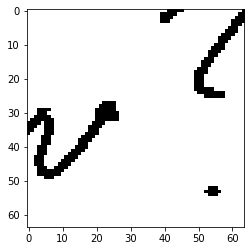

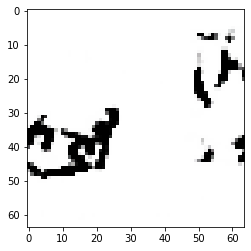

validation loss: 33446.06640625
Random


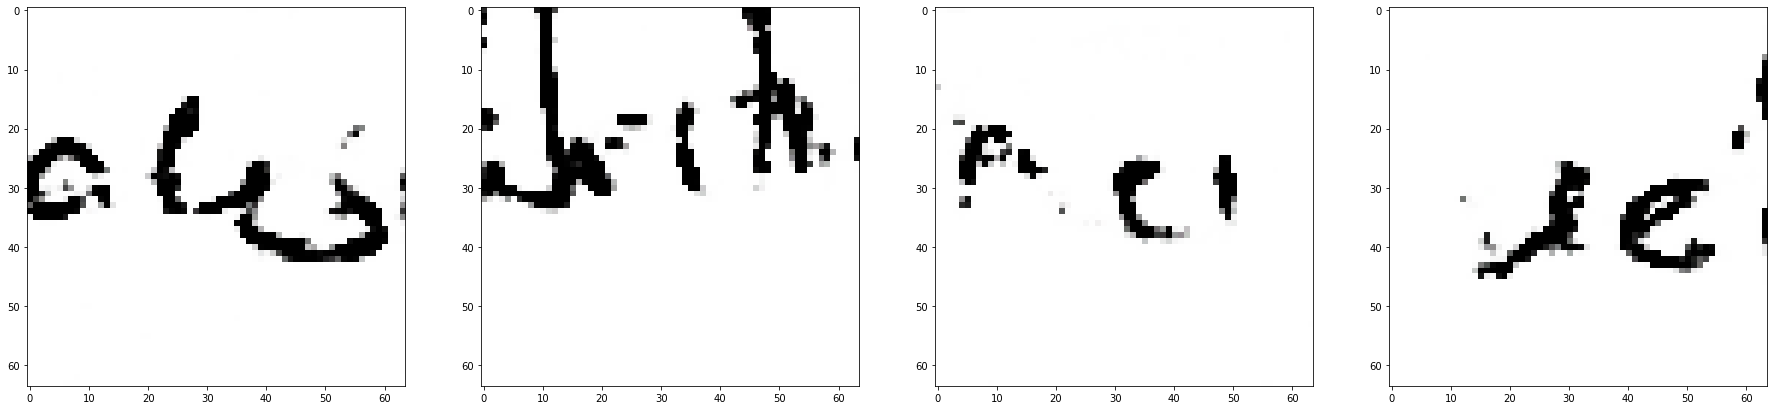

n_iter : 20525/46000, loss = 30720.031484375, time_since: 17760.62
n_iter : 20550/46000, loss = 30674.619062500, time_since: 17781.91
n_iter : 20575/46000, loss = 30728.128906250, time_since: 17806.03
n_iter : 20600/46000, loss = 31124.445078125, time_since: 17826.15
n_iter : 20625/46000, loss = 30709.174140625, time_since: 17851.20
n_iter : 20650/46000, loss = 30948.497265625, time_since: 17872.27
n_iter : 20675/46000, loss = 30740.844062500, time_since: 17898.80
n_iter : 20700/46000, loss = 30720.538359375, time_since: 17925.49
n_iter : 20725/46000, loss = 30307.807421875, time_since: 17944.64
n_iter : 20750/46000, loss = 31041.043671875, time_since: 17971.72


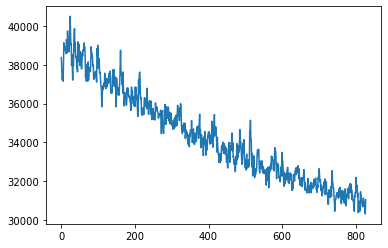

Validation


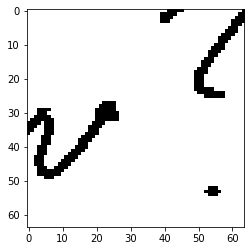

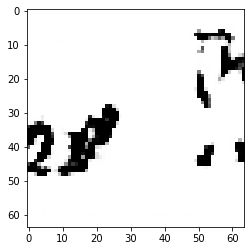

validation loss: 35531.64453125
Random


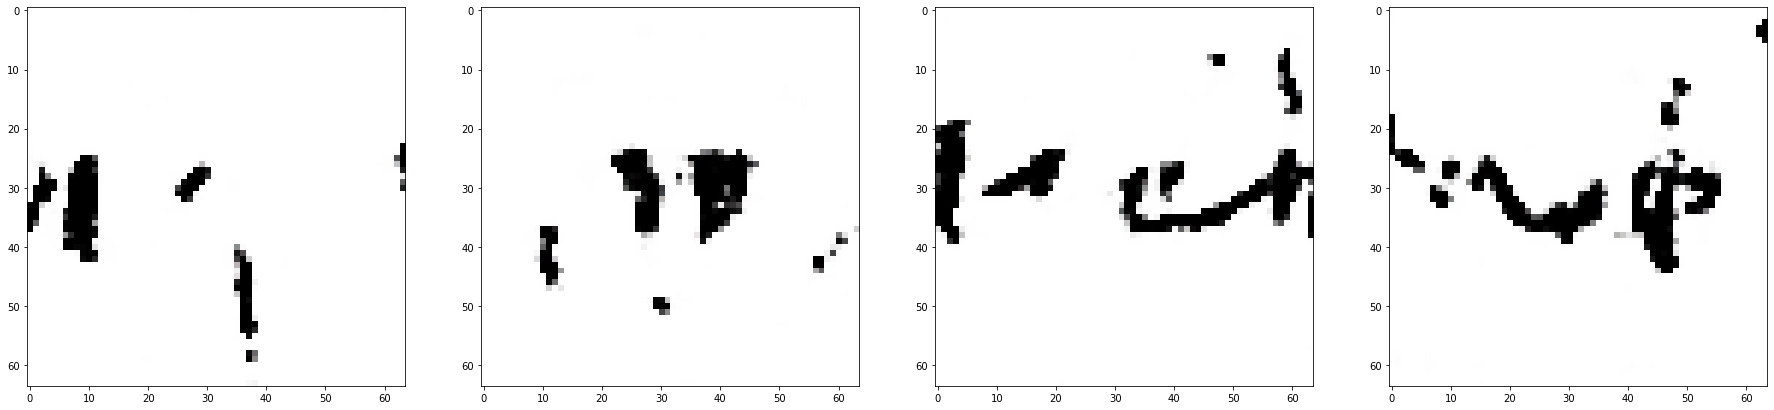

n_iter : 20775/46000, loss = 31009.237031250, time_since: 17992.01
n_iter : 20800/46000, loss = 30624.150625000, time_since: 18017.11
n_iter : 20825/46000, loss = 30709.871171875, time_since: 18039.94
n_iter : 20850/46000, loss = 30831.230156250, time_since: 18067.26
n_iter : 20875/46000, loss = 30917.002968750, time_since: 18090.48
n_iter : 20900/46000, loss = 30754.579921875, time_since: 18115.93
n_iter : 20925/46000, loss = 31411.971015625, time_since: 18139.35
n_iter : 20950/46000, loss = 31445.244375000, time_since: 18166.30
n_iter : 20975/46000, loss = 32237.636093750, time_since: 18189.06
n_iter : 21000/46000, loss = 31501.760781250, time_since: 18216.40


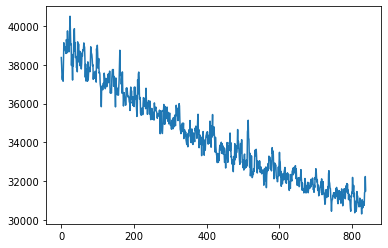

Validation


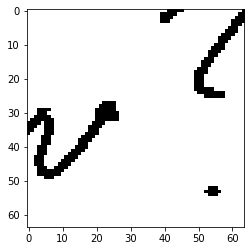

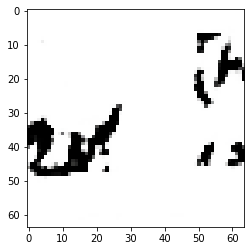

validation loss: 39701.39453125
Random


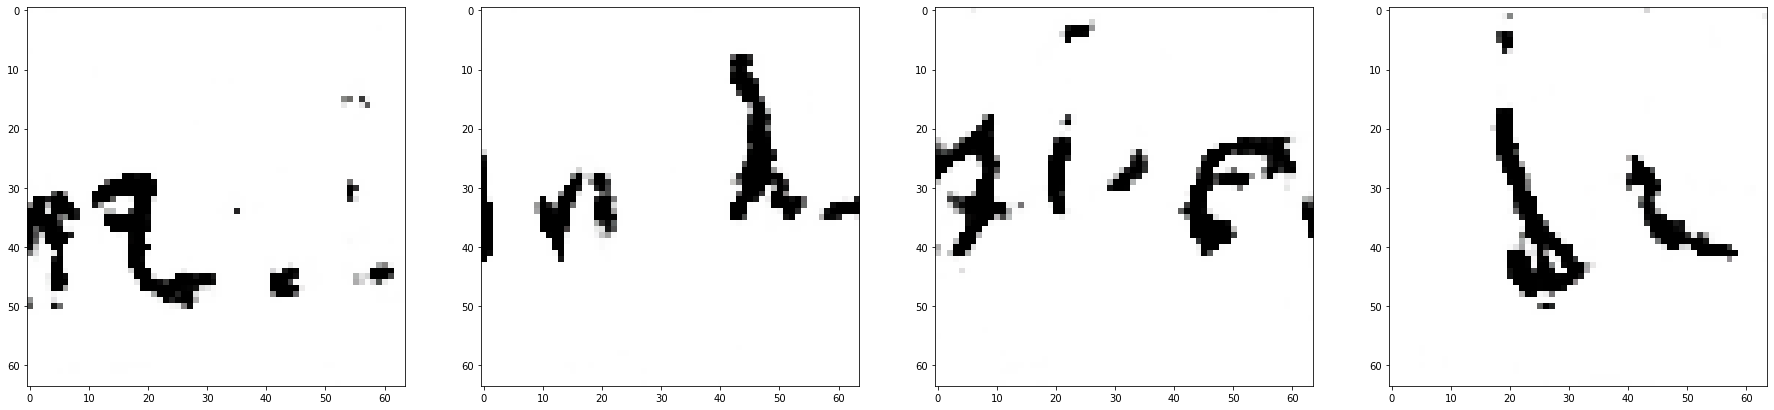

n_iter : 21025/46000, loss = 31759.543203125, time_since: 18244.26
n_iter : 21050/46000, loss = 30726.151015625, time_since: 18264.92
n_iter : 21075/46000, loss = 31020.214140625, time_since: 18289.96
n_iter : 21100/46000, loss = 30917.661171875, time_since: 18312.03
n_iter : 21125/46000, loss = 30737.708750000, time_since: 18336.44
n_iter : 21150/46000, loss = 30782.734843750, time_since: 18359.46
n_iter : 21175/46000, loss = 30677.794218750, time_since: 18384.40
n_iter : 21200/46000, loss = 31525.621640625, time_since: 18406.31
n_iter : 21225/46000, loss = 30900.791796875, time_since: 18430.81
n_iter : 21250/46000, loss = 30771.948750000, time_since: 18453.07


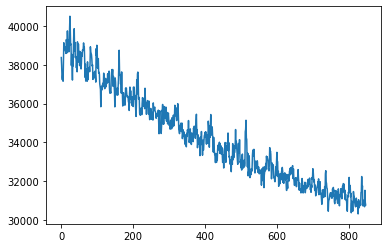

Validation


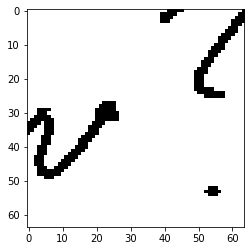

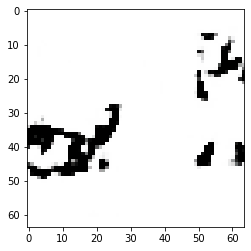

validation loss: 40056.77734375
Random


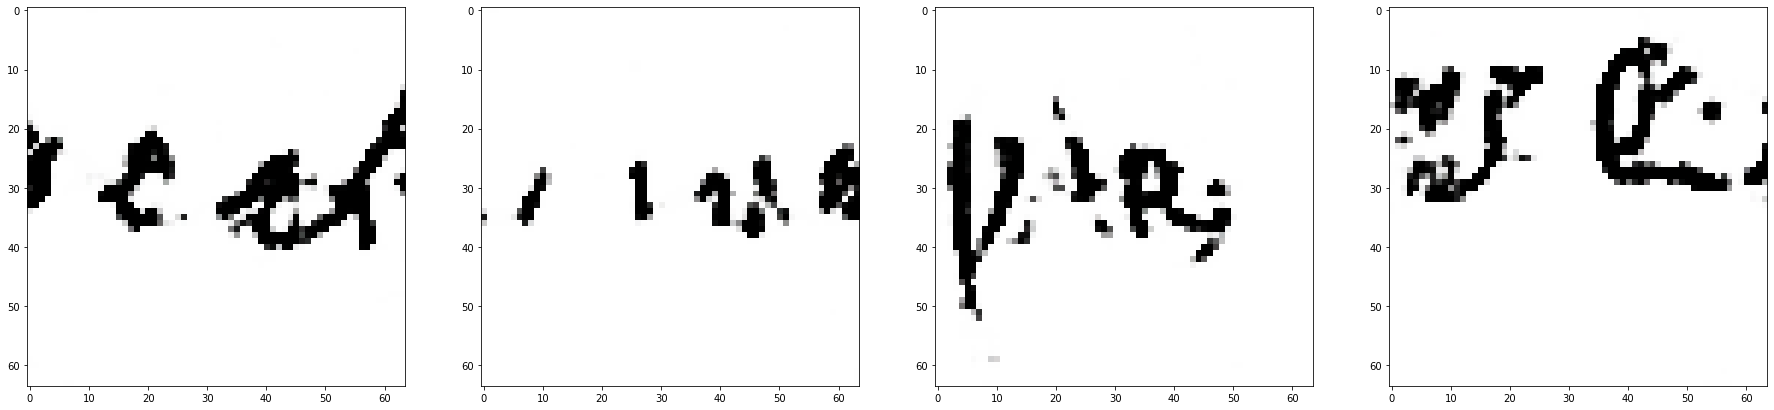

n_iter : 21275/46000, loss = 30762.538359375, time_since: 18479.49
n_iter : 21300/46000, loss = 30529.870468750, time_since: 18504.94
n_iter : 21325/46000, loss = 30485.738593750, time_since: 18527.17
n_iter : 21350/46000, loss = 30480.293359375, time_since: 18554.68
n_iter : 21375/46000, loss = 30257.373593750, time_since: 18577.18
n_iter : 21400/46000, loss = 30387.506484375, time_since: 18605.01
n_iter : 21425/46000, loss = 30723.784375000, time_since: 18627.96
n_iter : 21450/46000, loss = 30279.592421875, time_since: 18654.18
n_iter : 21475/46000, loss = 31026.782890625, time_since: 18677.73
n_iter : 21500/46000, loss = 31146.447265625, time_since: 18704.19


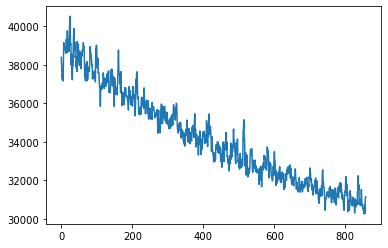

Validation


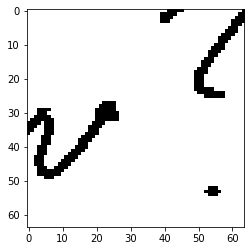

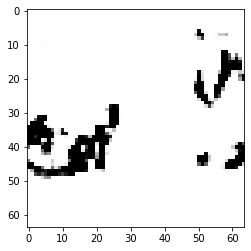

validation loss: 34976.51953125
Random


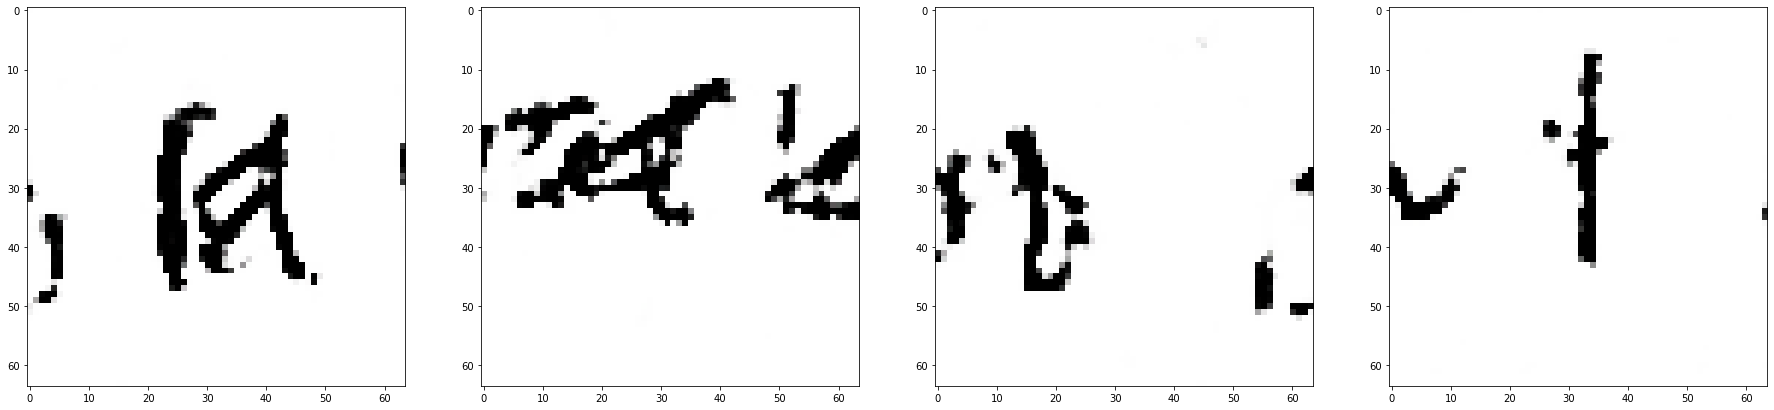

n_iter : 21525/46000, loss = 30436.031484375, time_since: 18726.93
n_iter : 21550/46000, loss = 30741.133906250, time_since: 18752.58
n_iter : 21575/46000, loss = 31184.173281250, time_since: 18778.28
n_iter : 21600/46000, loss = 30723.879609375, time_since: 18798.79
n_iter : 21625/46000, loss = 30075.723281250, time_since: 18822.74
n_iter : 21650/46000, loss = 30013.506484375, time_since: 18843.77
n_iter : 21675/46000, loss = 30561.550937500, time_since: 18869.96
n_iter : 21700/46000, loss = 30601.077500000, time_since: 18890.39
n_iter : 21725/46000, loss = 31052.577656250, time_since: 18916.88
n_iter : 21750/46000, loss = 31458.785703125, time_since: 18937.26


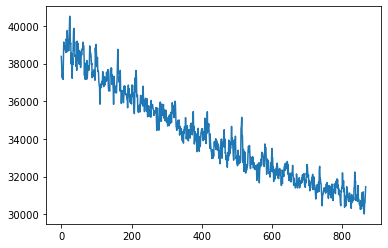

Validation


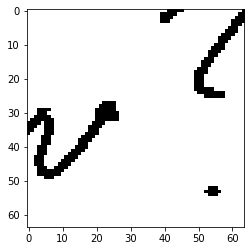

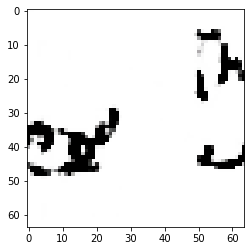

validation loss: 41266.0
Random


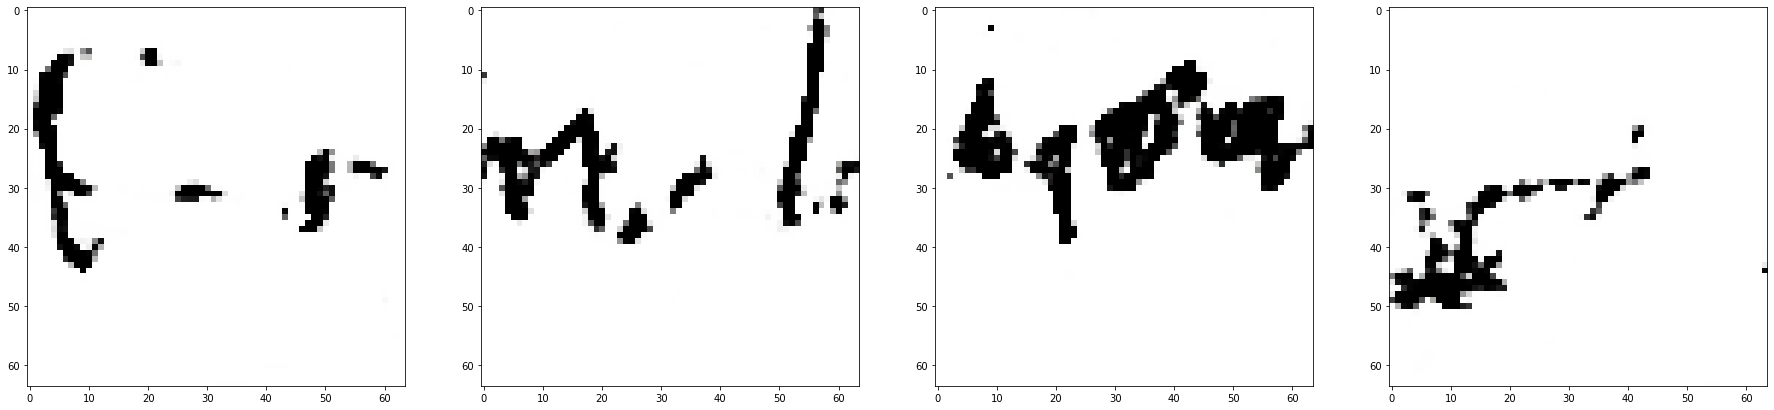

n_iter : 21775/46000, loss = 30684.925781250, time_since: 18962.25
n_iter : 21800/46000, loss = 31526.092734375, time_since: 18985.41
n_iter : 21825/46000, loss = 31020.168593750, time_since: 19009.94
n_iter : 21850/46000, loss = 30810.600703125, time_since: 19035.01
n_iter : 21875/46000, loss = 30831.976171875, time_since: 19056.25
n_iter : 21900/46000, loss = 31131.512656250, time_since: 19081.35
n_iter : 21925/46000, loss = 30839.870859375, time_since: 19101.85
n_iter : 21950/46000, loss = 30198.507343750, time_since: 19127.00
n_iter : 21975/46000, loss = 30818.716875000, time_since: 19148.10
n_iter : 22000/46000, loss = 30599.152265625, time_since: 19172.81


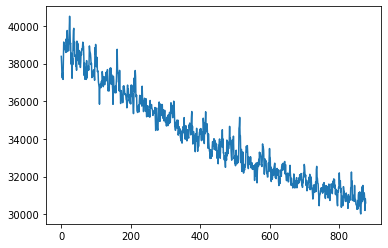

Validation


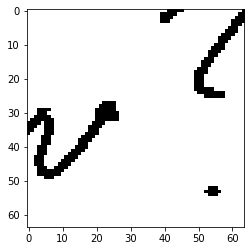

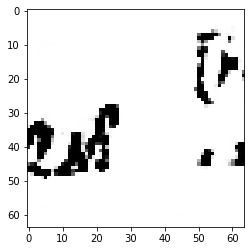

validation loss: 32173.763671875
Random


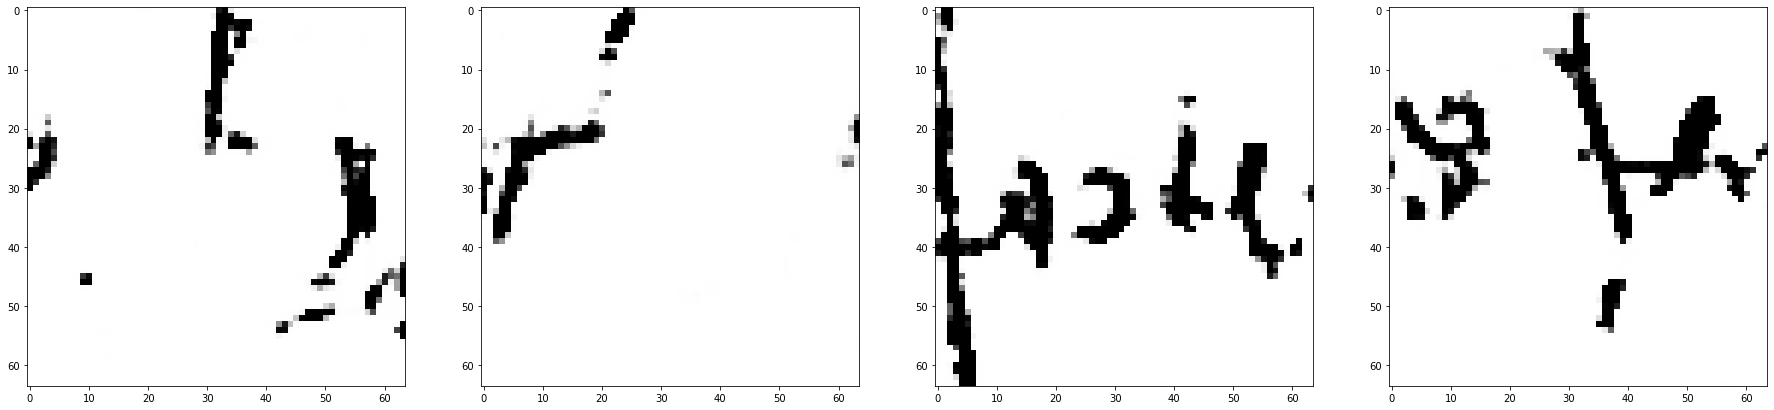

n_iter : 22025/46000, loss = 30321.405234375, time_since: 19195.00
n_iter : 22050/46000, loss = 29858.174296875, time_since: 19219.30
n_iter : 22075/46000, loss = 30154.681093750, time_since: 19240.53
n_iter : 22100/46000, loss = 30109.643515625, time_since: 19266.27
n_iter : 22125/46000, loss = 30450.237890625, time_since: 19286.68
n_iter : 22150/46000, loss = 30295.152734375, time_since: 19311.33
n_iter : 22175/46000, loss = 30775.149687500, time_since: 19337.07
n_iter : 22200/46000, loss = 30618.947812500, time_since: 19359.33
n_iter : 22225/46000, loss = 31103.864921875, time_since: 19383.34
n_iter : 22250/46000, loss = 31902.954531250, time_since: 19404.33


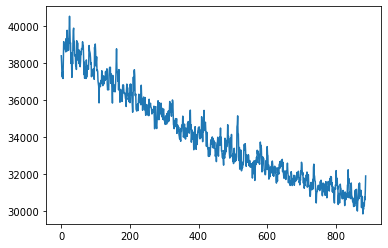

Validation


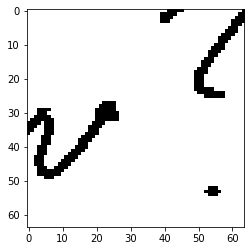

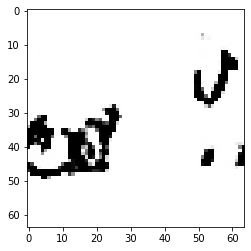

validation loss: 37919.9296875
Random


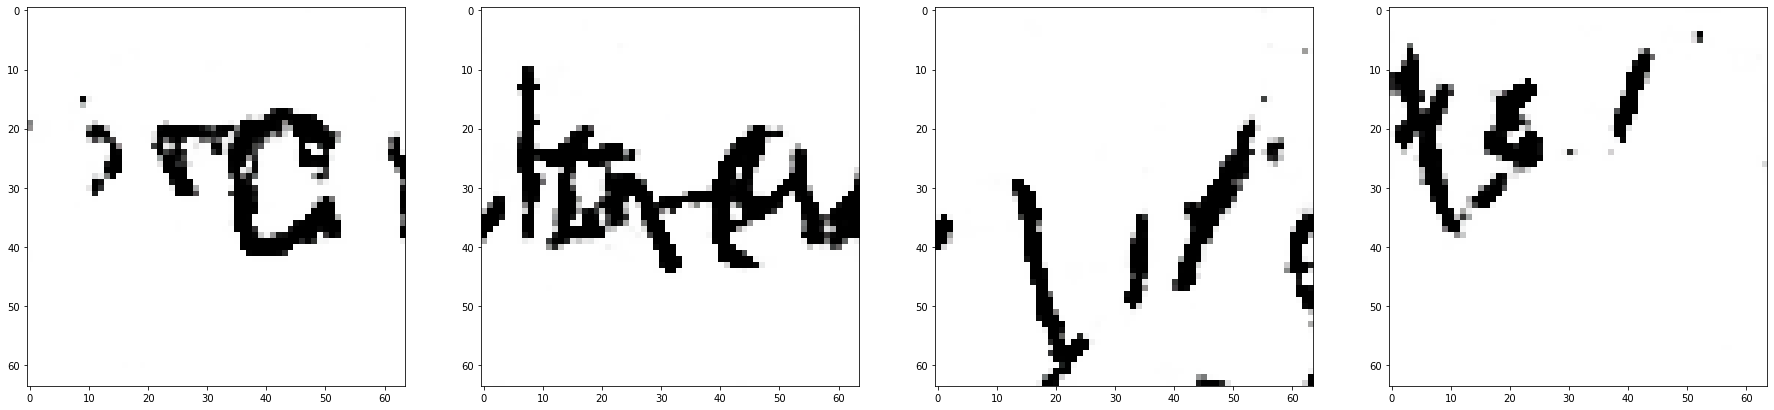

n_iter : 22275/46000, loss = 32328.909765625, time_since: 19429.34
n_iter : 22300/46000, loss = 31910.365625000, time_since: 19454.50
n_iter : 22325/46000, loss = 31069.226875000, time_since: 19479.50
n_iter : 22350/46000, loss = 31186.053359375, time_since: 19503.57
n_iter : 22375/46000, loss = 30255.040156250, time_since: 19529.09


In [ ]:
def save_model(model):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    

for epoch in range(n_epochs):
    
    for batch_features, _ in train_dl:
        optimizer.zero_grad()
        batch_features = batch_features.to(device)
        batch_hat, mu, log_var = model(batch_features)
        train_loss = model.loss_fnc(batch_hat, batch_features, mu, log_var)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
        
        if n_iter % print_every == 0:
            loss /= print_every
            losses.append(loss)
            time_since = time.time() - start_time
            print(f"n_iter : {n_iter}/{total_iters}, loss = {loss:.9f}, time_since: {time_since:.2f}")
            loss = 0
            save_model(model)
            
        if n_iter % sample_every == 0:
            if len(losses) > 10:
                _=plt.plot(losses[3:])
                plt.show()
            for image, _ in valid_dl:
                image = image.to(device)
                _=model.sample(image)
        
        n_iter += 1
